# YOLO NAS Training - UAV

## Necessary Setup and Imports

In [1]:
# One time installation.
!pip install super-gradients

## RESTART RUNTIME AFTER INSTALLATION IF RUNNING ON COLAB.

In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

[2023-05-09 13:25:10] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-09 13:25:16] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-09 13:25:16] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-09 13:25:16] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-09 13:25:16] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


## Download Dataset

In [2]:
# Download dataset.
def download_file(url, save_name):
    if not os.path.exists(save_name):
        print(f"Downloading file")
        file = requests.get(url, stream=True)
        total_size = int(file.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(
            total=total_size, 
            unit='iB', 
            unit_scale=True
        )
        with open(os.path.join(save_name), 'wb') as f:
            for data in file.iter_content(block_size):
                progress_bar.update(len(data))
                f.write(data)
        progress_bar.close()
    else:
        print('File already present')
        
download_file(
    'https://www.dropbox.com/s/xc2890eh8ujy3cu/hituav-a-highaltitude-infrared-thermal-dataset.zip?dl=1',
    'hituav-a-highaltitude-infrared-thermal-dataset.zip'
)

In [3]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('hituav-a-highaltitude-infrared-thermal-dataset.zip')

File already present


## Dataset Set Up

In [4]:
ROOT_DIR = 'hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']

In [5]:
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}

In [6]:
# Global parameters.
EPOCHS = 50
BATCH_SIZE = 16
WORKERS = 8

## Visualize Ground Truth Images

In [7]:
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [8]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3

        cv2.rectangle(
            image, 
            p1, p2, 
            color=color, 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            image, 
            class_name, 
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw/3.5, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

In [10]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
        
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Extracted all


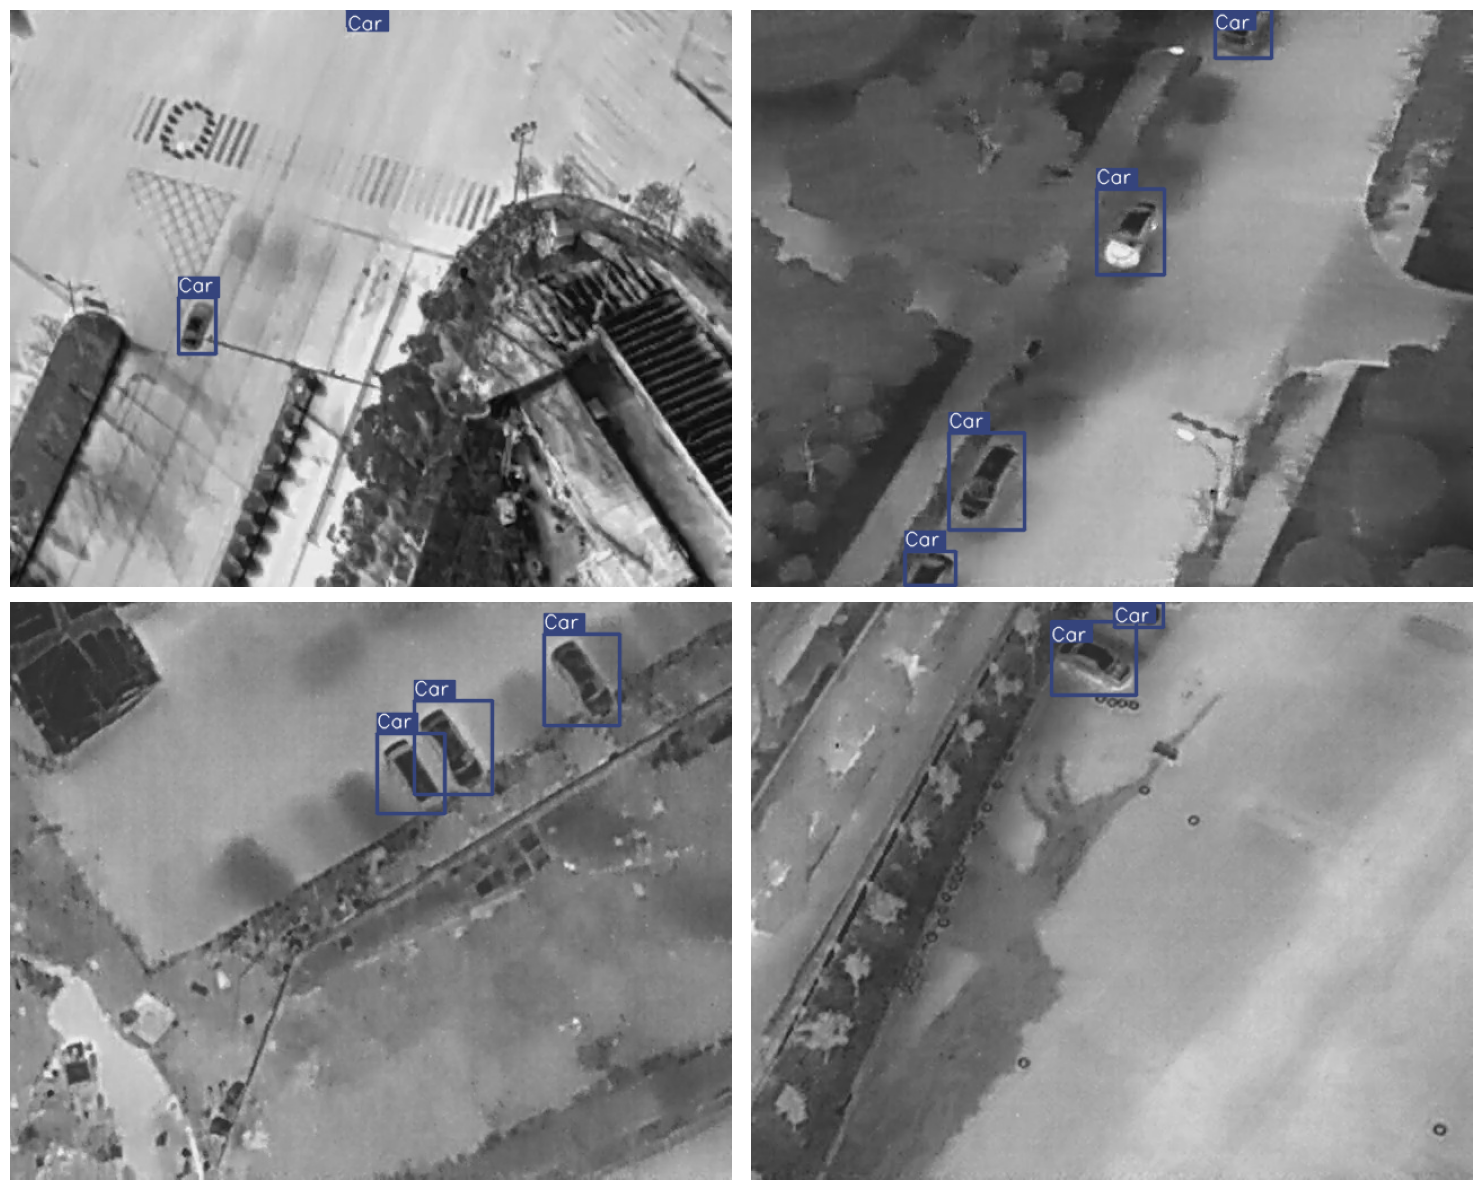

In [11]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=4,
)

## Data Preparation

In [12]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations: 100%|██████████| 2008/2008 [00:00<00:00, 2974.14it/s]


## Transforms and Augmentations

In [13]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [14]:
train_data.dataset.transforms[0]

DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114)

In [15]:
############ An example on how to modify augmentations ###########
train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

In [16]:
train_data.dataset.transforms

Caching annotations: 100%|██████████| 287/287 [00:00<00:00, 2868.57it/s]


[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1), 'input_dim': [640, 640], 'max_targets': 120, 'pad_value': 114),
 DetectionTargetsFormatTransform('additional_samples_count': 0, 'non_empty_targets': False, 'input_format': OrderedDict([('bboxes', name

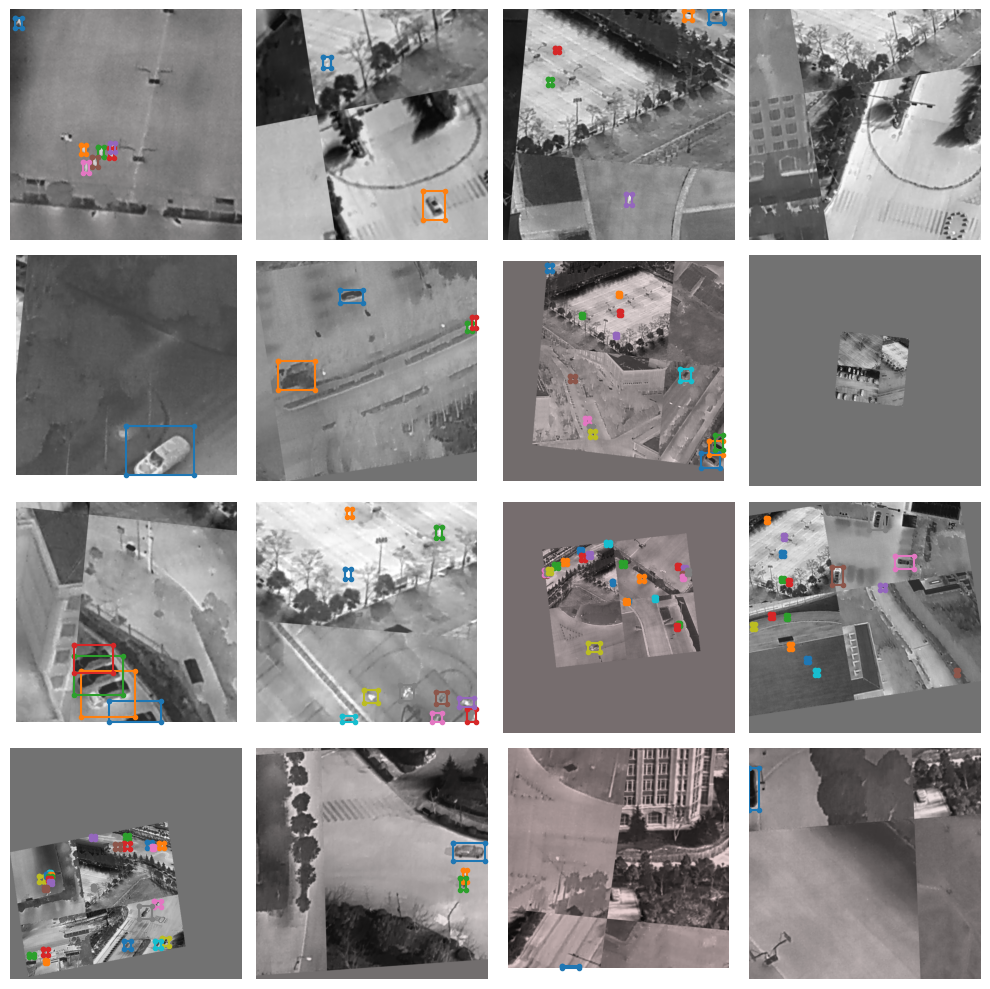

In [17]:
# We visualize the images with augmentation here.
train_data.dataset.plot(plot_transformed_data=True)

## Prepare Model and Training Parameters

In [18]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [19]:
models_to_train = [
    'yolo_nas_s',
    'yolo_nas_m',
    'yolo_nas_l'
]

In [20]:
CHECKPOINT_DIR = 'checkpoints'

### Model Training

In [21]:
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
    )

    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )

    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2023-05-09 13:25:26] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-05-09 13:25:30] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_s/console_May09_13_25_30.txt


[2023-05-09 13:25:34] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2008       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         125        (len(train_loader))
    - Gradient updates per epoch:   125        (len(train_loader) / batch_accumulate)

[2023-05-09 13:25:34] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Validation epoch 0: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.8575
│   ├── Ppyoloeloss/loss_cls = 2.3712
│   ├── Ppyoloeloss/loss_dfl = 1.1773
│   └── Ppyoloeloss/loss_iou = 0.3591
└── Validation
    ├── F1@0.50 = 0.0
    ├── F1@0.50:0.95 = 0.0
    ├── Map@0.50 = 0.0012
    ├── Map@0.50:0.95 = 0.0005
    ├── Ppyoloeloss/loss = 3.7911
    ├── Ppyoloeloss/loss_cls = 2.5251
    ├── Ppyoloeloss/loss_dfl = 0.9791
    ├── Ppyoloeloss/loss_iou = 0.3106
    ├── Precision@0.50 = 0.0
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50 = 0.0
    └── Recall@0.50:0.95 = 0.0



[2023-05-09 13:27:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:27:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0005030028405599296
Validation epoch 1: 100%|██████████| 18/18 [00:16<00:00,  1.06it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.1976
│   │   ├── Best until now = 3.8575 (↘ -1.6599)
│   │   └── Epoch N-1      = 3.8575 (↘ -1.6599)
│   ├── Ppyoloeloss/loss_cls = 1.1408
│   │   ├── Best until now = 2.3712 (↘ -1.2304)
│   │   └── Epoch N-1      = 2.3712 (↘ -1.2304)
│   ├── Ppyoloeloss/loss_dfl = 0.8475
│   │   ├── Best until now = 1.1773 (↘ -0.3298)
│   │   └── Epoch N-1      = 1.1773 (↘ -0.3298)
│   └── Ppyoloeloss/loss_iou = 0.2532
│       ├── Best until now = 0.3591 (↘ -0.1058)
│       └── Epoch N-1      = 0.3591 (↘ -0.1058)
└── Validation
    ├── F1@0.50 = 0.0907
    │   ├── Best until now = 0.0    (↗ 0.0907)
    │   └── Epoch N-1      = 0.0    (↗ 0.0907)
    ├── F1@0.50:0.95 = 0.05
    │   ├── Best until now = 0.0    (↗ 0.05)
    │   └── Epoch N-1      = 0.0    (↗ 0.05)
    ├── Map@0.50 = 0.3576
    │   ├── Best until now = 0.0012 (↗ 0.3563)
    │   └── Epoch N-1      = 0.0012 (↗ 0.3563)
    ├── Map@0.50:0.95 = 0.1761
    │   ├── Best until now = 0.00

[2023-05-09 13:28:57] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:28:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.17607565224170685
Validation epoch 2: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.9601
│   │   ├── Best until now = 2.1976 (↘ -0.2375)
│   │   └── Epoch N-1      = 2.1976 (↘ -0.2375)
│   ├── Ppyoloeloss/loss_cls = 0.9694
│   │   ├── Best until now = 1.1408 (↘ -0.1714)
│   │   └── Epoch N-1      = 1.1408 (↘ -0.1714)
│   ├── Ppyoloeloss/loss_dfl = 0.8128
│   │   ├── Best until now = 0.8475 (↘ -0.0347)
│   │   └── Epoch N-1      = 0.8475 (↘ -0.0347)
│   └── Ppyoloeloss/loss_iou = 0.2337
│       ├── Best until now = 0.2532 (↘ -0.0195)
│       └── Epoch N-1      = 0.2532 (↘ -0.0195)
└── Validation
    ├── F1@0.50 = 0.0873
    │   ├── Best until now = 0.0907 (↘ -0.0034)
    │   └── Epoch N-1      = 0.0907 (↘ -0.0034)
    ├── F1@0.50:0.95 = 0.0469
    │   ├── Best until now = 0.05   (↘ -0.003)
    │   └── Epoch N-1      = 0.05   (↘ -0.003)
    ├── Map@0.50 = 0.4069
    │   ├── Best until now = 0.3576 (↗ 0.0493)
    │   └── Epoch N-1      = 0.3576 (↗ 0.0493)
    ├── Map@0.50:0.95 = 0.1917
    │   ├── Best until no

[2023-05-09 13:30:40] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:30:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.19173432886600494
Validation epoch 3: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.9117
│   │   ├── Best until now = 1.9601 (↘ -0.0484)
│   │   └── Epoch N-1      = 1.9601 (↘ -0.0484)
│   ├── Ppyoloeloss/loss_cls = 0.9318
│   │   ├── Best until now = 0.9694 (↘ -0.0376)
│   │   └── Epoch N-1      = 0.9694 (↘ -0.0376)
│   ├── Ppyoloeloss/loss_dfl = 0.8136
│   │   ├── Best until now = 0.8128 (↗ 0.0007)
│   │   └── Epoch N-1      = 0.8128 (↗ 0.0007)
│   └── Ppyoloeloss/loss_iou = 0.2292
│       ├── Best until now = 0.2337 (↘ -0.0045)
│       └── Epoch N-1      = 0.2337 (↘ -0.0045)
└── Validation
    ├── F1@0.50 = 0.0958
    │   ├── Best until now = 0.0907 (↗ 0.0051)
    │   └── Epoch N-1      = 0.0873 (↗ 0.0085)
    ├── F1@0.50:0.95 = 0.0519
    │   ├── Best until now = 0.05   (↗ 0.0019)
    │   └── Epoch N-1      = 0.0469 (↗ 0.005)
    ├── Map@0.50 = 0.3855
    │   ├── Best until now = 0.4069 (↘ -0.0214)
    │   └── Epoch N-1      = 0.4069 (↘ -0.0214)
    ├── Map@0.50:0.95 = 0.1834
    │   ├── Best until now =

Validation epoch 4: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 1.8689
│   │   ├── Best until now = 1.9117 (↘ -0.0428)
│   │   └── Epoch N-1      = 1.9117 (↘ -0.0428)
│   ├── Ppyoloeloss/loss_cls = 0.9135
│   │   ├── Best until now = 0.9318 (↘ -0.0183)
│   │   └── Epoch N-1      = 0.9318 (↘ -0.0183)
│   ├── Ppyoloeloss/loss_dfl = 0.7924
│   │   ├── Best until now = 0.8128 (↘ -0.0204)
│   │   └── Epoch N-1      = 0.8136 (↘ -0.0211)
│   └── Ppyoloeloss/loss_iou = 0.2237
│       ├── Best until now = 0.2292 (↘ -0.0056)
│       └── Epoch N-1      = 0.2292 (↘ -0.0056)
└── Validation
    ├── F1@0.50 = 0.101
    │   ├── Best until now = 0.0958 (↗ 0.0051)
    │   └── Epoch N-1      = 0.0958 (↗ 0.0051)
    ├── F1@0.50:0.95 = 0.0573
    │   ├── Best until now = 0.0519 (↗ 0.0053)
    │   └── Epoch N-1      = 0.0519 (↗ 0.0053)
    ├── Map@0.50 = 0.4549
    │   ├── Best until now = 0.4069 (↗ 0.048)
    │   └── Epoch N-1      = 0.3855 (↗ 0.0694)
    ├── Map@0.50:0.95 = 0.222
    │   ├── Best until now = 0

[2023-05-09 13:34:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:34:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.22196127474308014
Validation epoch 5: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.8047
│   │   ├── Best until now = 1.8689 (↘ -0.0643)
│   │   └── Epoch N-1      = 1.8689 (↘ -0.0643)
│   ├── Ppyoloeloss/loss_cls = 0.8689
│   │   ├── Best until now = 0.9135 (↘ -0.0446)
│   │   └── Epoch N-1      = 0.9135 (↘ -0.0446)
│   ├── Ppyoloeloss/loss_dfl = 0.779
│   │   ├── Best until now = 0.7924 (↘ -0.0134)
│   │   └── Epoch N-1      = 0.7924 (↘ -0.0134)
│   └── Ppyoloeloss/loss_iou = 0.2185
│       ├── Best until now = 0.2237 (↘ -0.0052)
│       └── Epoch N-1      = 0.2237 (↘ -0.0052)
└── Validation
    ├── F1@0.50 = 0.1041
    │   ├── Best until now = 0.101  (↗ 0.0031)
    │   └── Epoch N-1      = 0.101  (↗ 0.0031)
    ├── F1@0.50:0.95 = 0.0594
    │   ├── Best until now = 0.0573 (↗ 0.0021)
    │   └── Epoch N-1      = 0.0573 (↗ 0.0021)
    ├── Map@0.50 = 0.4631
    │   ├── Best until now = 0.4549 (↗ 0.0083)
    │   └── Epoch N-1      = 0.4549 (↗ 0.0083)
    ├── Map@0.50:0.95 = 0.2292
    │   ├── Best until now =

[2023-05-09 13:35:49] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:35:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2292296290397644
Validation epoch 6: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.8067
│   │   ├── Best until now = 1.8047 (↗ 0.0021)
│   │   └── Epoch N-1      = 1.8047 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_cls = 0.8769
│   │   ├── Best until now = 0.8689 (↗ 0.008)
│   │   └── Epoch N-1      = 0.8689 (↗ 0.008)
│   ├── Ppyoloeloss/loss_dfl = 0.7707
│   │   ├── Best until now = 0.779  (↘ -0.0083)
│   │   └── Epoch N-1      = 0.779  (↘ -0.0083)
│   └── Ppyoloeloss/loss_iou = 0.2178
│       ├── Best until now = 0.2185 (↘ -0.0007)
│       └── Epoch N-1      = 0.2185 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.155
    │   ├── Best until now = 0.1041 (↗ 0.0509)
    │   └── Epoch N-1      = 0.1041 (↗ 0.0509)
    ├── F1@0.50:0.95 = 0.0885
    │   ├── Best until now = 0.0594 (↗ 0.0291)
    │   └── Epoch N-1      = 0.0594 (↗ 0.0291)
    ├── Map@0.50 = 0.4324
    │   ├── Best until now = 0.4631 (↘ -0.0307)
    │   └── Epoch N-1      = 0.4631 (↘ -0.0307)
    ├── Map@0.50:0.95 = 0.2158
    │   ├── Best until now = 0.2

Validation epoch 7: 100%|██████████| 18/18 [00:12<00:00,  1.42it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.7789
│   │   ├── Best until now = 1.8047 (↘ -0.0257)
│   │   └── Epoch N-1      = 1.8067 (↘ -0.0278)
│   ├── Ppyoloeloss/loss_cls = 0.8528
│   │   ├── Best until now = 0.8689 (↘ -0.0162)
│   │   └── Epoch N-1      = 0.8769 (↘ -0.0242)
│   ├── Ppyoloeloss/loss_dfl = 0.7654
│   │   ├── Best until now = 0.7707 (↘ -0.0053)
│   │   └── Epoch N-1      = 0.7707 (↘ -0.0053)
│   └── Ppyoloeloss/loss_iou = 0.2174
│       ├── Best until now = 0.2178 (↘ -0.0004)
│       └── Epoch N-1      = 0.2178 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.1188
    │   ├── Best until now = 0.155  (↘ -0.0363)
    │   └── Epoch N-1      = 0.155  (↘ -0.0363)
    ├── F1@0.50:0.95 = 0.0644
    │   ├── Best until now = 0.0885 (↘ -0.0241)
    │   └── Epoch N-1      = 0.0885 (↘ -0.0241)
    ├── Map@0.50 = 0.5039
    │   ├── Best until now = 0.4631 (↗ 0.0407)
    │   └── Epoch N-1      = 0.4324 (↗ 0.0714)
    ├── Map@0.50:0.95 = 0.2319
    │   ├── Best until 

[2023-05-09 13:39:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:39:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2319418340921402
Validation epoch 8: 100%|██████████| 18/18 [00:13<00:00,  1.33it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.7495
│   │   ├── Best until now = 1.7789 (↘ -0.0294)
│   │   └── Epoch N-1      = 1.7789 (↘ -0.0294)
│   ├── Ppyoloeloss/loss_cls = 0.8375
│   │   ├── Best until now = 0.8528 (↘ -0.0153)
│   │   └── Epoch N-1      = 0.8528 (↘ -0.0153)
│   ├── Ppyoloeloss/loss_dfl = 0.763
│   │   ├── Best until now = 0.7654 (↘ -0.0024)
│   │   └── Epoch N-1      = 0.7654 (↘ -0.0024)
│   └── Ppyoloeloss/loss_iou = 0.2122
│       ├── Best until now = 0.2174 (↘ -0.0052)
│       └── Epoch N-1      = 0.2174 (↘ -0.0052)
└── Validation
    ├── F1@0.50 = 0.1282
    │   ├── Best until now = 0.155  (↘ -0.0268)
    │   └── Epoch N-1      = 0.1188 (↗ 0.0094)
    ├── F1@0.50:0.95 = 0.0697
    │   ├── Best until now = 0.0885 (↘ -0.0188)
    │   └── Epoch N-1      = 0.0644 (↗ 0.0053)
    ├── Map@0.50 = 0.5098
    │   ├── Best until now = 0.5039 (↗ 0.0059)
    │   └── Epoch N-1      = 0.5039 (↗ 0.0059)
    ├── Map@0.50:0.95 = 0.2521
    │   ├── Best until now

[2023-05-09 13:41:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:41:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.25212204456329346
Validation epoch 9: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.7526
│   │   ├── Best until now = 1.7495 (↗ 0.0032)
│   │   └── Epoch N-1      = 1.7495 (↗ 0.0032)
│   ├── Ppyoloeloss/loss_cls = 0.8391
│   │   ├── Best until now = 0.8375 (↗ 0.0017)
│   │   └── Epoch N-1      = 0.8375 (↗ 0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.7638
│   │   ├── Best until now = 0.763  (↗ 0.0007)
│   │   └── Epoch N-1      = 0.763  (↗ 0.0007)
│   └── Ppyoloeloss/loss_iou = 0.2127
│       ├── Best until now = 0.2122 (↗ 0.0005)
│       └── Epoch N-1      = 0.2122 (↗ 0.0005)
└── Validation
    ├── F1@0.50 = 0.1302
    │   ├── Best until now = 0.155  (↘ -0.0248)
    │   └── Epoch N-1      = 0.1282 (↗ 0.002)
    ├── F1@0.50:0.95 = 0.0753
    │   ├── Best until now = 0.0885 (↘ -0.0132)
    │   └── Epoch N-1      = 0.0697 (↗ 0.0056)
    ├── Map@0.50 = 0.4947
    │   ├── Best until now = 0.5098 (↘ -0.015)
    │   └── Epoch N-1      = 0.5098 (↘ -0.015)
    ├── Map@0.50:0.95 = 0.2486
    │   ├── Best until now = 0.252

Validation epoch 10: 100%|██████████| 18/18 [00:13<00:00,  1.31it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.7412
│   │   ├── Best until now = 1.7495 (↘ -0.0083)
│   │   └── Epoch N-1      = 1.7526 (↘ -0.0114)
│   ├── Ppyoloeloss/loss_cls = 0.8339
│   │   ├── Best until now = 0.8375 (↘ -0.0035)
│   │   └── Epoch N-1      = 0.8391 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.7541
│   │   ├── Best until now = 0.763  (↘ -0.0089)
│   │   └── Epoch N-1      = 0.7638 (↘ -0.0097)
│   └── Ppyoloeloss/loss_iou = 0.2121
│       ├── Best until now = 0.2122 (↘ -1e-04)
│       └── Epoch N-1      = 0.2127 (↘ -0.0006)
└── Validation
    ├── F1@0.50 = 0.1353
    │   ├── Best until now = 0.155  (↘ -0.0197)
    │   └── Epoch N-1      = 0.1302 (↗ 0.0051)
    ├── F1@0.50:0.95 = 0.0778
    │   ├── Best until now = 0.0885 (↘ -0.0108)
    │   └── Epoch N-1      = 0.0753 (↗ 0.0024)
    ├── Map@0.50 = 0.5383
    │   ├── Best until now = 0.5098 (↗ 0.0285)
    │   └── Epoch N-1      = 0.4947 (↗ 0.0436)
    ├── Map@0.50:0.95 = 0.2652
    │   ├── Best until no

[2023-05-09 13:44:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:44:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2652221918106079
Validation epoch 11: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 1.7389
│   │   ├── Best until now = 1.7412 (↘ -0.0023)
│   │   └── Epoch N-1      = 1.7412 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_cls = 0.8321
│   │   ├── Best until now = 0.8339 (↘ -0.0018)
│   │   └── Epoch N-1      = 0.8339 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.7573
│   │   ├── Best until now = 0.7541 (↗ 0.0032)
│   │   └── Epoch N-1      = 0.7541 (↗ 0.0032)
│   └── Ppyoloeloss/loss_iou = 0.2113
│       ├── Best until now = 0.2121 (↘ -0.0008)
│       └── Epoch N-1      = 0.2121 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.1683
    │   ├── Best until now = 0.155  (↗ 0.0133)
    │   └── Epoch N-1      = 0.1353 (↗ 0.033)
    ├── F1@0.50:0.95 = 0.099
    │   ├── Best until now = 0.0885 (↗ 0.0105)
    │   └── Epoch N-1      = 0.0778 (↗ 0.0213)
    ├── Map@0.50 = 0.6009
    │   ├── Best until now = 0.5383 (↗ 0.0626)
    │   └── Epoch N-1      = 0.5383 (↗ 0.0626)
    ├── Map@0.50:0.95 = 0.3141
    │   ├── Best until now = 0

[2023-05-09 13:46:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:46:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.31412553787231445
Validation epoch 12: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 1.7188
│   │   ├── Best until now = 1.7389 (↘ -0.0201)
│   │   └── Epoch N-1      = 1.7389 (↘ -0.0201)
│   ├── Ppyoloeloss/loss_cls = 0.8213
│   │   ├── Best until now = 0.8321 (↘ -0.0107)
│   │   └── Epoch N-1      = 0.8321 (↘ -0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.748
│   │   ├── Best until now = 0.7541 (↘ -0.0061)
│   │   └── Epoch N-1      = 0.7573 (↘ -0.0093)
│   └── Ppyoloeloss/loss_iou = 0.2094
│       ├── Best until now = 0.2113 (↘ -0.0019)
│       └── Epoch N-1      = 0.2113 (↘ -0.0019)
└── Validation
    ├── F1@0.50 = 0.1269
    │   ├── Best until now = 0.1683 (↘ -0.0414)
    │   └── Epoch N-1      = 0.1683 (↘ -0.0414)
    ├── F1@0.50:0.95 = 0.0761
    │   ├── Best until now = 0.099  (↘ -0.023)
    │   └── Epoch N-1      = 0.099  (↘ -0.023)
    ├── Map@0.50 = 0.5616
    │   ├── Best until now = 0.6009 (↘ -0.0393)
    │   └── Epoch N-1      = 0.6009 (↘ -0.0393)
    ├── Map@0.50:0.95 = 0.3014
    │   ├── Best until 

Validation epoch 13: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 1.725
│   │   ├── Best until now = 1.7188 (↗ 0.0062)
│   │   └── Epoch N-1      = 1.7188 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_cls = 0.828
│   │   ├── Best until now = 0.8213 (↗ 0.0066)
│   │   └── Epoch N-1      = 0.8213 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.7518
│   │   ├── Best until now = 0.748  (↗ 0.0039)
│   │   └── Epoch N-1      = 0.748  (↗ 0.0039)
│   └── Ppyoloeloss/loss_iou = 0.2085
│       ├── Best until now = 0.2094 (↘ -0.0009)
│       └── Epoch N-1      = 0.2094 (↘ -0.0009)
└── Validation
    ├── F1@0.50 = 0.15
    │   ├── Best until now = 0.1683 (↘ -0.0183)
    │   └── Epoch N-1      = 0.1269 (↗ 0.0231)
    ├── F1@0.50:0.95 = 0.0848
    │   ├── Best until now = 0.099  (↘ -0.0142)
    │   └── Epoch N-1      = 0.0761 (↗ 0.0087)
    ├── Map@0.50 = 0.6156
    │   ├── Best until now = 0.6009 (↗ 0.0147)
    │   └── Epoch N-1      = 0.5616 (↗ 0.054)
    ├── Map@0.50:0.95 = 0.3142
    │   ├── Best until now = 0.3141

[2023-05-09 13:50:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:50:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.31423625349998474
Validation epoch 14: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 1.7215
│   │   ├── Best until now = 1.7188 (↗ 0.0027)
│   │   └── Epoch N-1      = 1.725  (↘ -0.0035)
│   ├── Ppyoloeloss/loss_cls = 0.8193
│   │   ├── Best until now = 0.8213 (↘ -0.002)
│   │   └── Epoch N-1      = 0.828  (↘ -0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.756
│   │   ├── Best until now = 0.748  (↗ 0.008)
│   │   └── Epoch N-1      = 0.7518 (↗ 0.0042)
│   └── Ppyoloeloss/loss_iou = 0.2097
│       ├── Best until now = 0.2085 (↗ 0.0012)
│       └── Epoch N-1      = 0.2085 (↗ 0.0012)
└── Validation
    ├── F1@0.50 = 0.1018
    │   ├── Best until now = 0.1683 (↘ -0.0665)
    │   └── Epoch N-1      = 0.15   (↘ -0.0481)
    ├── F1@0.50:0.95 = 0.0573
    │   ├── Best until now = 0.099  (↘ -0.0418)
    │   └── Epoch N-1      = 0.0848 (↘ -0.0275)
    ├── Map@0.50 = 0.5913
    │   ├── Best until now = 0.6156 (↘ -0.0243)
    │   └── Epoch N-1      = 0.6156 (↘ -0.0243)
    ├── Map@0.50:0.95 = 0.3147
    │   ├── Best until now =

[2023-05-09 13:52:03] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:52:03] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3146612048149109
Validation epoch 15: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.7129
│   │   ├── Best until now = 1.7188 (↘ -0.0059)
│   │   └── Epoch N-1      = 1.7215 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_cls = 0.8184
│   │   ├── Best until now = 0.8193 (↘ -0.0009)
│   │   └── Epoch N-1      = 0.8193 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.7502
│   │   ├── Best until now = 0.748  (↗ 0.0022)
│   │   └── Epoch N-1      = 0.756  (↘ -0.0058)
│   └── Ppyoloeloss/loss_iou = 0.2077
│       ├── Best until now = 0.2085 (↘ -0.0007)
│       └── Epoch N-1      = 0.2097 (↘ -0.0019)
└── Validation
    ├── F1@0.50 = 0.1431
    │   ├── Best until now = 0.1683 (↘ -0.0252)
    │   └── Epoch N-1      = 0.1018 (↗ 0.0412)
    ├── F1@0.50:0.95 = 0.0869
    │   ├── Best until now = 0.099  (↘ -0.0122)
    │   └── Epoch N-1      = 0.0573 (↗ 0.0296)
    ├── Map@0.50 = 0.6353
    │   ├── Best until now = 0.6156 (↗ 0.0197)
    │   └── Epoch N-1      = 0.5913 (↗ 0.044)
    ├── Map@0.50:0.95 = 0.3547
    │   ├── Best until now

[2023-05-09 13:53:53] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 13:53:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3547118902206421
Validation epoch 16: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 16
├── Training
│   ├── Ppyoloeloss/loss = 1.7184
│   │   ├── Best until now = 1.7129 (↗ 0.0055)
│   │   └── Epoch N-1      = 1.7129 (↗ 0.0055)
│   ├── Ppyoloeloss/loss_cls = 0.8206
│   │   ├── Best until now = 0.8184 (↗ 0.0022)
│   │   └── Epoch N-1      = 0.8184 (↗ 0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.7474
│   │   ├── Best until now = 0.748  (↘ -0.0006)
│   │   └── Epoch N-1      = 0.7502 (↘ -0.0028)
│   └── Ppyoloeloss/loss_iou = 0.2096
│       ├── Best until now = 0.2077 (↗ 0.0019)
│       └── Epoch N-1      = 0.2077 (↗ 0.0019)
└── Validation
    ├── F1@0.50 = 0.1452
    │   ├── Best until now = 0.1683 (↘ -0.0231)
    │   └── Epoch N-1      = 0.1431 (↗ 0.0022)
    ├── F1@0.50:0.95 = 0.0813
    │   ├── Best until now = 0.099  (↘ -0.0178)
    │   └── Epoch N-1      = 0.0869 (↘ -0.0056)
    ├── Map@0.50 = 0.553
    │   ├── Best until now = 0.6353 (↘ -0.0823)
    │   └── Epoch N-1      = 0.6353 (↘ -0.0823)
    ├── Map@0.50:0.95 = 0.2736
    │   ├── Best until now =

Validation epoch 17: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


SUMMARY OF EPOCH 17
├── Training
│   ├── Ppyoloeloss/loss = 1.7035
│   │   ├── Best until now = 1.7129 (↘ -0.0094)
│   │   └── Epoch N-1      = 1.7184 (↘ -0.0149)
│   ├── Ppyoloeloss/loss_cls = 0.8135
│   │   ├── Best until now = 0.8184 (↘ -0.005)
│   │   └── Epoch N-1      = 0.8206 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_dfl = 0.7436
│   │   ├── Best until now = 0.7474 (↘ -0.0038)
│   │   └── Epoch N-1      = 0.7474 (↘ -0.0038)
│   └── Ppyoloeloss/loss_iou = 0.2073
│       ├── Best until now = 0.2077 (↘ -0.0004)
│       └── Epoch N-1      = 0.2096 (↘ -0.0023)
└── Validation
    ├── F1@0.50 = 0.1673
    │   ├── Best until now = 0.1683 (↘ -0.001)
    │   └── Epoch N-1      = 0.1452 (↗ 0.0221)
    ├── F1@0.50:0.95 = 0.0959
    │   ├── Best until now = 0.099  (↘ -0.0032)
    │   └── Epoch N-1      = 0.0813 (↗ 0.0146)
    ├── Map@0.50 = 0.6815
    │   ├── Best until now = 0.6353 (↗ 0.0462)
    │   └── Epoch N-1      = 0.553  (↗ 0.1285)
    ├── Map@0.50:0.95 = 0.3522
    │   ├── Best until now

Validation epoch 18: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 18
├── Training
│   ├── Ppyoloeloss/loss = 1.6907
│   │   ├── Best until now = 1.7035 (↘ -0.0128)
│   │   └── Epoch N-1      = 1.7035 (↘ -0.0128)
│   ├── Ppyoloeloss/loss_cls = 0.8025
│   │   ├── Best until now = 0.8135 (↘ -0.011)
│   │   └── Epoch N-1      = 0.8135 (↘ -0.011)
│   ├── Ppyoloeloss/loss_dfl = 0.7472
│   │   ├── Best until now = 0.7436 (↗ 0.0036)
│   │   └── Epoch N-1      = 0.7436 (↗ 0.0036)
│   └── Ppyoloeloss/loss_iou = 0.2059
│       ├── Best until now = 0.2073 (↘ -0.0014)
│       └── Epoch N-1      = 0.2073 (↘ -0.0014)
└── Validation
    ├── F1@0.50 = 0.1514
    │   ├── Best until now = 0.1683 (↘ -0.0169)
    │   └── Epoch N-1      = 0.1673 (↘ -0.0159)
    ├── F1@0.50:0.95 = 0.0872
    │   ├── Best until now = 0.099  (↘ -0.0118)
    │   └── Epoch N-1      = 0.0959 (↘ -0.0086)
    ├── Map@0.50 = 0.6298
    │   ├── Best until now = 0.6815 (↘ -0.0517)
    │   └── Epoch N-1      = 0.6815 (↘ -0.0517)
    ├── Map@0.50:0.95 = 0.33
    │   ├── Best until now

Validation epoch 19: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


SUMMARY OF EPOCH 19
├── Training
│   ├── Ppyoloeloss/loss = 1.6699
│   │   ├── Best until now = 1.6907 (↘ -0.0208)
│   │   └── Epoch N-1      = 1.6907 (↘ -0.0208)
│   ├── Ppyoloeloss/loss_cls = 0.7971
│   │   ├── Best until now = 0.8025 (↘ -0.0054)
│   │   └── Epoch N-1      = 0.8025 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.7345
│   │   ├── Best until now = 0.7436 (↘ -0.0091)
│   │   └── Epoch N-1      = 0.7472 (↘ -0.0127)
│   └── Ppyoloeloss/loss_iou = 0.2022
│       ├── Best until now = 0.2059 (↘ -0.0036)
│       └── Epoch N-1      = 0.2059 (↘ -0.0036)
└── Validation
    ├── F1@0.50 = 0.1648
    │   ├── Best until now = 0.1683 (↘ -0.0035)
    │   └── Epoch N-1      = 0.1514 (↗ 0.0134)
    ├── F1@0.50:0.95 = 0.0982
    │   ├── Best until now = 0.099  (↘ -0.0008)
    │   └── Epoch N-1      = 0.0872 (↗ 0.011)
    ├── Map@0.50 = 0.6822
    │   ├── Best until now = 0.6815 (↗ 0.0007)
    │   └── Epoch N-1      = 0.6298 (↗ 0.0524)
    ├── Map@0.50:0.95 = 0.355
    │   ├── Best until now

[2023-05-09 14:01:10] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:01:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3549503684043884
Validation epoch 20: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 1.6658
│   │   ├── Best until now = 1.6699 (↘ -0.0041)
│   │   └── Epoch N-1      = 1.6699 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_cls = 0.7934
│   │   ├── Best until now = 0.7971 (↘ -0.0037)
│   │   └── Epoch N-1      = 0.7971 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.7378
│   │   ├── Best until now = 0.7345 (↗ 0.0033)
│   │   └── Epoch N-1      = 0.7345 (↗ 0.0033)
│   └── Ppyoloeloss/loss_iou = 0.2014
│       ├── Best until now = 0.2022 (↘ -0.0008)
│       └── Epoch N-1      = 0.2022 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.1714
    │   ├── Best until now = 0.1683 (↗ 0.0031)
    │   └── Epoch N-1      = 0.1648 (↗ 0.0066)
    ├── F1@0.50:0.95 = 0.0982
    │   ├── Best until now = 0.099  (↘ -0.0009)
    │   └── Epoch N-1      = 0.0982 (↘ -0.0001)
    ├── Map@0.50 = 0.6979
    │   ├── Best until now = 0.6822 (↗ 0.0157)
    │   └── Epoch N-1      = 0.6822 (↗ 0.0157)
    ├── Map@0.50:0.95 = 0.3773
    │   ├── Best until now

[2023-05-09 14:03:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:03:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.37729254364967346
Validation epoch 21: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 21
├── Training
│   ├── Ppyoloeloss/loss = 1.6591
│   │   ├── Best until now = 1.6658 (↘ -0.0067)
│   │   └── Epoch N-1      = 1.6658 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_cls = 0.7902
│   │   ├── Best until now = 0.7934 (↘ -0.0032)
│   │   └── Epoch N-1      = 0.7934 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.7325
│   │   ├── Best until now = 0.7345 (↘ -0.0019)
│   │   └── Epoch N-1      = 0.7378 (↘ -0.0053)
│   └── Ppyoloeloss/loss_iou = 0.2011
│       ├── Best until now = 0.2014 (↘ -0.0004)
│       └── Epoch N-1      = 0.2014 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.1416
    │   ├── Best until now = 0.1714 (↘ -0.0298)
    │   └── Epoch N-1      = 0.1714 (↘ -0.0298)
    ├── F1@0.50:0.95 = 0.0783
    │   ├── Best until now = 0.099  (↘ -0.0208)
    │   └── Epoch N-1      = 0.0982 (↘ -0.0199)
    ├── Map@0.50 = 0.6791
    │   ├── Best until now = 0.6979 (↘ -0.0188)
    │   └── Epoch N-1      = 0.6979 (↘ -0.0188)
    ├── Map@0.50:0.95 = 0.3374
    │   ├── Best unt

Validation epoch 22: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


SUMMARY OF EPOCH 22
├── Training
│   ├── Ppyoloeloss/loss = 1.6587
│   │   ├── Best until now = 1.6591 (↘ -0.0004)
│   │   └── Epoch N-1      = 1.6591 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_cls = 0.7895
│   │   ├── Best until now = 0.7902 (↘ -0.0007)
│   │   └── Epoch N-1      = 0.7902 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.7246
│   │   ├── Best until now = 0.7325 (↘ -0.0079)
│   │   └── Epoch N-1      = 0.7325 (↘ -0.0079)
│   └── Ppyoloeloss/loss_iou = 0.2027
│       ├── Best until now = 0.2011 (↗ 0.0017)
│       └── Epoch N-1      = 0.2011 (↗ 0.0017)
└── Validation
    ├── F1@0.50 = 0.1532
    │   ├── Best until now = 0.1714 (↘ -0.0182)
    │   └── Epoch N-1      = 0.1416 (↗ 0.0116)
    ├── F1@0.50:0.95 = 0.0943
    │   ├── Best until now = 0.099  (↘ -0.0047)
    │   └── Epoch N-1      = 0.0783 (↗ 0.0161)
    ├── Map@0.50 = 0.6571
    │   ├── Best until now = 0.6979 (↘ -0.0408)
    │   └── Epoch N-1      = 0.6791 (↘ -0.022)
    ├── Map@0.50:0.95 = 0.3709
    │   ├── Best until no

Validation epoch 23: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


SUMMARY OF EPOCH 23
├── Training
│   ├── Ppyoloeloss/loss = 1.6524
│   │   ├── Best until now = 1.6587 (↘ -0.0062)
│   │   └── Epoch N-1      = 1.6587 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_cls = 0.7868
│   │   ├── Best until now = 0.7895 (↘ -0.0027)
│   │   └── Epoch N-1      = 0.7895 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.7243
│   │   ├── Best until now = 0.7246 (↘ -0.0003)
│   │   └── Epoch N-1      = 0.7246 (↘ -0.0003)
│   └── Ppyoloeloss/loss_iou = 0.2014
│       ├── Best until now = 0.2011 (↗ 0.0003)
│       └── Epoch N-1      = 0.2027 (↘ -0.0013)
└── Validation
    ├── F1@0.50 = 0.1346
    │   ├── Best until now = 0.1714 (↘ -0.0367)
    │   └── Epoch N-1      = 0.1532 (↘ -0.0185)
    ├── F1@0.50:0.95 = 0.078
    │   ├── Best until now = 0.099  (↘ -0.021)
    │   └── Epoch N-1      = 0.0943 (↘ -0.0163)
    ├── Map@0.50 = 0.6515
    │   ├── Best until now = 0.6979 (↘ -0.0464)
    │   └── Epoch N-1      = 0.6571 (↘ -0.0056)
    ├── Map@0.50:0.95 = 0.3414
    │   ├── Best until 

Validation epoch 24: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 24
├── Training
│   ├── Ppyoloeloss/loss = 1.642
│   │   ├── Best until now = 1.6524 (↘ -0.0104)
│   │   └── Epoch N-1      = 1.6524 (↘ -0.0104)
│   ├── Ppyoloeloss/loss_cls = 0.78
│   │   ├── Best until now = 0.7868 (↘ -0.0068)
│   │   └── Epoch N-1      = 0.7868 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.7211
│   │   ├── Best until now = 0.7243 (↘ -0.0033)
│   │   └── Epoch N-1      = 0.7243 (↘ -0.0033)
│   └── Ppyoloeloss/loss_iou = 0.2006
│       ├── Best until now = 0.2011 (↘ -0.0005)
│       └── Epoch N-1      = 0.2014 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.194
    │   ├── Best until now = 0.1714 (↗ 0.0226)
    │   └── Epoch N-1      = 0.1346 (↗ 0.0594)
    ├── F1@0.50:0.95 = 0.1144
    │   ├── Best until now = 0.099  (↗ 0.0154)
    │   └── Epoch N-1      = 0.078  (↗ 0.0364)
    ├── Map@0.50 = 0.6356
    │   ├── Best until now = 0.6979 (↘ -0.0623)
    │   └── Epoch N-1      = 0.6515 (↘ -0.0159)
    ├── Map@0.50:0.95 = 0.3335
    │   ├── Best until now =

Validation epoch 25: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


SUMMARY OF EPOCH 25
├── Training
│   ├── Ppyoloeloss/loss = 1.6398
│   │   ├── Best until now = 1.642  (↘ -0.0022)
│   │   └── Epoch N-1      = 1.642  (↘ -0.0022)
│   ├── Ppyoloeloss/loss_cls = 0.7772
│   │   ├── Best until now = 0.78   (↘ -0.0028)
│   │   └── Epoch N-1      = 0.78   (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.7333
│   │   ├── Best until now = 0.7211 (↗ 0.0122)
│   │   └── Epoch N-1      = 0.7211 (↗ 0.0122)
│   └── Ppyoloeloss/loss_iou = 0.1984
│       ├── Best until now = 0.2006 (↘ -0.0022)
│       └── Epoch N-1      = 0.2006 (↘ -0.0022)
└── Validation
    ├── F1@0.50 = 0.1683
    │   ├── Best until now = 0.194  (↘ -0.0257)
    │   └── Epoch N-1      = 0.194  (↘ -0.0257)
    ├── F1@0.50:0.95 = 0.0961
    │   ├── Best until now = 0.1144 (↘ -0.0183)
    │   └── Epoch N-1      = 0.1144 (↘ -0.0183)
    ├── Map@0.50 = 0.6798
    │   ├── Best until now = 0.6979 (↘ -0.0181)
    │   └── Epoch N-1      = 0.6356 (↗ 0.0442)
    ├── Map@0.50:0.95 = 0.3498
    │   ├── Best until 

Validation epoch 26: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


SUMMARY OF EPOCH 26
├── Training
│   ├── Ppyoloeloss/loss = 1.6363
│   │   ├── Best until now = 1.6398 (↘ -0.0035)
│   │   └── Epoch N-1      = 1.6398 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_cls = 0.7719
│   │   ├── Best until now = 0.7772 (↘ -0.0052)
│   │   └── Epoch N-1      = 0.7772 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.7317
│   │   ├── Best until now = 0.7211 (↗ 0.0106)
│   │   └── Epoch N-1      = 0.7333 (↘ -0.0016)
│   └── Ppyoloeloss/loss_iou = 0.1994
│       ├── Best until now = 0.1984 (↗ 0.001)
│       └── Epoch N-1      = 0.1984 (↗ 0.001)
└── Validation
    ├── F1@0.50 = 0.1738
    │   ├── Best until now = 0.194  (↘ -0.0202)
    │   └── Epoch N-1      = 0.1683 (↗ 0.0055)
    ├── F1@0.50:0.95 = 0.0987
    │   ├── Best until now = 0.1144 (↘ -0.0157)
    │   └── Epoch N-1      = 0.0961 (↗ 0.0026)
    ├── Map@0.50 = 0.6772
    │   ├── Best until now = 0.6979 (↘ -0.0207)
    │   └── Epoch N-1      = 0.6798 (↘ -0.0026)
    ├── Map@0.50:0.95 = 0.3427
    │   ├── Best until now 

Validation epoch 27: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


SUMMARY OF EPOCH 27
├── Training
│   ├── Ppyoloeloss/loss = 1.6209
│   │   ├── Best until now = 1.6363 (↘ -0.0154)
│   │   └── Epoch N-1      = 1.6363 (↘ -0.0154)
│   ├── Ppyoloeloss/loss_cls = 0.7664
│   │   ├── Best until now = 0.7719 (↘ -0.0056)
│   │   └── Epoch N-1      = 0.7719 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.7157
│   │   ├── Best until now = 0.7211 (↘ -0.0053)
│   │   └── Epoch N-1      = 0.7317 (↘ -0.016)
│   └── Ppyoloeloss/loss_iou = 0.1987
│       ├── Best until now = 0.1984 (↗ 0.0003)
│       └── Epoch N-1      = 0.1994 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.1702
    │   ├── Best until now = 0.194  (↘ -0.0238)
    │   └── Epoch N-1      = 0.1738 (↘ -0.0036)
    ├── F1@0.50:0.95 = 0.0978
    │   ├── Best until now = 0.1144 (↘ -0.0166)
    │   └── Epoch N-1      = 0.0987 (↘ -0.0009)
    ├── Map@0.50 = 0.7228
    │   ├── Best until now = 0.6979 (↗ 0.0249)
    │   └── Epoch N-1      = 0.6772 (↗ 0.0456)
    ├── Map@0.50:0.95 = 0.3714
    │   ├── Best until n

Validation epoch 28: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 28
├── Training
│   ├── Ppyoloeloss/loss = 1.6142
│   │   ├── Best until now = 1.6209 (↘ -0.0067)
│   │   └── Epoch N-1      = 1.6209 (↘ -0.0067)
│   ├── Ppyoloeloss/loss_cls = 0.7661
│   │   ├── Best until now = 0.7664 (↘ -0.0002)
│   │   └── Epoch N-1      = 0.7664 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.7097
│   │   ├── Best until now = 0.7157 (↘ -0.006)
│   │   └── Epoch N-1      = 0.7157 (↘ -0.006)
│   └── Ppyoloeloss/loss_iou = 0.1973
│       ├── Best until now = 0.1984 (↘ -0.0011)
│       └── Epoch N-1      = 0.1987 (↘ -0.0014)
└── Validation
    ├── F1@0.50 = 0.2073
    │   ├── Best until now = 0.194  (↗ 0.0133)
    │   └── Epoch N-1      = 0.1702 (↗ 0.037)
    ├── F1@0.50:0.95 = 0.1211
    │   ├── Best until now = 0.1144 (↗ 0.0067)
    │   └── Epoch N-1      = 0.0978 (↗ 0.0233)
    ├── Map@0.50 = 0.7002
    │   ├── Best until now = 0.7228 (↘ -0.0226)
    │   └── Epoch N-1      = 0.7228 (↘ -0.0226)
    ├── Map@0.50:0.95 = 0.3675
    │   ├── Best until now 

Validation epoch 29: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 29
├── Training
│   ├── Ppyoloeloss/loss = 1.5957
│   │   ├── Best until now = 1.6142 (↘ -0.0185)
│   │   └── Epoch N-1      = 1.6142 (↘ -0.0185)
│   ├── Ppyoloeloss/loss_cls = 0.7526
│   │   ├── Best until now = 0.7661 (↘ -0.0136)
│   │   └── Epoch N-1      = 0.7661 (↘ -0.0136)
│   ├── Ppyoloeloss/loss_dfl = 0.7137
│   │   ├── Best until now = 0.7097 (↗ 0.004)
│   │   └── Epoch N-1      = 0.7097 (↗ 0.004)
│   └── Ppyoloeloss/loss_iou = 0.1945
│       ├── Best until now = 0.1973 (↘ -0.0028)
│       └── Epoch N-1      = 0.1973 (↘ -0.0028)
└── Validation
    ├── F1@0.50 = 0.1828
    │   ├── Best until now = 0.2073 (↘ -0.0245)
    │   └── Epoch N-1      = 0.2073 (↘ -0.0245)
    ├── F1@0.50:0.95 = 0.1028
    │   ├── Best until now = 0.1211 (↘ -0.0183)
    │   └── Epoch N-1      = 0.1211 (↘ -0.0183)
    ├── Map@0.50 = 0.7256
    │   ├── Best until now = 0.7228 (↗ 0.0028)
    │   └── Epoch N-1      = 0.7002 (↗ 0.0254)
    ├── Map@0.50:0.95 = 0.3616
    │   ├── Best until now

Validation epoch 30: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 30
├── Training
│   ├── Ppyoloeloss/loss = 1.6051
│   │   ├── Best until now = 1.5957 (↗ 0.0094)
│   │   └── Epoch N-1      = 1.5957 (↗ 0.0094)
│   ├── Ppyoloeloss/loss_cls = 0.7555
│   │   ├── Best until now = 0.7526 (↗ 0.0029)
│   │   └── Epoch N-1      = 0.7526 (↗ 0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.7193
│   │   ├── Best until now = 0.7097 (↗ 0.0096)
│   │   └── Epoch N-1      = 0.7137 (↗ 0.0056)
│   └── Ppyoloeloss/loss_iou = 0.196
│       ├── Best until now = 0.1945 (↗ 0.0015)
│       └── Epoch N-1      = 0.1945 (↗ 0.0015)
└── Validation
    ├── F1@0.50 = 0.2038
    │   ├── Best until now = 0.2073 (↘ -0.0034)
    │   └── Epoch N-1      = 0.1828 (↗ 0.021)
    ├── F1@0.50:0.95 = 0.1235
    │   ├── Best until now = 0.1211 (↗ 0.0024)
    │   └── Epoch N-1      = 0.1028 (↗ 0.0206)
    ├── Map@0.50 = 0.6585
    │   ├── Best until now = 0.7256 (↘ -0.067)
    │   └── Epoch N-1      = 0.7256 (↘ -0.067)
    ├── Map@0.50:0.95 = 0.3527
    │   ├── Best until now = 0.3773

Validation epoch 31: 100%|██████████| 18/18 [00:13<00:00,  1.30it/s]


SUMMARY OF EPOCH 31
├── Training
│   ├── Ppyoloeloss/loss = 1.5938
│   │   ├── Best until now = 1.5957 (↘ -0.0019)
│   │   └── Epoch N-1      = 1.6051 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_cls = 0.7537
│   │   ├── Best until now = 0.7526 (↗ 0.0011)
│   │   └── Epoch N-1      = 0.7555 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.7171
│   │   ├── Best until now = 0.7097 (↗ 0.0074)
│   │   └── Epoch N-1      = 0.7193 (↘ -0.0022)
│   └── Ppyoloeloss/loss_iou = 0.1926
│       ├── Best until now = 0.1945 (↘ -0.0019)
│       └── Epoch N-1      = 0.196  (↘ -0.0034)
└── Validation
    ├── F1@0.50 = 0.2158
    │   ├── Best until now = 0.2073 (↗ 0.0086)
    │   └── Epoch N-1      = 0.2038 (↗ 0.012)
    ├── F1@0.50:0.95 = 0.1241
    │   ├── Best until now = 0.1235 (↗ 0.0007)
    │   └── Epoch N-1      = 0.1235 (↗ 0.0007)
    ├── Map@0.50 = 0.7472
    │   ├── Best until now = 0.7256 (↗ 0.0216)
    │   └── Epoch N-1      = 0.6585 (↗ 0.0886)
    ├── Map@0.50:0.95 = 0.3911
    │   ├── Best until now = 

[2023-05-09 14:22:53] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:22:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3910510540008545
Validation epoch 32: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 32
├── Training
│   ├── Ppyoloeloss/loss = 1.5712
│   │   ├── Best until now = 1.5938 (↘ -0.0227)
│   │   └── Epoch N-1      = 1.5938 (↘ -0.0227)
│   ├── Ppyoloeloss/loss_cls = 0.7435
│   │   ├── Best until now = 0.7526 (↘ -0.009)
│   │   └── Epoch N-1      = 0.7537 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_dfl = 0.7048
│   │   ├── Best until now = 0.7097 (↘ -0.0049)
│   │   └── Epoch N-1      = 0.7171 (↘ -0.0123)
│   └── Ppyoloeloss/loss_iou = 0.1901
│       ├── Best until now = 0.1926 (↘ -0.0025)
│       └── Epoch N-1      = 0.1926 (↘ -0.0025)
└── Validation
    ├── F1@0.50 = 0.2088
    │   ├── Best until now = 0.2158 (↘ -0.007)
    │   └── Epoch N-1      = 0.2158 (↘ -0.007)
    ├── F1@0.50:0.95 = 0.1232
    │   ├── Best until now = 0.1241 (↘ -0.0009)
    │   └── Epoch N-1      = 0.1241 (↘ -0.0009)
    ├── Map@0.50 = 0.6872
    │   ├── Best until now = 0.7472 (↘ -0.06)
    │   └── Epoch N-1      = 0.7472 (↘ -0.06)
    ├── Map@0.50:0.95 = 0.3763
    │   ├── Best until now 

Validation epoch 33: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 33
├── Training
│   ├── Ppyoloeloss/loss = 1.5764
│   │   ├── Best until now = 1.5712 (↗ 0.0052)
│   │   └── Epoch N-1      = 1.5712 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_cls = 0.7436
│   │   ├── Best until now = 0.7435 (↗ 1e-04)
│   │   └── Epoch N-1      = 0.7435 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7063
│   │   ├── Best until now = 0.7048 (↗ 0.0015)
│   │   └── Epoch N-1      = 0.7048 (↗ 0.0015)
│   └── Ppyoloeloss/loss_iou = 0.1918
│       ├── Best until now = 0.1901 (↗ 0.0018)
│       └── Epoch N-1      = 0.1901 (↗ 0.0018)
└── Validation
    ├── F1@0.50 = 0.2261
    │   ├── Best until now = 0.2158 (↗ 0.0102)
    │   └── Epoch N-1      = 0.2088 (↗ 0.0173)
    ├── F1@0.50:0.95 = 0.1371
    │   ├── Best until now = 0.1241 (↗ 0.013)
    │   └── Epoch N-1      = 0.1232 (↗ 0.0139)
    ├── Map@0.50 = 0.6697
    │   ├── Best until now = 0.7472 (↘ -0.0775)
    │   └── Epoch N-1      = 0.6872 (↘ -0.0175)
    ├── Map@0.50:0.95 = 0.3604
    │   ├── Best until now = 0.3911

Validation epoch 34: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 34
├── Training
│   ├── Ppyoloeloss/loss = 1.5668
│   │   ├── Best until now = 1.5712 (↘ -0.0044)
│   │   └── Epoch N-1      = 1.5764 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_cls = 0.7374
│   │   ├── Best until now = 0.7435 (↘ -0.0062)
│   │   └── Epoch N-1      = 0.7436 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.703
│   │   ├── Best until now = 0.7048 (↘ -0.0018)
│   │   └── Epoch N-1      = 0.7063 (↘ -0.0033)
│   └── Ppyoloeloss/loss_iou = 0.1912
│       ├── Best until now = 0.1901 (↗ 0.0011)
│       └── Epoch N-1      = 0.1918 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.2158
    │   ├── Best until now = 0.2261 (↘ -0.0103)
    │   └── Epoch N-1      = 0.2261 (↘ -0.0103)
    ├── F1@0.50:0.95 = 0.1278
    │   ├── Best until now = 0.1371 (↘ -0.0093)
    │   └── Epoch N-1      = 0.1371 (↘ -0.0093)
    ├── Map@0.50 = 0.7205
    │   ├── Best until now = 0.7472 (↘ -0.0267)
    │   └── Epoch N-1      = 0.6697 (↗ 0.0508)
    ├── Map@0.50:0.95 = 0.3856
    │   ├── Best until 

Validation epoch 35: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 35
├── Training
│   ├── Ppyoloeloss/loss = 1.5642
│   │   ├── Best until now = 1.5668 (↘ -0.0026)
│   │   └── Epoch N-1      = 1.5668 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_cls = 0.7355
│   │   ├── Best until now = 0.7374 (↘ -0.0019)
│   │   └── Epoch N-1      = 0.7374 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.7076
│   │   ├── Best until now = 0.703  (↗ 0.0046)
│   │   └── Epoch N-1      = 0.703  (↗ 0.0046)
│   └── Ppyoloeloss/loss_iou = 0.19
│       ├── Best until now = 0.1901 (↘ -1e-04)
│       └── Epoch N-1      = 0.1912 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.2245
    │   ├── Best until now = 0.2261 (↘ -0.0016)
    │   └── Epoch N-1      = 0.2158 (↗ 0.0086)
    ├── F1@0.50:0.95 = 0.133
    │   ├── Best until now = 0.1371 (↘ -0.0041)
    │   └── Epoch N-1      = 0.1278 (↗ 0.0052)
    ├── Map@0.50 = 0.7273
    │   ├── Best until now = 0.7472 (↘ -0.0199)
    │   └── Epoch N-1      = 0.7205 (↗ 0.0068)
    ├── Map@0.50:0.95 = 0.4051
    │   ├── Best until now = 

[2023-05-09 14:30:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:30:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.40511226654052734
Validation epoch 36: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


SUMMARY OF EPOCH 36
├── Training
│   ├── Ppyoloeloss/loss = 1.5501
│   │   ├── Best until now = 1.5642 (↘ -0.014)
│   │   └── Epoch N-1      = 1.5642 (↘ -0.014)
│   ├── Ppyoloeloss/loss_cls = 0.7286
│   │   ├── Best until now = 0.7355 (↘ -0.0069)
│   │   └── Epoch N-1      = 0.7355 (↘ -0.0069)
│   ├── Ppyoloeloss/loss_dfl = 0.7011
│   │   ├── Best until now = 0.703  (↘ -0.0019)
│   │   └── Epoch N-1      = 0.7076 (↘ -0.0065)
│   └── Ppyoloeloss/loss_iou = 0.1884
│       ├── Best until now = 0.19   (↘ -0.0015)
│       └── Epoch N-1      = 0.19   (↘ -0.0015)
└── Validation
    ├── F1@0.50 = 0.2122
    │   ├── Best until now = 0.2261 (↘ -0.0139)
    │   └── Epoch N-1      = 0.2245 (↘ -0.0123)
    ├── F1@0.50:0.95 = 0.1274
    │   ├── Best until now = 0.1371 (↘ -0.0098)
    │   └── Epoch N-1      = 0.133  (↘ -0.0057)
    ├── Map@0.50 = 0.7277
    │   ├── Best until now = 0.7472 (↘ -0.0195)
    │   └── Epoch N-1      = 0.7273 (↗ 0.0004)
    ├── Map@0.50:0.95 = 0.4076
    │   ├── Best until 

[2023-05-09 14:31:56] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:31:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4076138436794281
Validation epoch 37: 100%|██████████| 18/18 [00:13<00:00,  1.34it/s]


SUMMARY OF EPOCH 37
├── Training
│   ├── Ppyoloeloss/loss = 1.5422
│   │   ├── Best until now = 1.5501 (↘ -0.0079)
│   │   └── Epoch N-1      = 1.5501 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_cls = 0.7229
│   │   ├── Best until now = 0.7286 (↘ -0.0057)
│   │   └── Epoch N-1      = 0.7286 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.697
│   │   ├── Best until now = 0.7011 (↘ -0.0041)
│   │   └── Epoch N-1      = 0.7011 (↘ -0.0041)
│   └── Ppyoloeloss/loss_iou = 0.1883
│       ├── Best until now = 0.1884 (↘ -1e-04)
│       └── Epoch N-1      = 0.1884 (↘ -1e-04)
└── Validation
    ├── F1@0.50 = 0.1919
    │   ├── Best until now = 0.2261 (↘ -0.0342)
    │   └── Epoch N-1      = 0.2122 (↘ -0.0203)
    ├── F1@0.50:0.95 = 0.1151
    │   ├── Best until now = 0.1371 (↘ -0.022)
    │   └── Epoch N-1      = 0.1274 (↘ -0.0122)
    ├── Map@0.50 = 0.6894
    │   ├── Best until now = 0.7472 (↘ -0.0578)
    │   └── Epoch N-1      = 0.7277 (↘ -0.0384)
    ├── Map@0.50:0.95 = 0.3719
    │   ├── Best until n

Validation epoch 38: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


SUMMARY OF EPOCH 38
├── Training
│   ├── Ppyoloeloss/loss = 1.5423
│   │   ├── Best until now = 1.5422 (↗ 0.0002)
│   │   └── Epoch N-1      = 1.5422 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_cls = 0.7287
│   │   ├── Best until now = 0.7229 (↗ 0.0058)
│   │   └── Epoch N-1      = 0.7229 (↗ 0.0058)
│   ├── Ppyoloeloss/loss_dfl = 0.6914
│   │   ├── Best until now = 0.697  (↘ -0.0056)
│   │   └── Epoch N-1      = 0.697  (↘ -0.0056)
│   └── Ppyoloeloss/loss_iou = 0.1872
│       ├── Best until now = 0.1883 (↘ -0.0011)
│       └── Epoch N-1      = 0.1883 (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.1938
    │   ├── Best until now = 0.2261 (↘ -0.0323)
    │   └── Epoch N-1      = 0.1919 (↗ 0.0019)
    ├── F1@0.50:0.95 = 0.1179
    │   ├── Best until now = 0.1371 (↘ -0.0193)
    │   └── Epoch N-1      = 0.1151 (↗ 0.0027)
    ├── Map@0.50 = 0.7469
    │   ├── Best until now = 0.7472 (↘ -0.0002)
    │   └── Epoch N-1      = 0.6894 (↗ 0.0576)
    ├── Map@0.50:0.95 = 0.4092
    │   ├── Best until now 

[2023-05-09 14:35:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:35:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.40924277901649475
Validation epoch 39: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 39
├── Training
│   ├── Ppyoloeloss/loss = 1.5198
│   │   ├── Best until now = 1.5422 (↘ -0.0224)
│   │   └── Epoch N-1      = 1.5423 (↘ -0.0225)
│   ├── Ppyoloeloss/loss_cls = 0.7106
│   │   ├── Best until now = 0.7229 (↘ -0.0122)
│   │   └── Epoch N-1      = 0.7287 (↘ -0.018)
│   ├── Ppyoloeloss/loss_dfl = 0.6924
│   │   ├── Best until now = 0.6914 (↗ 0.001)
│   │   └── Epoch N-1      = 0.6914 (↗ 0.001)
│   └── Ppyoloeloss/loss_iou = 0.1852
│       ├── Best until now = 0.1872 (↘ -0.002)
│       └── Epoch N-1      = 0.1872 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.2375
    │   ├── Best until now = 0.2261 (↗ 0.0114)
    │   └── Epoch N-1      = 0.1938 (↗ 0.0437)
    ├── F1@0.50:0.95 = 0.1456
    │   ├── Best until now = 0.1371 (↗ 0.0084)
    │   └── Epoch N-1      = 0.1179 (↗ 0.0277)
    ├── Map@0.50 = 0.7408
    │   ├── Best until now = 0.7472 (↘ -0.0063)
    │   └── Epoch N-1      = 0.7469 (↘ -0.0061)
    ├── Map@0.50:0.95 = 0.4073
    │   ├── Best until now = 0.

Validation epoch 40: 100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


SUMMARY OF EPOCH 40
├── Training
│   ├── Ppyoloeloss/loss = 1.5254
│   │   ├── Best until now = 1.5198 (↗ 0.0056)
│   │   └── Epoch N-1      = 1.5198 (↗ 0.0056)
│   ├── Ppyoloeloss/loss_cls = 0.715
│   │   ├── Best until now = 0.7106 (↗ 0.0044)
│   │   └── Epoch N-1      = 0.7106 (↗ 0.0044)
│   ├── Ppyoloeloss/loss_dfl = 0.6949
│   │   ├── Best until now = 0.6914 (↗ 0.0035)
│   │   └── Epoch N-1      = 0.6924 (↗ 0.0025)
│   └── Ppyoloeloss/loss_iou = 0.1852
│       ├── Best until now = 0.1852 (↗ 0.0)
│       └── Epoch N-1      = 0.1852 (↗ 0.0)
└── Validation
    ├── F1@0.50 = 0.2386
    │   ├── Best until now = 0.2375 (↗ 0.0011)
    │   └── Epoch N-1      = 0.2375 (↗ 0.0011)
    ├── F1@0.50:0.95 = 0.1432
    │   ├── Best until now = 0.1456 (↘ -0.0024)
    │   └── Epoch N-1      = 0.1456 (↘ -0.0024)
    ├── Map@0.50 = 0.7675
    │   ├── Best until now = 0.7472 (↗ 0.0203)
    │   └── Epoch N-1      = 0.7408 (↗ 0.0267)
    ├── Map@0.50:0.95 = 0.4079
    │   ├── Best until now = 0.4092 (↘ 

Validation epoch 41: 100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


SUMMARY OF EPOCH 41
├── Training
│   ├── Ppyoloeloss/loss = 1.5147
│   │   ├── Best until now = 1.5198 (↘ -0.0051)
│   │   └── Epoch N-1      = 1.5254 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_cls = 0.7072
│   │   ├── Best until now = 0.7106 (↘ -0.0034)
│   │   └── Epoch N-1      = 0.715  (↘ -0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.6927
│   │   ├── Best until now = 0.6914 (↗ 0.0013)
│   │   └── Epoch N-1      = 0.6949 (↘ -0.0022)
│   └── Ppyoloeloss/loss_iou = 0.1844
│       ├── Best until now = 0.1852 (↘ -0.0007)
│       └── Epoch N-1      = 0.1852 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.2677
    │   ├── Best until now = 0.2386 (↗ 0.0291)
    │   └── Epoch N-1      = 0.2386 (↗ 0.0291)
    ├── F1@0.50:0.95 = 0.1553
    │   ├── Best until now = 0.1456 (↗ 0.0097)
    │   └── Epoch N-1      = 0.1432 (↗ 0.0121)
    ├── Map@0.50 = 0.7693
    │   ├── Best until now = 0.7675 (↗ 0.0018)
    │   └── Epoch N-1      = 0.7675 (↗ 0.0018)
    ├── Map@0.50:0.95 = 0.3766
    │   ├── Best until now 

Validation epoch 42: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 42
├── Training
│   ├── Ppyoloeloss/loss = 1.5126
│   │   ├── Best until now = 1.5147 (↘ -0.002)
│   │   └── Epoch N-1      = 1.5147 (↘ -0.002)
│   ├── Ppyoloeloss/loss_cls = 0.7087
│   │   ├── Best until now = 0.7072 (↗ 0.0015)
│   │   └── Epoch N-1      = 0.7072 (↗ 0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.6893
│   │   ├── Best until now = 0.6914 (↘ -0.0021)
│   │   └── Epoch N-1      = 0.6927 (↘ -0.0034)
│   └── Ppyoloeloss/loss_iou = 0.1837
│       ├── Best until now = 0.1844 (↘ -0.0007)
│       └── Epoch N-1      = 0.1844 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.2379
    │   ├── Best until now = 0.2677 (↘ -0.0297)
    │   └── Epoch N-1      = 0.2677 (↘ -0.0297)
    ├── F1@0.50:0.95 = 0.1435
    │   ├── Best until now = 0.1553 (↘ -0.0118)
    │   └── Epoch N-1      = 0.1553 (↘ -0.0118)
    ├── Map@0.50 = 0.7445
    │   ├── Best until now = 0.7693 (↘ -0.0248)
    │   └── Epoch N-1      = 0.7693 (↘ -0.0248)
    ├── Map@0.50:0.95 = 0.3931
    │   ├── Best until n

Validation epoch 43: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


SUMMARY OF EPOCH 43
├── Training
│   ├── Ppyoloeloss/loss = 1.4871
│   │   ├── Best until now = 1.5126 (↘ -0.0256)
│   │   └── Epoch N-1      = 1.5126 (↘ -0.0256)
│   ├── Ppyoloeloss/loss_cls = 0.692
│   │   ├── Best until now = 0.7072 (↘ -0.0153)
│   │   └── Epoch N-1      = 0.7087 (↘ -0.0167)
│   ├── Ppyoloeloss/loss_dfl = 0.6876
│   │   ├── Best until now = 0.6893 (↘ -0.0017)
│   │   └── Epoch N-1      = 0.6893 (↘ -0.0017)
│   └── Ppyoloeloss/loss_iou = 0.1805
│       ├── Best until now = 0.1837 (↘ -0.0032)
│       └── Epoch N-1      = 0.1837 (↘ -0.0032)
└── Validation
    ├── F1@0.50 = 0.25
    │   ├── Best until now = 0.2677 (↘ -0.0177)
    │   └── Epoch N-1      = 0.2379 (↗ 0.012)
    ├── F1@0.50:0.95 = 0.1504
    │   ├── Best until now = 0.1553 (↘ -0.0049)
    │   └── Epoch N-1      = 0.1435 (↗ 0.0069)
    ├── Map@0.50 = 0.7634
    │   ├── Best until now = 0.7693 (↘ -0.0059)
    │   └── Epoch N-1      = 0.7445 (↗ 0.0189)
    ├── Map@0.50:0.95 = 0.4161
    │   ├── Best until now 

[2023-05-09 14:44:40] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:44:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4160636067390442
Validation epoch 44: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]


SUMMARY OF EPOCH 44
├── Training
│   ├── Ppyoloeloss/loss = 1.4917
│   │   ├── Best until now = 1.4871 (↗ 0.0046)
│   │   └── Epoch N-1      = 1.4871 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_cls = 0.6965
│   │   ├── Best until now = 0.692  (↗ 0.0045)
│   │   └── Epoch N-1      = 0.692  (↗ 0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.6879
│   │   ├── Best until now = 0.6876 (↗ 0.0003)
│   │   └── Epoch N-1      = 0.6876 (↗ 0.0003)
│   └── Ppyoloeloss/loss_iou = 0.1805
│       ├── Best until now = 0.1805 (↘ -0.0)
│       └── Epoch N-1      = 0.1805 (↘ -0.0)
└── Validation
    ├── F1@0.50 = 0.2505
    │   ├── Best until now = 0.2677 (↘ -0.0172)
    │   └── Epoch N-1      = 0.25   (↗ 0.0005)
    ├── F1@0.50:0.95 = 0.1558
    │   ├── Best until now = 0.1553 (↗ 0.0006)
    │   └── Epoch N-1      = 0.1504 (↗ 0.0055)
    ├── Map@0.50 = 0.781
    │   ├── Best until now = 0.7693 (↗ 0.0117)
    │   └── Epoch N-1      = 0.7634 (↗ 0.0176)
    ├── Map@0.50:0.95 = 0.4169
    │   ├── Best until now = 0.4161 (↗

[2023-05-09 14:46:31] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:46:31] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4168795645236969
Validation epoch 45: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 45
├── Training
│   ├── Ppyoloeloss/loss = 1.4788
│   │   ├── Best until now = 1.4871 (↘ -0.0083)
│   │   └── Epoch N-1      = 1.4917 (↘ -0.0129)
│   ├── Ppyoloeloss/loss_cls = 0.6893
│   │   ├── Best until now = 0.692  (↘ -0.0027)
│   │   └── Epoch N-1      = 0.6965 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_dfl = 0.6814
│   │   ├── Best until now = 0.6876 (↘ -0.0062)
│   │   └── Epoch N-1      = 0.6879 (↘ -0.0065)
│   └── Ppyoloeloss/loss_iou = 0.1795
│       ├── Best until now = 0.1805 (↘ -0.001)
│       └── Epoch N-1      = 0.1805 (↘ -0.001)
└── Validation
    ├── F1@0.50 = 0.2484
    │   ├── Best until now = 0.2677 (↘ -0.0193)
    │   └── Epoch N-1      = 0.2505 (↘ -0.0021)
    ├── F1@0.50:0.95 = 0.1484
    │   ├── Best until now = 0.1558 (↘ -0.0074)
    │   └── Epoch N-1      = 0.1558 (↘ -0.0074)
    ├── Map@0.50 = 0.766
    │   ├── Best until now = 0.781  (↘ -0.0149)
    │   └── Epoch N-1      = 0.781  (↘ -0.0149)
    ├── Map@0.50:0.95 = 0.4003
    │   ├── Best until 

Validation epoch 46: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 46
├── Training
│   ├── Ppyoloeloss/loss = 1.4913
│   │   ├── Best until now = 1.4788 (↗ 0.0125)
│   │   └── Epoch N-1      = 1.4788 (↗ 0.0125)
│   ├── Ppyoloeloss/loss_cls = 0.6958
│   │   ├── Best until now = 0.6893 (↗ 0.0065)
│   │   └── Epoch N-1      = 0.6893 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.6835
│   │   ├── Best until now = 0.6814 (↗ 0.0021)
│   │   └── Epoch N-1      = 0.6814 (↗ 0.0021)
│   └── Ppyoloeloss/loss_iou = 0.1815
│       ├── Best until now = 0.1795 (↗ 0.002)
│       └── Epoch N-1      = 0.1795 (↗ 0.002)
└── Validation
    ├── F1@0.50 = 0.2415
    │   ├── Best until now = 0.2677 (↘ -0.0262)
    │   └── Epoch N-1      = 0.2484 (↘ -0.0069)
    ├── F1@0.50:0.95 = 0.1481
    │   ├── Best until now = 0.1558 (↘ -0.0078)
    │   └── Epoch N-1      = 0.1484 (↘ -0.0003)
    ├── Map@0.50 = 0.776
    │   ├── Best until now = 0.781  (↘ -0.0049)
    │   └── Epoch N-1      = 0.766  (↗ 0.01)
    ├── Map@0.50:0.95 = 0.4115
    │   ├── Best until now = 0.416

Validation epoch 47: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


SUMMARY OF EPOCH 47
├── Training
│   ├── Ppyoloeloss/loss = 1.4745
│   │   ├── Best until now = 1.4788 (↘ -0.0043)
│   │   └── Epoch N-1      = 1.4913 (↘ -0.0169)
│   ├── Ppyoloeloss/loss_cls = 0.6867
│   │   ├── Best until now = 0.6893 (↘ -0.0026)
│   │   └── Epoch N-1      = 0.6958 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_dfl = 0.68
│   │   ├── Best until now = 0.6814 (↘ -0.0014)
│   │   └── Epoch N-1      = 0.6835 (↘ -0.0034)
│   └── Ppyoloeloss/loss_iou = 0.1791
│       ├── Best until now = 0.1795 (↘ -0.0004)
│       └── Epoch N-1      = 0.1815 (↘ -0.0024)
└── Validation
    ├── F1@0.50 = 0.2495
    │   ├── Best until now = 0.2677 (↘ -0.0182)
    │   └── Epoch N-1      = 0.2415 (↗ 0.008)
    ├── F1@0.50:0.95 = 0.152
    │   ├── Best until now = 0.1558 (↘ -0.0038)
    │   └── Epoch N-1      = 0.1481 (↗ 0.0039)
    ├── Map@0.50 = 0.745
    │   ├── Best until now = 0.781  (↘ -0.036)
    │   └── Epoch N-1      = 0.776  (↘ -0.031)
    ├── Map@0.50:0.95 = 0.4126
    │   ├── Best until now = 

Validation epoch 48: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


SUMMARY OF EPOCH 48
├── Training
│   ├── Ppyoloeloss/loss = 1.4739
│   │   ├── Best until now = 1.4745 (↘ -0.0006)
│   │   └── Epoch N-1      = 1.4745 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_cls = 0.6851
│   │   ├── Best until now = 0.6867 (↘ -0.0016)
│   │   └── Epoch N-1      = 0.6867 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.6813
│   │   ├── Best until now = 0.68   (↗ 0.0012)
│   │   └── Epoch N-1      = 0.68   (↗ 0.0012)
│   └── Ppyoloeloss/loss_iou = 0.1793
│       ├── Best until now = 0.1791 (↗ 0.0002)
│       └── Epoch N-1      = 0.1791 (↗ 0.0002)
└── Validation
    ├── F1@0.50 = 0.2801
    │   ├── Best until now = 0.2677 (↗ 0.0124)
    │   └── Epoch N-1      = 0.2495 (↗ 0.0306)
    ├── F1@0.50:0.95 = 0.1731
    │   ├── Best until now = 0.1558 (↗ 0.0172)
    │   └── Epoch N-1      = 0.152  (↗ 0.021)
    ├── Map@0.50 = 0.7706
    │   ├── Best until now = 0.781  (↘ -0.0104)
    │   └── Epoch N-1      = 0.745  (↗ 0.0256)
    ├── Map@0.50:0.95 = 0.4088
    │   ├── Best until now = 0

Validation epoch 49: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 49
├── Training
│   ├── Ppyoloeloss/loss = 1.4777
│   │   ├── Best until now = 1.4739 (↗ 0.0038)
│   │   └── Epoch N-1      = 1.4739 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_cls = 0.6888
│   │   ├── Best until now = 0.6851 (↗ 0.0037)
│   │   └── Epoch N-1      = 0.6851 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.6809
│   │   ├── Best until now = 0.68   (↗ 0.0009)
│   │   └── Epoch N-1      = 0.6813 (↘ -0.0004)
│   └── Ppyoloeloss/loss_iou = 0.1794
│       ├── Best until now = 0.1791 (↗ 0.0003)
│       └── Epoch N-1      = 0.1793 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.2863
    │   ├── Best until now = 0.2801 (↗ 0.0062)
    │   └── Epoch N-1      = 0.2801 (↗ 0.0062)
    ├── F1@0.50:0.95 = 0.1807
    │   ├── Best until now = 0.1731 (↗ 0.0076)
    │   └── Epoch N-1      = 0.1731 (↗ 0.0076)
    ├── Map@0.50 = 0.7416
    │   ├── Best until now = 0.781  (↘ -0.0394)
    │   └── Epoch N-1      = 0.7706 (↘ -0.029)
    ├── Map@0.50:0.95 = 0.4264
    │   ├── Best until now = 0.41

[2023-05-09 14:55:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/ckpt_best.pth
[2023-05-09 14:55:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.42636656761169434
[2023-05-09 14:55:48] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 50: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


SUMMARY OF EPOCH 50
├── Training
│   ├── Ppyoloeloss/loss = 1.4777
│   │   ├── Best until now = 1.4739 (↗ 0.0038)
│   │   └── Epoch N-1      = 1.4739 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_cls = 0.6888
│   │   ├── Best until now = 0.6851 (↗ 0.0037)
│   │   └── Epoch N-1      = 0.6851 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.6809
│   │   ├── Best until now = 0.68   (↗ 0.0009)
│   │   └── Epoch N-1      = 0.6813 (↘ -0.0004)
│   └── Ppyoloeloss/loss_iou = 0.1794
│       ├── Best until now = 0.1791 (↗ 0.0003)
│       └── Epoch N-1      = 0.1793 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.2616
    │   ├── Best until now = 0.2863 (↘ -0.0247)
    │   └── Epoch N-1      = 0.2863 (↘ -0.0247)
    ├── F1@0.50:0.95 = 0.1621
    │   ├── Best until now = 0.1807 (↘ -0.0186)
    │   └── Epoch N-1      = 0.1807 (↘ -0.0186)
    ├── Map@0.50 = 0.7871
    │   ├── Best until now = 0.781  (↗ 0.0061)
    │   └── Epoch N-1      = 0.7416 (↗ 0.0455)
    ├── Map@0.50:0.95 = 0.4295
    │   ├── Best until now = 0

[2023-05-09 14:56:03] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-05-09 14:56:04] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-05-09 14:56:05] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_m/console_May09_14_56_05.txt


[2023-05-09 14:56:10] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2008       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         125        (len(train_loader))
    - Gradient updates per epoch:   125        (len(train_loader) / batch_accumulate)

[2023-05-09 14:56:10] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Validation epoch 0: 100%|██████████| 18/18 [00:09<00:00,  1.94it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.5905
│   ├── Ppyoloeloss/loss_cls = 2.153
│   ├── Ppyoloeloss/loss_dfl = 1.1756
│   └── Ppyoloeloss/loss_iou = 0.3399
└── Validation
    ├── F1@0.50 = 0.0
    ├── F1@0.50:0.95 = 0.0
    ├── Map@0.50 = 0.0026
    ├── Map@0.50:0.95 = 0.0011
    ├── Ppyoloeloss/loss = 3.4695
    ├── Ppyoloeloss/loss_cls = 2.2481
    ├── Ppyoloeloss/loss_dfl = 0.9608
    ├── Ppyoloeloss/loss_iou = 0.2964
    ├── Precision@0.50 = 0.0001
    ├── Precision@0.50:0.95 = 0.0
    ├── Recall@0.50 = 0.0
    └── Recall@0.50:0.95 = 0.0



[2023-05-09 14:57:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 14:57:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.0010715123498812318
Validation epoch 1: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.0949
│   │   ├── Best until now = 3.5905 (↘ -1.4956)
│   │   └── Epoch N-1      = 3.5905 (↘ -1.4956)
│   ├── Ppyoloeloss/loss_cls = 1.0684
│   │   ├── Best until now = 2.153  (↘ -1.0846)
│   │   └── Epoch N-1      = 2.153  (↘ -1.0846)
│   ├── Ppyoloeloss/loss_dfl = 0.8559
│   │   ├── Best until now = 1.1756 (↘ -0.3197)
│   │   └── Epoch N-1      = 1.1756 (↘ -0.3197)
│   └── Ppyoloeloss/loss_iou = 0.2394
│       ├── Best until now = 0.3399 (↘ -0.1005)
│       └── Epoch N-1      = 0.3399 (↘ -0.1005)
└── Validation
    ├── F1@0.50 = 0.0879
    │   ├── Best until now = 0.0    (↗ 0.0879)
    │   └── Epoch N-1      = 0.0    (↗ 0.0879)
    ├── F1@0.50:0.95 = 0.0488
    │   ├── Best until now = 0.0    (↗ 0.0488)
    │   └── Epoch N-1      = 0.0    (↗ 0.0488)
    ├── Map@0.50 = 0.418
    │   ├── Best until now = 0.0026 (↗ 0.4155)
    │   └── Epoch N-1      = 0.0026 (↗ 0.4155)
    ├── Map@0.50:0.95 = 0.2115
    │   ├── Best until now =

[2023-05-09 14:59:47] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 14:59:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.21146991848945618
Validation epoch 2: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.9333
│   │   ├── Best until now = 2.0949 (↘ -0.1617)
│   │   └── Epoch N-1      = 2.0949 (↘ -0.1617)
│   ├── Ppyoloeloss/loss_cls = 0.9461
│   │   ├── Best until now = 1.0684 (↘ -0.1223)
│   │   └── Epoch N-1      = 1.0684 (↘ -0.1223)
│   ├── Ppyoloeloss/loss_dfl = 0.8293
│   │   ├── Best until now = 0.8559 (↘ -0.0266)
│   │   └── Epoch N-1      = 0.8559 (↘ -0.0266)
│   └── Ppyoloeloss/loss_iou = 0.229
│       ├── Best until now = 0.2394 (↘ -0.0104)
│       └── Epoch N-1      = 0.2394 (↘ -0.0104)
└── Validation
    ├── F1@0.50 = 0.0954
    │   ├── Best until now = 0.0879 (↗ 0.0075)
    │   └── Epoch N-1      = 0.0879 (↗ 0.0075)
    ├── F1@0.50:0.95 = 0.0515
    │   ├── Best until now = 0.0488 (↗ 0.0027)
    │   └── Epoch N-1      = 0.0488 (↗ 0.0027)
    ├── Map@0.50 = 0.419
    │   ├── Best until now = 0.418  (↗ 0.0009)
    │   └── Epoch N-1      = 0.418  (↗ 0.0009)
    ├── Map@0.50:0.95 = 0.1962
    │   ├── Best until now = 

Validation epoch 3: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.8991
│   │   ├── Best until now = 1.9333 (↘ -0.0342)
│   │   └── Epoch N-1      = 1.9333 (↘ -0.0342)
│   ├── Ppyoloeloss/loss_cls = 0.9243
│   │   ├── Best until now = 0.9461 (↘ -0.0218)
│   │   └── Epoch N-1      = 0.9461 (↘ -0.0218)
│   ├── Ppyoloeloss/loss_dfl = 0.829
│   │   ├── Best until now = 0.8293 (↘ -0.0003)
│   │   └── Epoch N-1      = 0.8293 (↘ -0.0003)
│   └── Ppyoloeloss/loss_iou = 0.2241
│       ├── Best until now = 0.229  (↘ -0.0049)
│       └── Epoch N-1      = 0.229  (↘ -0.0049)
└── Validation
    ├── F1@0.50 = 0.1051
    │   ├── Best until now = 0.0954 (↗ 0.0097)
    │   └── Epoch N-1      = 0.0954 (↗ 0.0097)
    ├── F1@0.50:0.95 = 0.0611
    │   ├── Best until now = 0.0515 (↗ 0.0096)
    │   └── Epoch N-1      = 0.0515 (↗ 0.0096)
    ├── Map@0.50 = 0.4358
    │   ├── Best until now = 0.419  (↗ 0.0169)
    │   └── Epoch N-1      = 0.419  (↗ 0.0169)
    ├── Map@0.50:0.95 = 0.2142
    │   ├── Best until now =

[2023-05-09 15:03:45] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:03:45] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2142026275396347
Validation epoch 4: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 1.8487
│   │   ├── Best until now = 1.8991 (↘ -0.0504)
│   │   └── Epoch N-1      = 1.8991 (↘ -0.0504)
│   ├── Ppyoloeloss/loss_cls = 0.8956
│   │   ├── Best until now = 0.9243 (↘ -0.0287)
│   │   └── Epoch N-1      = 0.9243 (↘ -0.0287)
│   ├── Ppyoloeloss/loss_dfl = 0.8092
│   │   ├── Best until now = 0.829  (↘ -0.0198)
│   │   └── Epoch N-1      = 0.829  (↘ -0.0198)
│   └── Ppyoloeloss/loss_iou = 0.2194
│       ├── Best until now = 0.2241 (↘ -0.0047)
│       └── Epoch N-1      = 0.2241 (↘ -0.0047)
└── Validation
    ├── F1@0.50 = 0.1173
    │   ├── Best until now = 0.1051 (↗ 0.0122)
    │   └── Epoch N-1      = 0.1051 (↗ 0.0122)
    ├── F1@0.50:0.95 = 0.0671
    │   ├── Best until now = 0.0611 (↗ 0.006)
    │   └── Epoch N-1      = 0.0611 (↗ 0.006)
    ├── Map@0.50 = 0.4644
    │   ├── Best until now = 0.4358 (↗ 0.0286)
    │   └── Epoch N-1      = 0.4358 (↗ 0.0286)
    ├── Map@0.50:0.95 = 0.227
    │   ├── Best until now = 0

[2023-05-09 15:05:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:05:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2270165979862213
Validation epoch 5: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.7893
│   │   ├── Best until now = 1.8487 (↘ -0.0595)
│   │   └── Epoch N-1      = 1.8487 (↘ -0.0595)
│   ├── Ppyoloeloss/loss_cls = 0.8559
│   │   ├── Best until now = 0.8956 (↘ -0.0397)
│   │   └── Epoch N-1      = 0.8956 (↘ -0.0397)
│   ├── Ppyoloeloss/loss_dfl = 0.7941
│   │   ├── Best until now = 0.8092 (↘ -0.0151)
│   │   └── Epoch N-1      = 0.8092 (↘ -0.0151)
│   └── Ppyoloeloss/loss_iou = 0.2145
│       ├── Best until now = 0.2194 (↘ -0.0049)
│       └── Epoch N-1      = 0.2194 (↘ -0.0049)
└── Validation
    ├── F1@0.50 = 0.1181
    │   ├── Best until now = 0.1173 (↗ 0.0009)
    │   └── Epoch N-1      = 0.1173 (↗ 0.0009)
    ├── F1@0.50:0.95 = 0.0673
    │   ├── Best until now = 0.0671 (↗ 0.0001)
    │   └── Epoch N-1      = 0.0671 (↗ 0.0001)
    ├── Map@0.50 = 0.4998
    │   ├── Best until now = 0.4644 (↗ 0.0354)
    │   └── Epoch N-1      = 0.4644 (↗ 0.0354)
    ├── Map@0.50:0.95 = 0.2461
    │   ├── Best until now 

[2023-05-09 15:07:57] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:07:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.24608387053012848
Validation epoch 6: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.7937
│   │   ├── Best until now = 1.7893 (↗ 0.0045)
│   │   └── Epoch N-1      = 1.7893 (↗ 0.0045)
│   ├── Ppyoloeloss/loss_cls = 0.8701
│   │   ├── Best until now = 0.8559 (↗ 0.0142)
│   │   └── Epoch N-1      = 0.8559 (↗ 0.0142)
│   ├── Ppyoloeloss/loss_dfl = 0.7861
│   │   ├── Best until now = 0.7941 (↘ -0.008)
│   │   └── Epoch N-1      = 0.7941 (↘ -0.008)
│   └── Ppyoloeloss/loss_iou = 0.2122
│       ├── Best until now = 0.2145 (↘ -0.0023)
│       └── Epoch N-1      = 0.2145 (↘ -0.0023)
└── Validation
    ├── F1@0.50 = 0.0885
    │   ├── Best until now = 0.1181 (↘ -0.0296)
    │   └── Epoch N-1      = 0.1181 (↘ -0.0296)
    ├── F1@0.50:0.95 = 0.0516
    │   ├── Best until now = 0.0673 (↘ -0.0156)
    │   └── Epoch N-1      = 0.0673 (↘ -0.0156)
    ├── Map@0.50 = 0.4702
    │   ├── Best until now = 0.4998 (↘ -0.0297)
    │   └── Epoch N-1      = 0.4998 (↘ -0.0297)
    ├── Map@0.50:0.95 = 0.2405
    │   ├── Best until now 

Validation epoch 7: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.7715
│   │   ├── Best until now = 1.7893 (↘ -0.0178)
│   │   └── Epoch N-1      = 1.7937 (↘ -0.0223)
│   ├── Ppyoloeloss/loss_cls = 0.852
│   │   ├── Best until now = 0.8559 (↘ -0.0039)
│   │   └── Epoch N-1      = 0.8701 (↘ -0.0181)
│   ├── Ppyoloeloss/loss_dfl = 0.7779
│   │   ├── Best until now = 0.7861 (↘ -0.0082)
│   │   └── Epoch N-1      = 0.7861 (↘ -0.0082)
│   └── Ppyoloeloss/loss_iou = 0.2122
│       ├── Best until now = 0.2122 (↘ -0.0)
│       └── Epoch N-1      = 0.2122 (↘ -0.0)
└── Validation
    ├── F1@0.50 = 0.1285
    │   ├── Best until now = 0.1181 (↗ 0.0104)
    │   └── Epoch N-1      = 0.0885 (↗ 0.0399)
    ├── F1@0.50:0.95 = 0.072
    │   ├── Best until now = 0.0673 (↗ 0.0048)
    │   └── Epoch N-1      = 0.0516 (↗ 0.0204)
    ├── Map@0.50 = 0.5457
    │   ├── Best until now = 0.4998 (↗ 0.0459)
    │   └── Epoch N-1      = 0.4702 (↗ 0.0755)
    ├── Map@0.50:0.95 = 0.2656
    │   ├── Best until now = 0.2461

[2023-05-09 15:12:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:12:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2656235992908478
Validation epoch 8: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.7455
│   │   ├── Best until now = 1.7715 (↘ -0.0259)
│   │   └── Epoch N-1      = 1.7715 (↘ -0.0259)
│   ├── Ppyoloeloss/loss_cls = 0.8385
│   │   ├── Best until now = 0.852  (↘ -0.0136)
│   │   └── Epoch N-1      = 0.852  (↘ -0.0136)
│   ├── Ppyoloeloss/loss_dfl = 0.7744
│   │   ├── Best until now = 0.7779 (↘ -0.0035)
│   │   └── Epoch N-1      = 0.7779 (↘ -0.0035)
│   └── Ppyoloeloss/loss_iou = 0.2079
│       ├── Best until now = 0.2122 (↘ -0.0042)
│       └── Epoch N-1      = 0.2122 (↘ -0.0042)
└── Validation
    ├── F1@0.50 = 0.121
    │   ├── Best until now = 0.1285 (↘ -0.0075)
    │   └── Epoch N-1      = 0.1285 (↘ -0.0075)
    ├── F1@0.50:0.95 = 0.0644
    │   ├── Best until now = 0.072  (↘ -0.0076)
    │   └── Epoch N-1      = 0.072  (↘ -0.0076)
    ├── Map@0.50 = 0.6104
    │   ├── Best until now = 0.5457 (↗ 0.0647)
    │   └── Epoch N-1      = 0.5457 (↗ 0.0647)
    ├── Map@0.50:0.95 = 0.293
    │   ├── Best until no

[2023-05-09 15:14:26] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:14:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2930479943752289
Validation epoch 9: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.7479
│   │   ├── Best until now = 1.7455 (↗ 0.0024)
│   │   └── Epoch N-1      = 1.7455 (↗ 0.0024)
│   ├── Ppyoloeloss/loss_cls = 0.8354
│   │   ├── Best until now = 0.8385 (↘ -0.0031)
│   │   └── Epoch N-1      = 0.8385 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.779
│   │   ├── Best until now = 0.7744 (↗ 0.0046)
│   │   └── Epoch N-1      = 0.7744 (↗ 0.0046)
│   └── Ppyoloeloss/loss_iou = 0.2092
│       ├── Best until now = 0.2079 (↗ 0.0013)
│       └── Epoch N-1      = 0.2079 (↗ 0.0013)
└── Validation
    ├── F1@0.50 = 0.147
    │   ├── Best until now = 0.1285 (↗ 0.0185)
    │   └── Epoch N-1      = 0.121  (↗ 0.0261)
    ├── F1@0.50:0.95 = 0.0811
    │   ├── Best until now = 0.072  (↗ 0.0091)
    │   └── Epoch N-1      = 0.0644 (↗ 0.0167)
    ├── Map@0.50 = 0.5697
    │   ├── Best until now = 0.6104 (↘ -0.0407)
    │   └── Epoch N-1      = 0.6104 (↘ -0.0407)
    ├── Map@0.50:0.95 = 0.2822
    │   ├── Best until now = 0.29

Validation epoch 10: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.7246
│   │   ├── Best until now = 1.7455 (↘ -0.021)
│   │   └── Epoch N-1      = 1.7479 (↘ -0.0233)
│   ├── Ppyoloeloss/loss_cls = 0.8256
│   │   ├── Best until now = 0.8354 (↘ -0.0098)
│   │   └── Epoch N-1      = 0.8354 (↘ -0.0098)
│   ├── Ppyoloeloss/loss_dfl = 0.7646
│   │   ├── Best until now = 0.7744 (↘ -0.0098)
│   │   └── Epoch N-1      = 0.779  (↘ -0.0144)
│   └── Ppyoloeloss/loss_iou = 0.2067
│       ├── Best until now = 0.2079 (↘ -0.0013)
│       └── Epoch N-1      = 0.2092 (↘ -0.0025)
└── Validation
    ├── F1@0.50 = 0.1267
    │   ├── Best until now = 0.147  (↘ -0.0203)
    │   └── Epoch N-1      = 0.147  (↘ -0.0203)
    ├── F1@0.50:0.95 = 0.0755
    │   ├── Best until now = 0.0811 (↘ -0.0056)
    │   └── Epoch N-1      = 0.0811 (↘ -0.0056)
    ├── Map@0.50 = 0.5848
    │   ├── Best until now = 0.6104 (↘ -0.0256)
    │   └── Epoch N-1      = 0.5697 (↗ 0.0152)
    ├── Map@0.50:0.95 = 0.3052
    │   ├── Best until

[2023-05-09 15:18:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:18:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3052199184894562
Validation epoch 11: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 1.7282
│   │   ├── Best until now = 1.7246 (↗ 0.0036)
│   │   └── Epoch N-1      = 1.7246 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_cls = 0.8285
│   │   ├── Best until now = 0.8256 (↗ 0.003)
│   │   └── Epoch N-1      = 0.8256 (↗ 0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.7678
│   │   ├── Best until now = 0.7646 (↗ 0.0033)
│   │   └── Epoch N-1      = 0.7646 (↗ 0.0033)
│   └── Ppyoloeloss/loss_iou = 0.2063
│       ├── Best until now = 0.2067 (↘ -0.0004)
│       └── Epoch N-1      = 0.2067 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.1368
    │   ├── Best until now = 0.147  (↘ -0.0102)
    │   └── Epoch N-1      = 0.1267 (↗ 0.0101)
    ├── F1@0.50:0.95 = 0.0781
    │   ├── Best until now = 0.0811 (↘ -0.003)
    │   └── Epoch N-1      = 0.0755 (↗ 0.0026)
    ├── Map@0.50 = 0.6042
    │   ├── Best until now = 0.6104 (↘ -0.0062)
    │   └── Epoch N-1      = 0.5848 (↗ 0.0194)
    ├── Map@0.50:0.95 = 0.2966
    │   ├── Best until now = 0.3

Validation epoch 12: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 1.707
│   │   ├── Best until now = 1.7246 (↘ -0.0176)
│   │   └── Epoch N-1      = 1.7282 (↘ -0.0212)
│   ├── Ppyoloeloss/loss_cls = 0.8142
│   │   ├── Best until now = 0.8256 (↘ -0.0114)
│   │   └── Epoch N-1      = 0.8285 (↘ -0.0143)
│   ├── Ppyoloeloss/loss_dfl = 0.7599
│   │   ├── Best until now = 0.7646 (↘ -0.0047)
│   │   └── Epoch N-1      = 0.7678 (↘ -0.0079)
│   └── Ppyoloeloss/loss_iou = 0.2051
│       ├── Best until now = 0.2063 (↘ -0.0012)
│       └── Epoch N-1      = 0.2063 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.1743
    │   ├── Best until now = 0.147  (↗ 0.0273)
    │   └── Epoch N-1      = 0.1368 (↗ 0.0375)
    ├── F1@0.50:0.95 = 0.1037
    │   ├── Best until now = 0.0811 (↗ 0.0225)
    │   └── Epoch N-1      = 0.0781 (↗ 0.0256)
    ├── Map@0.50 = 0.5422
    │   ├── Best until now = 0.6104 (↘ -0.0682)
    │   └── Epoch N-1      = 0.6042 (↘ -0.062)
    ├── Map@0.50:0.95 = 0.2896
    │   ├── Best until now

Validation epoch 13: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 1.709
│   │   ├── Best until now = 1.707  (↗ 0.002)
│   │   └── Epoch N-1      = 1.707  (↗ 0.002)
│   ├── Ppyoloeloss/loss_cls = 0.8207
│   │   ├── Best until now = 0.8142 (↗ 0.0065)
│   │   └── Epoch N-1      = 0.8142 (↗ 0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.7615
│   │   ├── Best until now = 0.7599 (↗ 0.0016)
│   │   └── Epoch N-1      = 0.7599 (↗ 0.0016)
│   └── Ppyoloeloss/loss_iou = 0.203
│       ├── Best until now = 0.2051 (↘ -0.0021)
│       └── Epoch N-1      = 0.2051 (↘ -0.0021)
└── Validation
    ├── F1@0.50 = 0.1246
    │   ├── Best until now = 0.1743 (↘ -0.0497)
    │   └── Epoch N-1      = 0.1743 (↘ -0.0497)
    ├── F1@0.50:0.95 = 0.071
    │   ├── Best until now = 0.1037 (↘ -0.0327)
    │   └── Epoch N-1      = 0.1037 (↘ -0.0327)
    ├── Map@0.50 = 0.6297
    │   ├── Best until now = 0.6104 (↗ 0.0194)
    │   └── Epoch N-1      = 0.5422 (↗ 0.0876)
    ├── Map@0.50:0.95 = 0.3119
    │   ├── Best until now = 0.30

[2023-05-09 15:25:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:25:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3119039237499237
Validation epoch 14: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 1.7086
│   │   ├── Best until now = 1.707  (↗ 0.0016)
│   │   └── Epoch N-1      = 1.709  (↘ -0.0004)
│   ├── Ppyoloeloss/loss_cls = 0.8147
│   │   ├── Best until now = 0.8142 (↗ 0.0005)
│   │   └── Epoch N-1      = 0.8207 (↘ -0.006)
│   ├── Ppyoloeloss/loss_dfl = 0.7652
│   │   ├── Best until now = 0.7599 (↗ 0.0053)
│   │   └── Epoch N-1      = 0.7615 (↗ 0.0037)
│   └── Ppyoloeloss/loss_iou = 0.2045
│       ├── Best until now = 0.203  (↗ 0.0015)
│       └── Epoch N-1      = 0.203  (↗ 0.0015)
└── Validation
    ├── F1@0.50 = 0.1464
    │   ├── Best until now = 0.1743 (↘ -0.0279)
    │   └── Epoch N-1      = 0.1246 (↗ 0.0218)
    ├── F1@0.50:0.95 = 0.0852
    │   ├── Best until now = 0.1037 (↘ -0.0185)
    │   └── Epoch N-1      = 0.071  (↗ 0.0142)
    ├── Map@0.50 = 0.6346
    │   ├── Best until now = 0.6297 (↗ 0.0049)
    │   └── Epoch N-1      = 0.6297 (↗ 0.0049)
    ├── Map@0.50:0.95 = 0.3314
    │   ├── Best until now = 0.

[2023-05-09 15:27:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:27:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3314124643802643
Validation epoch 15: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.7027
│   │   ├── Best until now = 1.707  (↘ -0.0043)
│   │   └── Epoch N-1      = 1.7086 (↘ -0.0059)
│   ├── Ppyoloeloss/loss_cls = 0.8142
│   │   ├── Best until now = 0.8142 (↗ 1e-04)
│   │   └── Epoch N-1      = 0.8147 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7593
│   │   ├── Best until now = 0.7599 (↘ -0.0006)
│   │   └── Epoch N-1      = 0.7652 (↘ -0.0059)
│   └── Ppyoloeloss/loss_iou = 0.2035
│       ├── Best until now = 0.203  (↗ 0.0005)
│       └── Epoch N-1      = 0.2045 (↘ -0.001)
└── Validation
    ├── F1@0.50 = 0.1617
    │   ├── Best until now = 0.1743 (↘ -0.0126)
    │   └── Epoch N-1      = 0.1464 (↗ 0.0154)
    ├── F1@0.50:0.95 = 0.0976
    │   ├── Best until now = 0.1037 (↘ -0.0061)
    │   └── Epoch N-1      = 0.0852 (↗ 0.0124)
    ├── Map@0.50 = 0.6129
    │   ├── Best until now = 0.6346 (↘ -0.0217)
    │   └── Epoch N-1      = 0.6346 (↘ -0.0217)
    ├── Map@0.50:0.95 = 0.3207
    │   ├── Best until now

Validation epoch 16: 100%|██████████| 18/18 [00:14<00:00,  1.23it/s]


SUMMARY OF EPOCH 16
├── Training
│   ├── Ppyoloeloss/loss = 1.698
│   │   ├── Best until now = 1.7027 (↘ -0.0047)
│   │   └── Epoch N-1      = 1.7027 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_cls = 0.8104
│   │   ├── Best until now = 0.8142 (↘ -0.0038)
│   │   └── Epoch N-1      = 0.8142 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.7582
│   │   ├── Best until now = 0.7593 (↘ -0.0011)
│   │   └── Epoch N-1      = 0.7593 (↘ -0.0011)
│   └── Ppyoloeloss/loss_iou = 0.2034
│       ├── Best until now = 0.203  (↗ 0.0003)
│       └── Epoch N-1      = 0.2035 (↘ -1e-04)
└── Validation
    ├── F1@0.50 = 0.1032
    │   ├── Best until now = 0.1743 (↘ -0.0711)
    │   └── Epoch N-1      = 0.1617 (↘ -0.0585)
    ├── F1@0.50:0.95 = 0.0585
    │   ├── Best until now = 0.1037 (↘ -0.0452)
    │   └── Epoch N-1      = 0.0976 (↘ -0.0391)
    ├── Map@0.50 = 0.6053
    │   ├── Best until now = 0.6346 (↘ -0.0293)
    │   └── Epoch N-1      = 0.6129 (↘ -0.0076)
    ├── Map@0.50:0.95 = 0.3024
    │   ├── Best until 

Validation epoch 17: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 17
├── Training
│   ├── Ppyoloeloss/loss = 1.6841
│   │   ├── Best until now = 1.698  (↘ -0.0139)
│   │   └── Epoch N-1      = 1.698  (↘ -0.0139)
│   ├── Ppyoloeloss/loss_cls = 0.8026
│   │   ├── Best until now = 0.8104 (↘ -0.0078)
│   │   └── Epoch N-1      = 0.8104 (↘ -0.0078)
│   ├── Ppyoloeloss/loss_dfl = 0.7555
│   │   ├── Best until now = 0.7582 (↘ -0.0027)
│   │   └── Epoch N-1      = 0.7582 (↘ -0.0027)
│   └── Ppyoloeloss/loss_iou = 0.2015
│       ├── Best until now = 0.203  (↘ -0.0015)
│       └── Epoch N-1      = 0.2034 (↘ -0.0019)
└── Validation
    ├── F1@0.50 = 0.1671
    │   ├── Best until now = 0.1743 (↘ -0.0072)
    │   └── Epoch N-1      = 0.1032 (↗ 0.0639)
    ├── F1@0.50:0.95 = 0.0982
    │   ├── Best until now = 0.1037 (↘ -0.0055)
    │   └── Epoch N-1      = 0.0585 (↗ 0.0397)
    ├── Map@0.50 = 0.6575
    │   ├── Best until now = 0.6346 (↗ 0.0229)
    │   └── Epoch N-1      = 0.6053 (↗ 0.0523)
    ├── Map@0.50:0.95 = 0.3408
    │   ├── Best until n

[2023-05-09 15:34:58] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:34:58] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3408002555370331
Validation epoch 18: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 18
├── Training
│   ├── Ppyoloeloss/loss = 1.6849
│   │   ├── Best until now = 1.6841 (↗ 0.0008)
│   │   └── Epoch N-1      = 1.6841 (↗ 0.0008)
│   ├── Ppyoloeloss/loss_cls = 0.803
│   │   ├── Best until now = 0.8026 (↗ 0.0004)
│   │   └── Epoch N-1      = 0.8026 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.7565
│   │   ├── Best until now = 0.7555 (↗ 0.0009)
│   │   └── Epoch N-1      = 0.7555 (↗ 0.0009)
│   └── Ppyoloeloss/loss_iou = 0.2014
│       ├── Best until now = 0.2015 (↘ -1e-04)
│       └── Epoch N-1      = 0.2015 (↘ -1e-04)
└── Validation
    ├── F1@0.50 = 0.1087
    │   ├── Best until now = 0.1743 (↘ -0.0656)
    │   └── Epoch N-1      = 0.1671 (↘ -0.0584)
    ├── F1@0.50:0.95 = 0.0617
    │   ├── Best until now = 0.1037 (↘ -0.042)
    │   └── Epoch N-1      = 0.0982 (↘ -0.0365)
    ├── Map@0.50 = 0.5983
    │   ├── Best until now = 0.6575 (↘ -0.0592)
    │   └── Epoch N-1      = 0.6575 (↘ -0.0592)
    ├── Map@0.50:0.95 = 0.3056
    │   ├── Best until now = 0

Validation epoch 19: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]


SUMMARY OF EPOCH 19
├── Training
│   ├── Ppyoloeloss/loss = 1.6634
│   │   ├── Best until now = 1.6841 (↘ -0.0207)
│   │   └── Epoch N-1      = 1.6849 (↘ -0.0214)
│   ├── Ppyoloeloss/loss_cls = 0.7957
│   │   ├── Best until now = 0.8026 (↘ -0.0069)
│   │   └── Epoch N-1      = 0.803  (↘ -0.0073)
│   ├── Ppyoloeloss/loss_dfl = 0.7468
│   │   ├── Best until now = 0.7555 (↘ -0.0087)
│   │   └── Epoch N-1      = 0.7565 (↘ -0.0096)
│   └── Ppyoloeloss/loss_iou = 0.1977
│       ├── Best until now = 0.2014 (↘ -0.0037)
│       └── Epoch N-1      = 0.2014 (↘ -0.0037)
└── Validation
    ├── F1@0.50 = 0.1956
    │   ├── Best until now = 0.1743 (↗ 0.0213)
    │   └── Epoch N-1      = 0.1087 (↗ 0.087)
    ├── F1@0.50:0.95 = 0.1154
    │   ├── Best until now = 0.1037 (↗ 0.0117)
    │   └── Epoch N-1      = 0.0617 (↗ 0.0537)
    ├── Map@0.50 = 0.6502
    │   ├── Best until now = 0.6575 (↘ -0.0074)
    │   └── Epoch N-1      = 0.5983 (↗ 0.0518)
    ├── Map@0.50:0.95 = 0.3637
    │   ├── Best until now

[2023-05-09 15:39:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:39:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3636525869369507
Validation epoch 20: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 1.6459
│   │   ├── Best until now = 1.6634 (↘ -0.0175)
│   │   └── Epoch N-1      = 1.6634 (↘ -0.0175)
│   ├── Ppyoloeloss/loss_cls = 0.7782
│   │   ├── Best until now = 0.7957 (↘ -0.0175)
│   │   └── Epoch N-1      = 0.7957 (↘ -0.0175)
│   ├── Ppyoloeloss/loss_dfl = 0.753
│   │   ├── Best until now = 0.7468 (↗ 0.0062)
│   │   └── Epoch N-1      = 0.7468 (↗ 0.0062)
│   └── Ppyoloeloss/loss_iou = 0.1965
│       ├── Best until now = 0.1977 (↘ -0.0012)
│       └── Epoch N-1      = 0.1977 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.1702
    │   ├── Best until now = 0.1956 (↘ -0.0254)
    │   └── Epoch N-1      = 0.1956 (↘ -0.0254)
    ├── F1@0.50:0.95 = 0.1004
    │   ├── Best until now = 0.1154 (↘ -0.0151)
    │   └── Epoch N-1      = 0.1154 (↘ -0.0151)
    ├── Map@0.50 = 0.6808
    │   ├── Best until now = 0.6575 (↗ 0.0233)
    │   └── Epoch N-1      = 0.6502 (↗ 0.0307)
    ├── Map@0.50:0.95 = 0.3717
    │   ├── Best until no

[2023-05-09 15:42:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:42:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3716779947280884
Validation epoch 21: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


SUMMARY OF EPOCH 21
├── Training
│   ├── Ppyoloeloss/loss = 1.6436
│   │   ├── Best until now = 1.6459 (↘ -0.0023)
│   │   └── Epoch N-1      = 1.6459 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_cls = 0.7839
│   │   ├── Best until now = 0.7782 (↗ 0.0057)
│   │   └── Epoch N-1      = 0.7782 (↗ 0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.7412
│   │   ├── Best until now = 0.7468 (↘ -0.0056)
│   │   └── Epoch N-1      = 0.753  (↘ -0.0118)
│   └── Ppyoloeloss/loss_iou = 0.1956
│       ├── Best until now = 0.1965 (↘ -0.0009)
│       └── Epoch N-1      = 0.1965 (↘ -0.0009)
└── Validation
    ├── F1@0.50 = 0.1599
    │   ├── Best until now = 0.1956 (↘ -0.0358)
    │   └── Epoch N-1      = 0.1702 (↘ -0.0103)
    ├── F1@0.50:0.95 = 0.0935
    │   ├── Best until now = 0.1154 (↘ -0.0219)
    │   └── Epoch N-1      = 0.1004 (↘ -0.0069)
    ├── Map@0.50 = 0.6424
    │   ├── Best until now = 0.6808 (↘ -0.0384)
    │   └── Epoch N-1      = 0.6808 (↘ -0.0384)
    ├── Map@0.50:0.95 = 0.3347
    │   ├── Best until

Validation epoch 22: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 22
├── Training
│   ├── Ppyoloeloss/loss = 1.6345
│   │   ├── Best until now = 1.6436 (↘ -0.0091)
│   │   └── Epoch N-1      = 1.6436 (↘ -0.0091)
│   ├── Ppyoloeloss/loss_cls = 0.7732
│   │   ├── Best until now = 0.7782 (↘ -0.005)
│   │   └── Epoch N-1      = 0.7839 (↘ -0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.7405
│   │   ├── Best until now = 0.7412 (↘ -0.0008)
│   │   └── Epoch N-1      = 0.7412 (↘ -0.0008)
│   └── Ppyoloeloss/loss_iou = 0.1964
│       ├── Best until now = 0.1956 (↗ 0.0008)
│       └── Epoch N-1      = 0.1956 (↗ 0.0008)
└── Validation
    ├── F1@0.50 = 0.1618
    │   ├── Best until now = 0.1956 (↘ -0.0339)
    │   └── Epoch N-1      = 0.1599 (↗ 0.0019)
    ├── F1@0.50:0.95 = 0.0975
    │   ├── Best until now = 0.1154 (↘ -0.0179)
    │   └── Epoch N-1      = 0.0935 (↗ 0.004)
    ├── Map@0.50 = 0.6997
    │   ├── Best until now = 0.6808 (↗ 0.0189)
    │   └── Epoch N-1      = 0.6424 (↗ 0.0573)
    ├── Map@0.50:0.95 = 0.3891
    │   ├── Best until now =

[2023-05-09 15:47:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 15:47:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3890816569328308
Validation epoch 23: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 23
├── Training
│   ├── Ppyoloeloss/loss = 1.6333
│   │   ├── Best until now = 1.6345 (↘ -0.0013)
│   │   └── Epoch N-1      = 1.6345 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_cls = 0.777
│   │   ├── Best until now = 0.7732 (↗ 0.0038)
│   │   └── Epoch N-1      = 0.7732 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.7331
│   │   ├── Best until now = 0.7405 (↘ -0.0074)
│   │   └── Epoch N-1      = 0.7405 (↘ -0.0074)
│   └── Ppyoloeloss/loss_iou = 0.1959
│       ├── Best until now = 0.1956 (↗ 0.0003)
│       └── Epoch N-1      = 0.1964 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.1531
    │   ├── Best until now = 0.1956 (↘ -0.0425)
    │   └── Epoch N-1      = 0.1618 (↘ -0.0087)
    ├── F1@0.50:0.95 = 0.0896
    │   ├── Best until now = 0.1154 (↘ -0.0259)
    │   └── Epoch N-1      = 0.0975 (↘ -0.0079)
    ├── Map@0.50 = 0.6971
    │   ├── Best until now = 0.6997 (↘ -0.0027)
    │   └── Epoch N-1      = 0.6997 (↘ -0.0027)
    ├── Map@0.50:0.95 = 0.361
    │   ├── Best until no

Validation epoch 24: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 24
├── Training
│   ├── Ppyoloeloss/loss = 1.6436
│   │   ├── Best until now = 1.6333 (↗ 0.0104)
│   │   └── Epoch N-1      = 1.6333 (↗ 0.0104)
│   ├── Ppyoloeloss/loss_cls = 0.7815
│   │   ├── Best until now = 0.7732 (↗ 0.0082)
│   │   └── Epoch N-1      = 0.777  (↗ 0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.735
│   │   ├── Best until now = 0.7331 (↗ 0.0019)
│   │   └── Epoch N-1      = 0.7331 (↗ 0.0019)
│   └── Ppyoloeloss/loss_iou = 0.1979
│       ├── Best until now = 0.1956 (↗ 0.0022)
│       └── Epoch N-1      = 0.1959 (↗ 0.002)
└── Validation
    ├── F1@0.50 = 0.1736
    │   ├── Best until now = 0.1956 (↘ -0.0221)
    │   └── Epoch N-1      = 0.1531 (↗ 0.0205)
    ├── F1@0.50:0.95 = 0.1032
    │   ├── Best until now = 0.1154 (↘ -0.0122)
    │   └── Epoch N-1      = 0.0896 (↗ 0.0136)
    ├── Map@0.50 = 0.6545
    │   ├── Best until now = 0.6997 (↘ -0.0452)
    │   └── Epoch N-1      = 0.6971 (↘ -0.0426)
    ├── Map@0.50:0.95 = 0.3411
    │   ├── Best until now = 0.3

Validation epoch 25: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]


SUMMARY OF EPOCH 25
├── Training
│   ├── Ppyoloeloss/loss = 1.6222
│   │   ├── Best until now = 1.6333 (↘ -0.0111)
│   │   └── Epoch N-1      = 1.6436 (↘ -0.0214)
│   ├── Ppyoloeloss/loss_cls = 0.7707
│   │   ├── Best until now = 0.7732 (↘ -0.0025)
│   │   └── Epoch N-1      = 0.7815 (↘ -0.0107)
│   ├── Ppyoloeloss/loss_dfl = 0.7373
│   │   ├── Best until now = 0.7331 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.735  (↗ 0.0022)
│   └── Ppyoloeloss/loss_iou = 0.1931
│       ├── Best until now = 0.1956 (↘ -0.0025)
│       └── Epoch N-1      = 0.1979 (↘ -0.0047)
└── Validation
    ├── F1@0.50 = 0.1572
    │   ├── Best until now = 0.1956 (↘ -0.0384)
    │   └── Epoch N-1      = 0.1736 (↘ -0.0164)
    ├── F1@0.50:0.95 = 0.0941
    │   ├── Best until now = 0.1154 (↘ -0.0213)
    │   └── Epoch N-1      = 0.1032 (↘ -0.0091)
    ├── Map@0.50 = 0.647
    │   ├── Best until now = 0.6997 (↘ -0.0527)
    │   └── Epoch N-1      = 0.6545 (↘ -0.0075)
    ├── Map@0.50:0.95 = 0.3433
    │   ├── Best until 

Validation epoch 26: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


SUMMARY OF EPOCH 26
├── Training
│   ├── Ppyoloeloss/loss = 1.6157
│   │   ├── Best until now = 1.6222 (↘ -0.0065)
│   │   └── Epoch N-1      = 1.6222 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_cls = 0.7629
│   │   ├── Best until now = 0.7707 (↘ -0.0079)
│   │   └── Epoch N-1      = 0.7707 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.7402
│   │   ├── Best until now = 0.7331 (↗ 0.0071)
│   │   └── Epoch N-1      = 0.7373 (↗ 0.0029)
│   └── Ppyoloeloss/loss_iou = 0.1931
│       ├── Best until now = 0.1931 (↘ -0.0)
│       └── Epoch N-1      = 0.1931 (↘ -0.0)
└── Validation
    ├── F1@0.50 = 0.2126
    │   ├── Best until now = 0.1956 (↗ 0.0169)
    │   └── Epoch N-1      = 0.1572 (↗ 0.0554)
    ├── F1@0.50:0.95 = 0.124
    │   ├── Best until now = 0.1154 (↗ 0.0086)
    │   └── Epoch N-1      = 0.0941 (↗ 0.0299)
    ├── Map@0.50 = 0.6639
    │   ├── Best until now = 0.6997 (↘ -0.0359)
    │   └── Epoch N-1      = 0.647  (↗ 0.0169)
    ├── Map@0.50:0.95 = 0.3398
    │   ├── Best until now = 0.389

Validation epoch 27: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 27
├── Training
│   ├── Ppyoloeloss/loss = 1.6028
│   │   ├── Best until now = 1.6157 (↘ -0.0129)
│   │   └── Epoch N-1      = 1.6157 (↘ -0.0129)
│   ├── Ppyoloeloss/loss_cls = 0.7595
│   │   ├── Best until now = 0.7629 (↘ -0.0034)
│   │   └── Epoch N-1      = 0.7629 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.722
│   │   ├── Best until now = 0.7331 (↘ -0.0111)
│   │   └── Epoch N-1      = 0.7402 (↘ -0.0182)
│   └── Ppyoloeloss/loss_iou = 0.1929
│       ├── Best until now = 0.1931 (↘ -0.0002)
│       └── Epoch N-1      = 0.1931 (↘ -0.0002)
└── Validation
    ├── F1@0.50 = 0.1881
    │   ├── Best until now = 0.2126 (↘ -0.0245)
    │   └── Epoch N-1      = 0.2126 (↘ -0.0245)
    ├── F1@0.50:0.95 = 0.1136
    │   ├── Best until now = 0.124  (↘ -0.0104)
    │   └── Epoch N-1      = 0.124  (↘ -0.0104)
    ├── Map@0.50 = 0.6928
    │   ├── Best until now = 0.6997 (↘ -0.007)
    │   └── Epoch N-1      = 0.6639 (↗ 0.0289)
    ├── Map@0.50:0.95 = 0.3707
    │   ├── Best until 

Validation epoch 28: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 28
├── Training
│   ├── Ppyoloeloss/loss = 1.5967
│   │   ├── Best until now = 1.6028 (↘ -0.0061)
│   │   └── Epoch N-1      = 1.6028 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_cls = 0.7583
│   │   ├── Best until now = 0.7595 (↘ -0.0012)
│   │   └── Epoch N-1      = 0.7595 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.7164
│   │   ├── Best until now = 0.722  (↘ -0.0056)
│   │   └── Epoch N-1      = 0.722  (↘ -0.0056)
│   └── Ppyoloeloss/loss_iou = 0.1921
│       ├── Best until now = 0.1929 (↘ -0.0008)
│       └── Epoch N-1      = 0.1929 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.188
    │   ├── Best until now = 0.2126 (↘ -0.0246)
    │   └── Epoch N-1      = 0.1881 (↘ -0.0001)
    ├── F1@0.50:0.95 = 0.1136
    │   ├── Best until now = 0.124  (↘ -0.0104)
    │   └── Epoch N-1      = 0.1136 (↗ 0.0001)
    ├── Map@0.50 = 0.7177
    │   ├── Best until now = 0.6997 (↗ 0.018)
    │   └── Epoch N-1      = 0.6928 (↗ 0.025)
    ├── Map@0.50:0.95 = 0.3873
    │   ├── Best until now

Validation epoch 29: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 29
├── Training
│   ├── Ppyoloeloss/loss = 1.5834
│   │   ├── Best until now = 1.5967 (↘ -0.0133)
│   │   └── Epoch N-1      = 1.5967 (↘ -0.0133)
│   ├── Ppyoloeloss/loss_cls = 0.7491
│   │   ├── Best until now = 0.7583 (↘ -0.0092)
│   │   └── Epoch N-1      = 0.7583 (↘ -0.0092)
│   ├── Ppyoloeloss/loss_dfl = 0.7218
│   │   ├── Best until now = 0.7164 (↗ 0.0054)
│   │   └── Epoch N-1      = 0.7164 (↗ 0.0054)
│   └── Ppyoloeloss/loss_iou = 0.1894
│       ├── Best until now = 0.1921 (↘ -0.0027)
│       └── Epoch N-1      = 0.1921 (↘ -0.0027)
└── Validation
    ├── F1@0.50 = 0.1966
    │   ├── Best until now = 0.2126 (↘ -0.016)
    │   └── Epoch N-1      = 0.188  (↗ 0.0086)
    ├── F1@0.50:0.95 = 0.1142
    │   ├── Best until now = 0.124  (↘ -0.0098)
    │   └── Epoch N-1      = 0.1136 (↗ 0.0006)
    ├── Map@0.50 = 0.6814
    │   ├── Best until now = 0.7177 (↘ -0.0363)
    │   └── Epoch N-1      = 0.7177 (↘ -0.0363)
    ├── Map@0.50:0.95 = 0.3461
    │   ├── Best until no

Validation epoch 30: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


SUMMARY OF EPOCH 30
├── Training
│   ├── Ppyoloeloss/loss = 1.5845
│   │   ├── Best until now = 1.5834 (↗ 0.0012)
│   │   └── Epoch N-1      = 1.5834 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_cls = 0.7459
│   │   ├── Best until now = 0.7491 (↘ -0.0032)
│   │   └── Epoch N-1      = 0.7491 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.729
│   │   ├── Best until now = 0.7164 (↗ 0.0127)
│   │   └── Epoch N-1      = 0.7218 (↗ 0.0072)
│   └── Ppyoloeloss/loss_iou = 0.1896
│       ├── Best until now = 0.1894 (↗ 0.0003)
│       └── Epoch N-1      = 0.1894 (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.2224
    │   ├── Best until now = 0.2126 (↗ 0.0098)
    │   └── Epoch N-1      = 0.1966 (↗ 0.0258)
    ├── F1@0.50:0.95 = 0.1381
    │   ├── Best until now = 0.124  (↗ 0.0141)
    │   └── Epoch N-1      = 0.1142 (↗ 0.0239)
    ├── Map@0.50 = 0.7017
    │   ├── Best until now = 0.7177 (↘ -0.016)
    │   └── Epoch N-1      = 0.6814 (↗ 0.0203)
    ├── Map@0.50:0.95 = 0.3894
    │   ├── Best until now = 0.38

[2023-05-09 16:04:30] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:04:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3894382417201996
Validation epoch 31: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


SUMMARY OF EPOCH 31
├── Training
│   ├── Ppyoloeloss/loss = 1.5696
│   │   ├── Best until now = 1.5834 (↘ -0.0137)
│   │   └── Epoch N-1      = 1.5845 (↘ -0.0149)
│   ├── Ppyoloeloss/loss_cls = 0.7394
│   │   ├── Best until now = 0.7459 (↘ -0.0065)
│   │   └── Epoch N-1      = 0.7459 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_dfl = 0.7232
│   │   ├── Best until now = 0.7164 (↗ 0.0068)
│   │   └── Epoch N-1      = 0.729  (↘ -0.0059)
│   └── Ppyoloeloss/loss_iou = 0.1874
│       ├── Best until now = 0.1894 (↘ -0.0019)
│       └── Epoch N-1      = 0.1896 (↘ -0.0022)
└── Validation
    ├── F1@0.50 = 0.237
    │   ├── Best until now = 0.2224 (↗ 0.0146)
    │   └── Epoch N-1      = 0.2224 (↗ 0.0146)
    ├── F1@0.50:0.95 = 0.1375
    │   ├── Best until now = 0.1381 (↘ -0.0006)
    │   └── Epoch N-1      = 0.1381 (↘ -0.0006)
    ├── Map@0.50 = 0.7346
    │   ├── Best until now = 0.7177 (↗ 0.0168)
    │   └── Epoch N-1      = 0.7017 (↗ 0.0329)
    ├── Map@0.50:0.95 = 0.3785
    │   ├── Best until now

Validation epoch 32: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 32
├── Training
│   ├── Ppyoloeloss/loss = 1.55
│   │   ├── Best until now = 1.5696 (↘ -0.0196)
│   │   └── Epoch N-1      = 1.5696 (↘ -0.0196)
│   ├── Ppyoloeloss/loss_cls = 0.7345
│   │   ├── Best until now = 0.7394 (↘ -0.0049)
│   │   └── Epoch N-1      = 0.7394 (↘ -0.0049)
│   ├── Ppyoloeloss/loss_dfl = 0.7126
│   │   ├── Best until now = 0.7164 (↘ -0.0038)
│   │   └── Epoch N-1      = 0.7232 (↘ -0.0106)
│   └── Ppyoloeloss/loss_iou = 0.1837
│       ├── Best until now = 0.1874 (↘ -0.0038)
│       └── Epoch N-1      = 0.1874 (↘ -0.0038)
└── Validation
    ├── F1@0.50 = 0.2431
    │   ├── Best until now = 0.237  (↗ 0.0061)
    │   └── Epoch N-1      = 0.237  (↗ 0.0061)
    ├── F1@0.50:0.95 = 0.1472
    │   ├── Best until now = 0.1381 (↗ 0.0091)
    │   └── Epoch N-1      = 0.1375 (↗ 0.0096)
    ├── Map@0.50 = 0.7112
    │   ├── Best until now = 0.7346 (↘ -0.0234)
    │   └── Epoch N-1      = 0.7346 (↘ -0.0234)
    ├── Map@0.50:0.95 = 0.384
    │   ├── Best until now 

Validation epoch 33: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


SUMMARY OF EPOCH 33
├── Training
│   ├── Ppyoloeloss/loss = 1.5678
│   │   ├── Best until now = 1.55   (↗ 0.0178)
│   │   └── Epoch N-1      = 1.55   (↗ 0.0178)
│   ├── Ppyoloeloss/loss_cls = 0.7409
│   │   ├── Best until now = 0.7345 (↗ 0.0064)
│   │   └── Epoch N-1      = 0.7345 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.7183
│   │   ├── Best until now = 0.7126 (↗ 0.0057)
│   │   └── Epoch N-1      = 0.7126 (↗ 0.0057)
│   └── Ppyoloeloss/loss_iou = 0.1871
│       ├── Best until now = 0.1837 (↗ 0.0034)
│       └── Epoch N-1      = 0.1837 (↗ 0.0034)
└── Validation
    ├── F1@0.50 = 0.2603
    │   ├── Best until now = 0.2431 (↗ 0.0172)
    │   └── Epoch N-1      = 0.2431 (↗ 0.0172)
    ├── F1@0.50:0.95 = 0.1571
    │   ├── Best until now = 0.1472 (↗ 0.0099)
    │   └── Epoch N-1      = 0.1472 (↗ 0.0099)
    ├── Map@0.50 = 0.6648
    │   ├── Best until now = 0.7346 (↘ -0.0698)
    │   └── Epoch N-1      = 0.7112 (↘ -0.0464)
    ├── Map@0.50:0.95 = 0.3655
    │   ├── Best until now = 0.3

Validation epoch 34: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 34
├── Training
│   ├── Ppyoloeloss/loss = 1.5487
│   │   ├── Best until now = 1.55   (↘ -0.0013)
│   │   └── Epoch N-1      = 1.5678 (↘ -0.0192)
│   ├── Ppyoloeloss/loss_cls = 0.7283
│   │   ├── Best until now = 0.7345 (↘ -0.0062)
│   │   └── Epoch N-1      = 0.7409 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_dfl = 0.7131
│   │   ├── Best until now = 0.7126 (↗ 0.0005)
│   │   └── Epoch N-1      = 0.7183 (↘ -0.0052)
│   └── Ppyoloeloss/loss_iou = 0.1855
│       ├── Best until now = 0.1837 (↗ 0.0018)
│       └── Epoch N-1      = 0.1871 (↘ -0.0016)
└── Validation
    ├── F1@0.50 = 0.2611
    │   ├── Best until now = 0.2603 (↗ 0.0008)
    │   └── Epoch N-1      = 0.2603 (↗ 0.0008)
    ├── F1@0.50:0.95 = 0.1609
    │   ├── Best until now = 0.1571 (↗ 0.0038)
    │   └── Epoch N-1      = 0.1571 (↗ 0.0038)
    ├── Map@0.50 = 0.7215
    │   ├── Best until now = 0.7346 (↘ -0.0131)
    │   └── Epoch N-1      = 0.6648 (↗ 0.0566)
    ├── Map@0.50:0.95 = 0.4056
    │   ├── Best until now 

[2023-05-09 16:13:41] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:13:41] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.40555107593536377
Validation epoch 35: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


SUMMARY OF EPOCH 35
├── Training
│   ├── Ppyoloeloss/loss = 1.5422
│   │   ├── Best until now = 1.5487 (↘ -0.0065)
│   │   └── Epoch N-1      = 1.5487 (↘ -0.0065)
│   ├── Ppyoloeloss/loss_cls = 0.7227
│   │   ├── Best until now = 0.7283 (↘ -0.0057)
│   │   └── Epoch N-1      = 0.7283 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.7176
│   │   ├── Best until now = 0.7126 (↗ 0.005)
│   │   └── Epoch N-1      = 0.7131 (↗ 0.0044)
│   └── Ppyoloeloss/loss_iou = 0.1843
│       ├── Best until now = 0.1837 (↗ 0.0006)
│       └── Epoch N-1      = 0.1855 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.2238
    │   ├── Best until now = 0.2611 (↘ -0.0374)
    │   └── Epoch N-1      = 0.2611 (↘ -0.0374)
    ├── F1@0.50:0.95 = 0.1349
    │   ├── Best until now = 0.1609 (↘ -0.026)
    │   └── Epoch N-1      = 0.1609 (↘ -0.026)
    ├── Map@0.50 = 0.7463
    │   ├── Best until now = 0.7346 (↗ 0.0118)
    │   └── Epoch N-1      = 0.7215 (↗ 0.0249)
    ├── Map@0.50:0.95 = 0.401
    │   ├── Best until now = 

Validation epoch 36: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]


SUMMARY OF EPOCH 36
├── Training
│   ├── Ppyoloeloss/loss = 1.5284
│   │   ├── Best until now = 1.5422 (↘ -0.0137)
│   │   └── Epoch N-1      = 1.5422 (↘ -0.0137)
│   ├── Ppyoloeloss/loss_cls = 0.7196
│   │   ├── Best until now = 0.7227 (↘ -0.003)
│   │   └── Epoch N-1      = 0.7227 (↘ -0.003)
│   ├── Ppyoloeloss/loss_dfl = 0.7062
│   │   ├── Best until now = 0.7126 (↘ -0.0064)
│   │   └── Epoch N-1      = 0.7176 (↘ -0.0114)
│   └── Ppyoloeloss/loss_iou = 0.1823
│       ├── Best until now = 0.1837 (↘ -0.0014)
│       └── Epoch N-1      = 0.1843 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.236
    │   ├── Best until now = 0.2611 (↘ -0.0252)
    │   └── Epoch N-1      = 0.2238 (↗ 0.0122)
    ├── F1@0.50:0.95 = 0.145
    │   ├── Best until now = 0.1609 (↘ -0.0159)
    │   └── Epoch N-1      = 0.1349 (↗ 0.01)
    ├── Map@0.50 = 0.7297
    │   ├── Best until now = 0.7463 (↘ -0.0166)
    │   └── Epoch N-1      = 0.7463 (↘ -0.0166)
    ├── Map@0.50:0.95 = 0.4138
    │   ├── Best until now = 

[2023-05-09 16:18:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:18:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4137890934944153
Validation epoch 37: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


SUMMARY OF EPOCH 37
├── Training
│   ├── Ppyoloeloss/loss = 1.5222
│   │   ├── Best until now = 1.5284 (↘ -0.0062)
│   │   └── Epoch N-1      = 1.5284 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_cls = 0.7109
│   │   ├── Best until now = 0.7196 (↘ -0.0088)
│   │   └── Epoch N-1      = 0.7196 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.7084
│   │   ├── Best until now = 0.7062 (↗ 0.0023)
│   │   └── Epoch N-1      = 0.7062 (↗ 0.0023)
│   └── Ppyoloeloss/loss_iou = 0.1829
│       ├── Best until now = 0.1823 (↗ 0.0006)
│       └── Epoch N-1      = 0.1823 (↗ 0.0006)
└── Validation
    ├── F1@0.50 = 0.1952
    │   ├── Best until now = 0.2611 (↘ -0.0659)
    │   └── Epoch N-1      = 0.236  (↘ -0.0407)
    ├── F1@0.50:0.95 = 0.1168
    │   ├── Best until now = 0.1609 (↘ -0.0441)
    │   └── Epoch N-1      = 0.145  (↘ -0.0281)
    ├── Map@0.50 = 0.7166
    │   ├── Best until now = 0.7463 (↘ -0.0297)
    │   └── Epoch N-1      = 0.7297 (↘ -0.0131)
    ├── Map@0.50:0.95 = 0.3858
    │   ├── Best until n

Validation epoch 38: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 38
├── Training
│   ├── Ppyoloeloss/loss = 1.5271
│   │   ├── Best until now = 1.5222 (↗ 0.0049)
│   │   └── Epoch N-1      = 1.5222 (↗ 0.0049)
│   ├── Ppyoloeloss/loss_cls = 0.722
│   │   ├── Best until now = 0.7109 (↗ 0.0112)
│   │   └── Epoch N-1      = 0.7109 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.7014
│   │   ├── Best until now = 0.7062 (↘ -0.0047)
│   │   └── Epoch N-1      = 0.7084 (↘ -0.007)
│   └── Ppyoloeloss/loss_iou = 0.1817
│       ├── Best until now = 0.1823 (↘ -0.0006)
│       └── Epoch N-1      = 0.1829 (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.2211
    │   ├── Best until now = 0.2611 (↘ -0.04)
    │   └── Epoch N-1      = 0.1952 (↗ 0.0259)
    ├── F1@0.50:0.95 = 0.1362
    │   ├── Best until now = 0.1609 (↘ -0.0247)
    │   └── Epoch N-1      = 0.1168 (↗ 0.0194)
    ├── Map@0.50 = 0.7707
    │   ├── Best until now = 0.7463 (↗ 0.0243)
    │   └── Epoch N-1      = 0.7166 (↗ 0.0541)
    ├── Map@0.50:0.95 = 0.4164
    │   ├── Best until now = 0.4

[2023-05-09 16:23:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:23:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.41638296842575073
Validation epoch 39: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


SUMMARY OF EPOCH 39
├── Training
│   ├── Ppyoloeloss/loss = 1.4954
│   │   ├── Best until now = 1.5222 (↘ -0.0268)
│   │   └── Epoch N-1      = 1.5271 (↘ -0.0317)
│   ├── Ppyoloeloss/loss_cls = 0.6998
│   │   ├── Best until now = 0.7109 (↘ -0.0111)
│   │   └── Epoch N-1      = 0.722  (↘ -0.0223)
│   ├── Ppyoloeloss/loss_dfl = 0.6994
│   │   ├── Best until now = 0.7014 (↘ -0.002)
│   │   └── Epoch N-1      = 0.7014 (↘ -0.002)
│   └── Ppyoloeloss/loss_iou = 0.1784
│       ├── Best until now = 0.1817 (↘ -0.0034)
│       └── Epoch N-1      = 0.1817 (↘ -0.0034)
└── Validation
    ├── F1@0.50 = 0.2544
    │   ├── Best until now = 0.2611 (↘ -0.0067)
    │   └── Epoch N-1      = 0.2211 (↗ 0.0333)
    ├── F1@0.50:0.95 = 0.1578
    │   ├── Best until now = 0.1609 (↘ -0.0031)
    │   └── Epoch N-1      = 0.1362 (↗ 0.0215)
    ├── Map@0.50 = 0.7714
    │   ├── Best until now = 0.7707 (↗ 0.0007)
    │   └── Epoch N-1      = 0.7707 (↗ 0.0007)
    ├── Map@0.50:0.95 = 0.4239
    │   ├── Best until now

[2023-05-09 16:25:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:25:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.42391282320022583
Validation epoch 40: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


SUMMARY OF EPOCH 40
├── Training
│   ├── Ppyoloeloss/loss = 1.5091
│   │   ├── Best until now = 1.4954 (↗ 0.0136)
│   │   └── Epoch N-1      = 1.4954 (↗ 0.0136)
│   ├── Ppyoloeloss/loss_cls = 0.706
│   │   ├── Best until now = 0.6998 (↗ 0.0062)
│   │   └── Epoch N-1      = 0.6998 (↗ 0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.7036
│   │   ├── Best until now = 0.6994 (↗ 0.0042)
│   │   └── Epoch N-1      = 0.6994 (↗ 0.0042)
│   └── Ppyoloeloss/loss_iou = 0.1805
│       ├── Best until now = 0.1784 (↗ 0.0022)
│       └── Epoch N-1      = 0.1784 (↗ 0.0022)
└── Validation
    ├── F1@0.50 = 0.2322
    │   ├── Best until now = 0.2611 (↘ -0.0289)
    │   └── Epoch N-1      = 0.2544 (↘ -0.0222)
    ├── F1@0.50:0.95 = 0.1402
    │   ├── Best until now = 0.1609 (↘ -0.0207)
    │   └── Epoch N-1      = 0.1578 (↘ -0.0176)
    ├── Map@0.50 = 0.733
    │   ├── Best until now = 0.7714 (↘ -0.0384)
    │   └── Epoch N-1      = 0.7714 (↘ -0.0384)
    ├── Map@0.50:0.95 = 0.3985
    │   ├── Best until now = 0

Validation epoch 41: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


SUMMARY OF EPOCH 41
├── Training
│   ├── Ppyoloeloss/loss = 1.4962
│   │   ├── Best until now = 1.4954 (↗ 0.0008)
│   │   └── Epoch N-1      = 1.5091 (↘ -0.0129)
│   ├── Ppyoloeloss/loss_cls = 0.6982
│   │   ├── Best until now = 0.6998 (↘ -0.0015)
│   │   └── Epoch N-1      = 0.706  (↘ -0.0077)
│   ├── Ppyoloeloss/loss_dfl = 0.699
│   │   ├── Best until now = 0.6994 (↘ -0.0004)
│   │   └── Epoch N-1      = 0.7036 (↘ -0.0046)
│   └── Ppyoloeloss/loss_iou = 0.1794
│       ├── Best until now = 0.1784 (↗ 0.001)
│       └── Epoch N-1      = 0.1805 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.2598
    │   ├── Best until now = 0.2611 (↘ -0.0013)
    │   └── Epoch N-1      = 0.2322 (↗ 0.0276)
    ├── F1@0.50:0.95 = 0.1559
    │   ├── Best until now = 0.1609 (↘ -0.005)
    │   └── Epoch N-1      = 0.1402 (↗ 0.0157)
    ├── Map@0.50 = 0.7349
    │   ├── Best until now = 0.7714 (↘ -0.0365)
    │   └── Epoch N-1      = 0.733  (↗ 0.002)
    ├── Map@0.50:0.95 = 0.3877
    │   ├── Best until now = 

Validation epoch 42: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 42
├── Training
│   ├── Ppyoloeloss/loss = 1.495
│   │   ├── Best until now = 1.4954 (↘ -0.0004)
│   │   └── Epoch N-1      = 1.4962 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_cls = 0.7019
│   │   ├── Best until now = 0.6982 (↗ 0.0036)
│   │   └── Epoch N-1      = 0.6982 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.6972
│   │   ├── Best until now = 0.699  (↘ -0.0018)
│   │   └── Epoch N-1      = 0.699  (↘ -0.0018)
│   └── Ppyoloeloss/loss_iou = 0.1778
│       ├── Best until now = 0.1784 (↘ -0.0006)
│       └── Epoch N-1      = 0.1794 (↘ -0.0016)
└── Validation
    ├── F1@0.50 = 0.2256
    │   ├── Best until now = 0.2611 (↘ -0.0355)
    │   └── Epoch N-1      = 0.2598 (↘ -0.0342)
    ├── F1@0.50:0.95 = 0.14
    │   ├── Best until now = 0.1609 (↘ -0.0209)
    │   └── Epoch N-1      = 0.1559 (↘ -0.0159)
    ├── Map@0.50 = 0.7567
    │   ├── Best until now = 0.7714 (↘ -0.0147)
    │   └── Epoch N-1      = 0.7349 (↗ 0.0218)
    ├── Map@0.50:0.95 = 0.4223
    │   ├── Best until now

Validation epoch 43: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


SUMMARY OF EPOCH 43
├── Training
│   ├── Ppyoloeloss/loss = 1.4654
│   │   ├── Best until now = 1.495  (↘ -0.0296)
│   │   └── Epoch N-1      = 1.495  (↘ -0.0296)
│   ├── Ppyoloeloss/loss_cls = 0.6819
│   │   ├── Best until now = 0.6982 (↘ -0.0164)
│   │   └── Epoch N-1      = 0.7019 (↘ -0.02)
│   ├── Ppyoloeloss/loss_dfl = 0.693
│   │   ├── Best until now = 0.6972 (↘ -0.0042)
│   │   └── Epoch N-1      = 0.6972 (↘ -0.0042)
│   └── Ppyoloeloss/loss_iou = 0.1748
│       ├── Best until now = 0.1778 (↘ -0.003)
│       └── Epoch N-1      = 0.1778 (↘ -0.003)
└── Validation
    ├── F1@0.50 = 0.2481
    │   ├── Best until now = 0.2611 (↘ -0.0131)
    │   └── Epoch N-1      = 0.2256 (↗ 0.0224)
    ├── F1@0.50:0.95 = 0.1501
    │   ├── Best until now = 0.1609 (↘ -0.0108)
    │   └── Epoch N-1      = 0.14   (↗ 0.0101)
    ├── Map@0.50 = 0.7555
    │   ├── Best until now = 0.7714 (↘ -0.0159)
    │   └── Epoch N-1      = 0.7567 (↘ -0.0012)
    ├── Map@0.50:0.95 = 0.4255
    │   ├── Best until now 

[2023-05-09 16:34:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:34:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4255012273788452
Validation epoch 44: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 44
├── Training
│   ├── Ppyoloeloss/loss = 1.474
│   │   ├── Best until now = 1.4654 (↗ 0.0086)
│   │   └── Epoch N-1      = 1.4654 (↗ 0.0086)
│   ├── Ppyoloeloss/loss_cls = 0.6871
│   │   ├── Best until now = 0.6819 (↗ 0.0052)
│   │   └── Epoch N-1      = 0.6819 (↗ 0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.6954
│   │   ├── Best until now = 0.693  (↗ 0.0024)
│   │   └── Epoch N-1      = 0.693  (↗ 0.0024)
│   └── Ppyoloeloss/loss_iou = 0.1757
│       ├── Best until now = 0.1748 (↗ 0.0009)
│       └── Epoch N-1      = 0.1748 (↗ 0.0009)
└── Validation
    ├── F1@0.50 = 0.2772
    │   ├── Best until now = 0.2611 (↗ 0.016)
    │   └── Epoch N-1      = 0.2481 (↗ 0.0291)
    ├── F1@0.50:0.95 = 0.1728
    │   ├── Best until now = 0.1609 (↗ 0.0119)
    │   └── Epoch N-1      = 0.1501 (↗ 0.0227)
    ├── Map@0.50 = 0.7442
    │   ├── Best until now = 0.7714 (↘ -0.0271)
    │   └── Epoch N-1      = 0.7555 (↘ -0.0112)
    ├── Map@0.50:0.95 = 0.4167
    │   ├── Best until now = 0.425

Validation epoch 45: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


SUMMARY OF EPOCH 45
├── Training
│   ├── Ppyoloeloss/loss = 1.458
│   │   ├── Best until now = 1.4654 (↘ -0.0074)
│   │   └── Epoch N-1      = 1.474  (↘ -0.016)
│   ├── Ppyoloeloss/loss_cls = 0.6822
│   │   ├── Best until now = 0.6819 (↗ 0.0004)
│   │   └── Epoch N-1      = 0.6871 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_dfl = 0.6861
│   │   ├── Best until now = 0.693  (↘ -0.007)
│   │   └── Epoch N-1      = 0.6954 (↘ -0.0094)
│   └── Ppyoloeloss/loss_iou = 0.1731
│       ├── Best until now = 0.1748 (↘ -0.0017)
│       └── Epoch N-1      = 0.1757 (↘ -0.0026)
└── Validation
    ├── F1@0.50 = 0.2435
    │   ├── Best until now = 0.2772 (↘ -0.0336)
    │   └── Epoch N-1      = 0.2772 (↘ -0.0336)
    ├── F1@0.50:0.95 = 0.1481
    │   ├── Best until now = 0.1728 (↘ -0.0247)
    │   └── Epoch N-1      = 0.1728 (↘ -0.0247)
    ├── Map@0.50 = 0.7479
    │   ├── Best until now = 0.7714 (↘ -0.0235)
    │   └── Epoch N-1      = 0.7442 (↗ 0.0036)
    ├── Map@0.50:0.95 = 0.4183
    │   ├── Best until no

Validation epoch 46: 100%|██████████| 18/18 [00:14<00:00,  1.29it/s]


SUMMARY OF EPOCH 46
├── Training
│   ├── Ppyoloeloss/loss = 1.4663
│   │   ├── Best until now = 1.458  (↗ 0.0083)
│   │   └── Epoch N-1      = 1.458  (↗ 0.0083)
│   ├── Ppyoloeloss/loss_cls = 0.6834
│   │   ├── Best until now = 0.6819 (↗ 0.0016)
│   │   └── Epoch N-1      = 0.6822 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6914
│   │   ├── Best until now = 0.6861 (↗ 0.0053)
│   │   └── Epoch N-1      = 0.6861 (↗ 0.0053)
│   └── Ppyoloeloss/loss_iou = 0.1749
│       ├── Best until now = 0.1731 (↗ 0.0018)
│       └── Epoch N-1      = 0.1731 (↗ 0.0018)
└── Validation
    ├── F1@0.50 = 0.2655
    │   ├── Best until now = 0.2772 (↘ -0.0117)
    │   └── Epoch N-1      = 0.2435 (↗ 0.022)
    ├── F1@0.50:0.95 = 0.1648
    │   ├── Best until now = 0.1728 (↘ -0.008)
    │   └── Epoch N-1      = 0.1481 (↗ 0.0167)
    ├── Map@0.50 = 0.7511
    │   ├── Best until now = 0.7714 (↘ -0.0203)
    │   └── Epoch N-1      = 0.7479 (↗ 0.0032)
    ├── Map@0.50:0.95 = 0.4257
    │   ├── Best until now = 0.42

[2023-05-09 16:41:32] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:41:32] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4256618916988373
Validation epoch 47: 100%|██████████| 18/18 [00:14<00:00,  1.25it/s]


SUMMARY OF EPOCH 47
├── Training
│   ├── Ppyoloeloss/loss = 1.455
│   │   ├── Best until now = 1.458  (↘ -0.003)
│   │   └── Epoch N-1      = 1.4663 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_cls = 0.6784
│   │   ├── Best until now = 0.6819 (↘ -0.0035)
│   │   └── Epoch N-1      = 0.6834 (↘ -0.005)
│   ├── Ppyoloeloss/loss_dfl = 0.6858
│   │   ├── Best until now = 0.6861 (↘ -0.0002)
│   │   └── Epoch N-1      = 0.6914 (↘ -0.0056)
│   └── Ppyoloeloss/loss_iou = 0.1735
│       ├── Best until now = 0.1731 (↗ 0.0004)
│       └── Epoch N-1      = 0.1749 (↘ -0.0014)
└── Validation
    ├── F1@0.50 = 0.2465
    │   ├── Best until now = 0.2772 (↘ -0.0306)
    │   └── Epoch N-1      = 0.2655 (↘ -0.019)
    ├── F1@0.50:0.95 = 0.152
    │   ├── Best until now = 0.1728 (↘ -0.0208)
    │   └── Epoch N-1      = 0.1648 (↘ -0.0128)
    ├── Map@0.50 = 0.7336
    │   ├── Best until now = 0.7714 (↘ -0.0377)
    │   └── Epoch N-1      = 0.7511 (↘ -0.0175)
    ├── Map@0.50:0.95 = 0.4188
    │   ├── Best until now

Validation epoch 48: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


SUMMARY OF EPOCH 48
├── Training
│   ├── Ppyoloeloss/loss = 1.4494
│   │   ├── Best until now = 1.455  (↘ -0.0056)
│   │   └── Epoch N-1      = 1.455  (↘ -0.0056)
│   ├── Ppyoloeloss/loss_cls = 0.6732
│   │   ├── Best until now = 0.6784 (↘ -0.0052)
│   │   └── Epoch N-1      = 0.6784 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.6884
│   │   ├── Best until now = 0.6858 (↗ 0.0026)
│   │   └── Epoch N-1      = 0.6858 (↗ 0.0026)
│   └── Ppyoloeloss/loss_iou = 0.1728
│       ├── Best until now = 0.1731 (↘ -0.0003)
│       └── Epoch N-1      = 0.1735 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.2741
    │   ├── Best until now = 0.2772 (↘ -0.003)
    │   └── Epoch N-1      = 0.2465 (↗ 0.0276)
    ├── F1@0.50:0.95 = 0.1727
    │   ├── Best until now = 0.1728 (↘ -0.0001)
    │   └── Epoch N-1      = 0.152  (↗ 0.0207)
    ├── Map@0.50 = 0.7468
    │   ├── Best until now = 0.7714 (↘ -0.0246)
    │   └── Epoch N-1      = 0.7336 (↗ 0.0131)
    ├── Map@0.50:0.95 = 0.4273
    │   ├── Best until now

[2023-05-09 16:46:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:46:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4273298382759094
Validation epoch 49: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 49
├── Training
│   ├── Ppyoloeloss/loss = 1.4558
│   │   ├── Best until now = 1.4494 (↗ 0.0064)
│   │   └── Epoch N-1      = 1.4494 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_cls = 0.677
│   │   ├── Best until now = 0.6732 (↗ 0.0038)
│   │   └── Epoch N-1      = 0.6732 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.69
│   │   ├── Best until now = 0.6858 (↗ 0.0041)
│   │   └── Epoch N-1      = 0.6884 (↗ 0.0016)
│   └── Ppyoloeloss/loss_iou = 0.1735
│       ├── Best until now = 0.1728 (↗ 0.0007)
│       └── Epoch N-1      = 0.1728 (↗ 0.0007)
└── Validation
    ├── F1@0.50 = 0.2776
    │   ├── Best until now = 0.2772 (↗ 0.0004)
    │   └── Epoch N-1      = 0.2741 (↗ 0.0035)
    ├── F1@0.50:0.95 = 0.1735
    │   ├── Best until now = 0.1728 (↗ 0.0007)
    │   └── Epoch N-1      = 0.1727 (↗ 0.0009)
    ├── Map@0.50 = 0.7501
    │   ├── Best until now = 0.7714 (↘ -0.0213)
    │   └── Epoch N-1      = 0.7468 (↗ 0.0034)
    ├── Map@0.50:0.95 = 0.4329
    │   ├── Best until now = 0.4273 

[2023-05-09 16:48:36] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_m/ckpt_best.pth
[2023-05-09 16:48:36] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.43287354707717896
[2023-05-09 16:49:00] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 50: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]


SUMMARY OF EPOCH 50
├── Training
│   ├── Ppyoloeloss/loss = 1.4558
│   │   ├── Best until now = 1.4494 (↗ 0.0064)
│   │   └── Epoch N-1      = 1.4494 (↗ 0.0064)
│   ├── Ppyoloeloss/loss_cls = 0.677
│   │   ├── Best until now = 0.6732 (↗ 0.0038)
│   │   └── Epoch N-1      = 0.6732 (↗ 0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.69
│   │   ├── Best until now = 0.6858 (↗ 0.0041)
│   │   └── Epoch N-1      = 0.6884 (↗ 0.0016)
│   └── Ppyoloeloss/loss_iou = 0.1735
│       ├── Best until now = 0.1728 (↗ 0.0007)
│       └── Epoch N-1      = 0.1728 (↗ 0.0007)
└── Validation
    ├── F1@0.50 = 0.2742
    │   ├── Best until now = 0.2776 (↘ -0.0034)
    │   └── Epoch N-1      = 0.2776 (↘ -0.0034)
    ├── F1@0.50:0.95 = 0.1701
    │   ├── Best until now = 0.1735 (↘ -0.0035)
    │   └── Epoch N-1      = 0.1735 (↘ -0.0035)
    ├── Map@0.50 = 0.759
    │   ├── Best until now = 0.7714 (↘ -0.0124)
    │   └── Epoch N-1      = 0.7501 (↗ 0.0089)
    ├── Map@0.50:0.95 = 0.4281
    │   ├── Best until now = 0.43

[2023-05-09 16:49:17] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2023-05-09 16:49:19] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-05-09 16:49:19] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_l/console_May09_16_49_20.txt


[2023-05-09 16:49:24] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2008       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         125        (len(train_loader))
    - Gradient updates per epoch:   125        (len(train_loader) / batch_accumulate)

[2023-05-09 16:49:24] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Validation epoch 0: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.4831
│   ├── Ppyoloeloss/loss_cls = 2.127
│   ├── Ppyoloeloss/loss_dfl = 1.101
│   └── Ppyoloeloss/loss_iou = 0.3223
└── Validation
    ├── F1@0.50 = 0.0
    ├── F1@0.50:0.95 = 0.0
    ├── Map@0.50 = 0.0145
    ├── Map@0.50:0.95 = 0.0055
    ├── Ppyoloeloss/loss = 3.3684
    ├── Ppyoloeloss/loss_cls = 2.2074
    ├── Ppyoloeloss/loss_dfl = 0.9282
    ├── Ppyoloeloss/loss_iou = 0.2788
    ├── Precision@0.50 = 0.0031
    ├── Precision@0.50:0.95 = 0.0016
    ├── Recall@0.50 = 0.0
    └── Recall@0.50:0.95 = 0.0



[2023-05-09 16:51:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 16:51:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.005489489529281855
Validation epoch 1: 100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.066
│   │   ├── Best until now = 3.4831 (↘ -1.4171)
│   │   └── Epoch N-1      = 3.4831 (↘ -1.4171)
│   ├── Ppyoloeloss/loss_cls = 1.0617
│   │   ├── Best until now = 2.127  (↘ -1.0653)
│   │   └── Epoch N-1      = 2.127  (↘ -1.0653)
│   ├── Ppyoloeloss/loss_dfl = 0.845
│   │   ├── Best until now = 1.101  (↘ -0.256)
│   │   └── Epoch N-1      = 1.101  (↘ -0.256)
│   └── Ppyoloeloss/loss_iou = 0.2327
│       ├── Best until now = 0.3223 (↘ -0.0895)
│       └── Epoch N-1      = 0.3223 (↘ -0.0895)
└── Validation
    ├── F1@0.50 = 0.0822
    │   ├── Best until now = 0.0    (↗ 0.0822)
    │   └── Epoch N-1      = 0.0    (↗ 0.0822)
    ├── F1@0.50:0.95 = 0.0488
    │   ├── Best until now = 0.0    (↗ 0.0488)
    │   └── Epoch N-1      = 0.0    (↗ 0.0488)
    ├── Map@0.50 = 0.4414
    │   ├── Best until now = 0.0145 (↗ 0.4269)
    │   └── Epoch N-1      = 0.0145 (↗ 0.4269)
    ├── Map@0.50:0.95 = 0.2342
    │   ├── Best until now = 0.

[2023-05-09 16:53:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 16:53:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2342119812965393
Validation epoch 2: 100%|██████████| 18/18 [00:16<00:00,  1.06it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.9145
│   │   ├── Best until now = 2.066  (↘ -0.1516)
│   │   └── Epoch N-1      = 2.066  (↘ -0.1516)
│   ├── Ppyoloeloss/loss_cls = 0.9378
│   │   ├── Best until now = 1.0617 (↘ -0.1238)
│   │   └── Epoch N-1      = 1.0617 (↘ -0.1238)
│   ├── Ppyoloeloss/loss_dfl = 0.8201
│   │   ├── Best until now = 0.845  (↘ -0.0249)
│   │   └── Epoch N-1      = 0.845  (↘ -0.0249)
│   └── Ppyoloeloss/loss_iou = 0.2266
│       ├── Best until now = 0.2327 (↘ -0.0061)
│       └── Epoch N-1      = 0.2327 (↘ -0.0061)
└── Validation
    ├── F1@0.50 = 0.0995
    │   ├── Best until now = 0.0822 (↗ 0.0173)
    │   └── Epoch N-1      = 0.0822 (↗ 0.0173)
    ├── F1@0.50:0.95 = 0.0564
    │   ├── Best until now = 0.0488 (↗ 0.0076)
    │   └── Epoch N-1      = 0.0488 (↗ 0.0076)
    ├── Map@0.50 = 0.4436
    │   ├── Best until now = 0.4414 (↗ 0.0022)
    │   └── Epoch N-1      = 0.4414 (↗ 0.0022)
    ├── Map@0.50:0.95 = 0.2241
    │   ├── Best until now 

Validation epoch 3: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.8789
│   │   ├── Best until now = 1.9145 (↘ -0.0356)
│   │   └── Epoch N-1      = 1.9145 (↘ -0.0356)
│   ├── Ppyoloeloss/loss_cls = 0.9081
│   │   ├── Best until now = 0.9378 (↘ -0.0297)
│   │   └── Epoch N-1      = 0.9378 (↘ -0.0297)
│   ├── Ppyoloeloss/loss_dfl = 0.824
│   │   ├── Best until now = 0.8201 (↗ 0.0039)
│   │   └── Epoch N-1      = 0.8201 (↗ 0.0039)
│   └── Ppyoloeloss/loss_iou = 0.2235
│       ├── Best until now = 0.2266 (↘ -0.0031)
│       └── Epoch N-1      = 0.2266 (↘ -0.0031)
└── Validation
    ├── F1@0.50 = 0.0748
    │   ├── Best until now = 0.0995 (↘ -0.0247)
    │   └── Epoch N-1      = 0.0995 (↘ -0.0247)
    ├── F1@0.50:0.95 = 0.0427
    │   ├── Best until now = 0.0564 (↘ -0.0137)
    │   └── Epoch N-1      = 0.0564 (↘ -0.0137)
    ├── Map@0.50 = 0.426
    │   ├── Best until now = 0.4436 (↘ -0.0176)
    │   └── Epoch N-1      = 0.4436 (↘ -0.0176)
    ├── Map@0.50:0.95 = 0.2072
    │   ├── Best until no

Validation epoch 4: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 1.8403
│   │   ├── Best until now = 1.8789 (↘ -0.0385)
│   │   └── Epoch N-1      = 1.8789 (↘ -0.0385)
│   ├── Ppyoloeloss/loss_cls = 0.8917
│   │   ├── Best until now = 0.9081 (↘ -0.0165)
│   │   └── Epoch N-1      = 0.9081 (↘ -0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.7979
│   │   ├── Best until now = 0.8201 (↘ -0.0222)
│   │   └── Epoch N-1      = 0.824  (↘ -0.026)
│   └── Ppyoloeloss/loss_iou = 0.2199
│       ├── Best until now = 0.2235 (↘ -0.0036)
│       └── Epoch N-1      = 0.2235 (↘ -0.0036)
└── Validation
    ├── F1@0.50 = 0.1112
    │   ├── Best until now = 0.0995 (↗ 0.0118)
    │   └── Epoch N-1      = 0.0748 (↗ 0.0364)
    ├── F1@0.50:0.95 = 0.065
    │   ├── Best until now = 0.0564 (↗ 0.0086)
    │   └── Epoch N-1      = 0.0427 (↗ 0.0223)
    ├── Map@0.50 = 0.4763
    │   ├── Best until now = 0.4436 (↗ 0.0327)
    │   └── Epoch N-1      = 0.426  (↗ 0.0503)
    ├── Map@0.50:0.95 = 0.2379
    │   ├── Best until now = 

[2023-05-09 17:00:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:00:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.23787906765937805
Validation epoch 5: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.7958
│   │   ├── Best until now = 1.8403 (↘ -0.0445)
│   │   └── Epoch N-1      = 1.8403 (↘ -0.0445)
│   ├── Ppyoloeloss/loss_cls = 0.8651
│   │   ├── Best until now = 0.8917 (↘ -0.0266)
│   │   └── Epoch N-1      = 0.8917 (↘ -0.0266)
│   ├── Ppyoloeloss/loss_dfl = 0.7895
│   │   ├── Best until now = 0.7979 (↘ -0.0084)
│   │   └── Epoch N-1      = 0.7979 (↘ -0.0084)
│   └── Ppyoloeloss/loss_iou = 0.2144
│       ├── Best until now = 0.2199 (↘ -0.0055)
│       └── Epoch N-1      = 0.2199 (↘ -0.0055)
└── Validation
    ├── F1@0.50 = 0.1406
    │   ├── Best until now = 0.1112 (↗ 0.0293)
    │   └── Epoch N-1      = 0.1112 (↗ 0.0293)
    ├── F1@0.50:0.95 = 0.0822
    │   ├── Best until now = 0.065  (↗ 0.0173)
    │   └── Epoch N-1      = 0.065  (↗ 0.0173)
    ├── Map@0.50 = 0.4867
    │   ├── Best until now = 0.4763 (↗ 0.0104)
    │   └── Epoch N-1      = 0.4763 (↗ 0.0104)
    ├── Map@0.50:0.95 = 0.2591
    │   ├── Best until now 

[2023-05-09 17:02:48] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:02:48] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.25908133387565613
Validation epoch 6: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.7911
│   │   ├── Best until now = 1.7958 (↘ -0.0047)
│   │   └── Epoch N-1      = 1.7958 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_cls = 0.8652
│   │   ├── Best until now = 0.8651 (↗ 1e-04)
│   │   └── Epoch N-1      = 0.8651 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.7853
│   │   ├── Best until now = 0.7895 (↘ -0.0042)
│   │   └── Epoch N-1      = 0.7895 (↘ -0.0042)
│   └── Ppyoloeloss/loss_iou = 0.2133
│       ├── Best until now = 0.2144 (↘ -0.0011)
│       └── Epoch N-1      = 0.2144 (↘ -0.0011)
└── Validation
    ├── F1@0.50 = 0.0982
    │   ├── Best until now = 0.1406 (↘ -0.0423)
    │   └── Epoch N-1      = 0.1406 (↘ -0.0423)
    ├── F1@0.50:0.95 = 0.0554
    │   ├── Best until now = 0.0822 (↘ -0.0268)
    │   └── Epoch N-1      = 0.0822 (↘ -0.0268)
    ├── Map@0.50 = 0.4813
    │   ├── Best until now = 0.4867 (↘ -0.0054)
    │   └── Epoch N-1      = 0.4867 (↘ -0.0054)
    ├── Map@0.50:0.95 = 0.2338
    │   ├── Best until no

Validation epoch 7: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.76
│   │   ├── Best until now = 1.7911 (↘ -0.0311)
│   │   └── Epoch N-1      = 1.7911 (↘ -0.0311)
│   ├── Ppyoloeloss/loss_cls = 0.8422
│   │   ├── Best until now = 0.8651 (↘ -0.0229)
│   │   └── Epoch N-1      = 0.8652 (↘ -0.023)
│   ├── Ppyoloeloss/loss_dfl = 0.7751
│   │   ├── Best until now = 0.7853 (↘ -0.0102)
│   │   └── Epoch N-1      = 0.7853 (↘ -0.0102)
│   └── Ppyoloeloss/loss_iou = 0.2121
│       ├── Best until now = 0.2133 (↘ -0.0012)
│       └── Epoch N-1      = 0.2133 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.1478
    │   ├── Best until now = 0.1406 (↗ 0.0072)
    │   └── Epoch N-1      = 0.0982 (↗ 0.0496)
    ├── F1@0.50:0.95 = 0.0831
    │   ├── Best until now = 0.0822 (↗ 0.0009)
    │   └── Epoch N-1      = 0.0554 (↗ 0.0277)
    ├── Map@0.50 = 0.5191
    │   ├── Best until now = 0.4867 (↗ 0.0324)
    │   └── Epoch N-1      = 0.4813 (↗ 0.0377)
    ├── Map@0.50:0.95 = 0.2497
    │   ├── Best until now = 0

Validation epoch 8: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.7401
│   │   ├── Best until now = 1.76   (↘ -0.02)
│   │   └── Epoch N-1      = 1.76   (↘ -0.02)
│   ├── Ppyoloeloss/loss_cls = 0.8338
│   │   ├── Best until now = 0.8422 (↘ -0.0085)
│   │   └── Epoch N-1      = 0.8422 (↘ -0.0085)
│   ├── Ppyoloeloss/loss_dfl = 0.7735
│   │   ├── Best until now = 0.7751 (↘ -0.0017)
│   │   └── Epoch N-1      = 0.7751 (↘ -0.0017)
│   └── Ppyoloeloss/loss_iou = 0.2078
│       ├── Best until now = 0.2121 (↘ -0.0043)
│       └── Epoch N-1      = 0.2121 (↘ -0.0043)
└── Validation
    ├── F1@0.50 = 0.1229
    │   ├── Best until now = 0.1478 (↘ -0.0249)
    │   └── Epoch N-1      = 0.1478 (↘ -0.0249)
    ├── F1@0.50:0.95 = 0.068
    │   ├── Best until now = 0.0831 (↘ -0.0152)
    │   └── Epoch N-1      = 0.0831 (↘ -0.0152)
    ├── Map@0.50 = 0.5766
    │   ├── Best until now = 0.5191 (↗ 0.0575)
    │   └── Epoch N-1      = 0.5191 (↗ 0.0575)
    ├── Map@0.50:0.95 = 0.2689
    │   ├── Best until now =

[2023-05-09 17:10:06] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:10:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.2688854932785034
Validation epoch 9: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.731
│   │   ├── Best until now = 1.7401 (↘ -0.009)
│   │   └── Epoch N-1      = 1.7401 (↘ -0.009)
│   ├── Ppyoloeloss/loss_cls = 0.8258
│   │   ├── Best until now = 0.8338 (↘ -0.0079)
│   │   └── Epoch N-1      = 0.8338 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_dfl = 0.7721
│   │   ├── Best until now = 0.7735 (↘ -0.0014)
│   │   └── Epoch N-1      = 0.7735 (↘ -0.0014)
│   └── Ppyoloeloss/loss_iou = 0.2077
│       ├── Best until now = 0.2078 (↘ -0.0002)
│       └── Epoch N-1      = 0.2078 (↘ -0.0002)
└── Validation
    ├── F1@0.50 = 0.1533
    │   ├── Best until now = 0.1478 (↗ 0.0055)
    │   └── Epoch N-1      = 0.1229 (↗ 0.0304)
    ├── F1@0.50:0.95 = 0.0917
    │   ├── Best until now = 0.0831 (↗ 0.0086)
    │   └── Epoch N-1      = 0.068  (↗ 0.0238)
    ├── Map@0.50 = 0.6145
    │   ├── Best until now = 0.5766 (↗ 0.038)
    │   └── Epoch N-1      = 0.5766 (↗ 0.038)
    ├── Map@0.50:0.95 = 0.319
    │   ├── Best until now = 0.26

[2023-05-09 17:12:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:12:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.31899648904800415
Validation epoch 10: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.7122
│   │   ├── Best until now = 1.731  (↘ -0.0188)
│   │   └── Epoch N-1      = 1.731  (↘ -0.0188)
│   ├── Ppyoloeloss/loss_cls = 0.8168
│   │   ├── Best until now = 0.8258 (↘ -0.009)
│   │   └── Epoch N-1      = 0.8258 (↘ -0.009)
│   ├── Ppyoloeloss/loss_dfl = 0.761
│   │   ├── Best until now = 0.7721 (↘ -0.0111)
│   │   └── Epoch N-1      = 0.7721 (↘ -0.0111)
│   └── Ppyoloeloss/loss_iou = 0.206
│       ├── Best until now = 0.2077 (↘ -0.0017)
│       └── Epoch N-1      = 0.2077 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.1376
    │   ├── Best until now = 0.1533 (↘ -0.0156)
    │   └── Epoch N-1      = 0.1533 (↘ -0.0156)
    ├── F1@0.50:0.95 = 0.0801
    │   ├── Best until now = 0.0917 (↘ -0.0117)
    │   └── Epoch N-1      = 0.0917 (↘ -0.0117)
    ├── Map@0.50 = 0.5966
    │   ├── Best until now = 0.6145 (↘ -0.0179)
    │   └── Epoch N-1      = 0.6145 (↘ -0.0179)
    ├── Map@0.50:0.95 = 0.3233
    │   ├── Best until n

[2023-05-09 17:15:49] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:15:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3232887387275696
Validation epoch 11: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 1.7111
│   │   ├── Best until now = 1.7122 (↘ -0.0011)
│   │   └── Epoch N-1      = 1.7122 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_cls = 0.8152
│   │   ├── Best until now = 0.8168 (↘ -0.0016)
│   │   └── Epoch N-1      = 0.8168 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_dfl = 0.7662
│   │   ├── Best until now = 0.761  (↗ 0.0053)
│   │   └── Epoch N-1      = 0.761  (↗ 0.0053)
│   └── Ppyoloeloss/loss_iou = 0.2051
│       ├── Best until now = 0.206  (↘ -0.0009)
│       └── Epoch N-1      = 0.206  (↘ -0.0009)
└── Validation
    ├── F1@0.50 = 0.117
    │   ├── Best until now = 0.1533 (↘ -0.0363)
    │   └── Epoch N-1      = 0.1376 (↘ -0.0206)
    ├── F1@0.50:0.95 = 0.0678
    │   ├── Best until now = 0.0917 (↘ -0.024)
    │   └── Epoch N-1      = 0.0801 (↘ -0.0123)
    ├── Map@0.50 = 0.6456
    │   ├── Best until now = 0.6145 (↗ 0.031)
    │   └── Epoch N-1      = 0.5966 (↗ 0.0489)
    ├── Map@0.50:0.95 = 0.3371
    │   ├── Best until now 

[2023-05-09 17:18:39] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:18:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3370792865753174
Validation epoch 12: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 1.7009
│   │   ├── Best until now = 1.7111 (↘ -0.0103)
│   │   └── Epoch N-1      = 1.7111 (↘ -0.0103)
│   ├── Ppyoloeloss/loss_cls = 0.8111
│   │   ├── Best until now = 0.8152 (↘ -0.0042)
│   │   └── Epoch N-1      = 0.8152 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.7575
│   │   ├── Best until now = 0.761  (↘ -0.0035)
│   │   └── Epoch N-1      = 0.7662 (↘ -0.0088)
│   └── Ppyoloeloss/loss_iou = 0.2044
│       ├── Best until now = 0.2051 (↘ -0.0007)
│       └── Epoch N-1      = 0.2051 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.1851
    │   ├── Best until now = 0.1533 (↗ 0.0318)
    │   └── Epoch N-1      = 0.117  (↗ 0.0681)
    ├── F1@0.50:0.95 = 0.1075
    │   ├── Best until now = 0.0917 (↗ 0.0158)
    │   └── Epoch N-1      = 0.0678 (↗ 0.0398)
    ├── Map@0.50 = 0.6297
    │   ├── Best until now = 0.6456 (↘ -0.0159)
    │   └── Epoch N-1      = 0.6456 (↘ -0.0159)
    ├── Map@0.50:0.95 = 0.3288
    │   ├── Best until n

Validation epoch 13: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 1.7032
│   │   ├── Best until now = 1.7009 (↗ 0.0023)
│   │   └── Epoch N-1      = 1.7009 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_cls = 0.8145
│   │   ├── Best until now = 0.8111 (↗ 0.0034)
│   │   └── Epoch N-1      = 0.8111 (↗ 0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.7617
│   │   ├── Best until now = 0.7575 (↗ 0.0043)
│   │   └── Epoch N-1      = 0.7575 (↗ 0.0043)
│   └── Ppyoloeloss/loss_iou = 0.2031
│       ├── Best until now = 0.2044 (↘ -0.0013)
│       └── Epoch N-1      = 0.2044 (↘ -0.0013)
└── Validation
    ├── F1@0.50 = 0.1325
    │   ├── Best until now = 0.1851 (↘ -0.0526)
    │   └── Epoch N-1      = 0.1851 (↘ -0.0526)
    ├── F1@0.50:0.95 = 0.0817
    │   ├── Best until now = 0.1075 (↘ -0.0258)
    │   └── Epoch N-1      = 0.1075 (↘ -0.0258)
    ├── Map@0.50 = 0.6696
    │   ├── Best until now = 0.6456 (↗ 0.024)
    │   └── Epoch N-1      = 0.6297 (↗ 0.0399)
    ├── Map@0.50:0.95 = 0.3656
    │   ├── Best until now = 

[2023-05-09 17:24:24] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:24:24] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.36559784412384033
Validation epoch 14: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 1.7017
│   │   ├── Best until now = 1.7009 (↗ 0.0008)
│   │   └── Epoch N-1      = 1.7032 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_cls = 0.8109
│   │   ├── Best until now = 0.8111 (↘ -0.0002)
│   │   └── Epoch N-1      = 0.8145 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.7624
│   │   ├── Best until now = 0.7575 (↗ 0.0049)
│   │   └── Epoch N-1      = 0.7617 (↗ 0.0007)
│   └── Ppyoloeloss/loss_iou = 0.2039
│       ├── Best until now = 0.2031 (↗ 0.0007)
│       └── Epoch N-1      = 0.2031 (↗ 0.0007)
└── Validation
    ├── F1@0.50 = 0.1433
    │   ├── Best until now = 0.1851 (↘ -0.0418)
    │   └── Epoch N-1      = 0.1325 (↗ 0.0108)
    ├── F1@0.50:0.95 = 0.0836
    │   ├── Best until now = 0.1075 (↘ -0.024)
    │   └── Epoch N-1      = 0.0817 (↗ 0.0018)
    ├── Map@0.50 = 0.5972
    │   ├── Best until now = 0.6696 (↘ -0.0724)
    │   └── Epoch N-1      = 0.6696 (↘ -0.0724)
    ├── Map@0.50:0.95 = 0.32
    │   ├── Best until now = 0

Validation epoch 15: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.6976
│   │   ├── Best until now = 1.7009 (↘ -0.0033)
│   │   └── Epoch N-1      = 1.7017 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_cls = 0.8115
│   │   ├── Best until now = 0.8109 (↗ 0.0006)
│   │   └── Epoch N-1      = 0.8109 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.7588
│   │   ├── Best until now = 0.7575 (↗ 0.0013)
│   │   └── Epoch N-1      = 0.7624 (↘ -0.0036)
│   └── Ppyoloeloss/loss_iou = 0.2027
│       ├── Best until now = 0.2031 (↘ -0.0004)
│       └── Epoch N-1      = 0.2039 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.1513
    │   ├── Best until now = 0.1851 (↘ -0.0338)
    │   └── Epoch N-1      = 0.1433 (↗ 0.008)
    ├── F1@0.50:0.95 = 0.092
    │   ├── Best until now = 0.1075 (↘ -0.0156)
    │   └── Epoch N-1      = 0.0836 (↗ 0.0084)
    ├── Map@0.50 = 0.6709
    │   ├── Best until now = 0.6696 (↗ 0.0014)
    │   └── Epoch N-1      = 0.5972 (↗ 0.0738)
    ├── Map@0.50:0.95 = 0.3631
    │   ├── Best until now = 

Validation epoch 16: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


SUMMARY OF EPOCH 16
├── Training
│   ├── Ppyoloeloss/loss = 1.6924
│   │   ├── Best until now = 1.6976 (↘ -0.0052)
│   │   └── Epoch N-1      = 1.6976 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_cls = 0.8082
│   │   ├── Best until now = 0.8109 (↘ -0.0027)
│   │   └── Epoch N-1      = 0.8115 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.7574
│   │   ├── Best until now = 0.7575 (↘ -1e-04)
│   │   └── Epoch N-1      = 0.7588 (↘ -0.0014)
│   └── Ppyoloeloss/loss_iou = 0.2022
│       ├── Best until now = 0.2027 (↘ -0.0005)
│       └── Epoch N-1      = 0.2027 (↘ -0.0005)
└── Validation
    ├── F1@0.50 = 0.1429
    │   ├── Best until now = 0.1851 (↘ -0.0422)
    │   └── Epoch N-1      = 0.1513 (↘ -0.0084)
    ├── F1@0.50:0.95 = 0.085
    │   ├── Best until now = 0.1075 (↘ -0.0225)
    │   └── Epoch N-1      = 0.092  (↘ -0.007)
    ├── Map@0.50 = 0.6132
    │   ├── Best until now = 0.6709 (↘ -0.0578)
    │   └── Epoch N-1      = 0.6709 (↘ -0.0578)
    ├── Map@0.50:0.95 = 0.3208
    │   ├── Best until 

Validation epoch 17: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 17
├── Training
│   ├── Ppyoloeloss/loss = 1.6848
│   │   ├── Best until now = 1.6924 (↘ -0.0076)
│   │   └── Epoch N-1      = 1.6924 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_cls = 0.8082
│   │   ├── Best until now = 0.8082 (↗ 0.0)
│   │   └── Epoch N-1      = 0.8082 (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.7544
│   │   ├── Best until now = 0.7574 (↘ -0.003)
│   │   └── Epoch N-1      = 0.7574 (↘ -0.003)
│   └── Ppyoloeloss/loss_iou = 0.1998
│       ├── Best until now = 0.2022 (↘ -0.0025)
│       └── Epoch N-1      = 0.2022 (↘ -0.0025)
└── Validation
    ├── F1@0.50 = 0.1742
    │   ├── Best until now = 0.1851 (↘ -0.011)
    │   └── Epoch N-1      = 0.1429 (↗ 0.0312)
    ├── F1@0.50:0.95 = 0.101
    │   ├── Best until now = 0.1075 (↘ -0.0066)
    │   └── Epoch N-1      = 0.085  (↗ 0.016)
    ├── Map@0.50 = 0.6774
    │   ├── Best until now = 0.6709 (↗ 0.0065)
    │   └── Epoch N-1      = 0.6132 (↗ 0.0643)
    ├── Map@0.50:0.95 = 0.3533
    │   ├── Best until now = 0.3656 (

Validation epoch 18: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


SUMMARY OF EPOCH 18
├── Training
│   ├── Ppyoloeloss/loss = 1.6721
│   │   ├── Best until now = 1.6848 (↘ -0.0127)
│   │   └── Epoch N-1      = 1.6848 (↘ -0.0127)
│   ├── Ppyoloeloss/loss_cls = 0.7969
│   │   ├── Best until now = 0.8082 (↘ -0.0113)
│   │   └── Epoch N-1      = 0.8082 (↘ -0.0113)
│   ├── Ppyoloeloss/loss_dfl = 0.7529
│   │   ├── Best until now = 0.7544 (↘ -0.0015)
│   │   └── Epoch N-1      = 0.7544 (↘ -0.0015)
│   └── Ppyoloeloss/loss_iou = 0.1995
│       ├── Best until now = 0.1998 (↘ -0.0003)
│       └── Epoch N-1      = 0.1998 (↘ -0.0003)
└── Validation
    ├── F1@0.50 = 0.1445
    │   ├── Best until now = 0.1851 (↘ -0.0407)
    │   └── Epoch N-1      = 0.1742 (↘ -0.0297)
    ├── F1@0.50:0.95 = 0.0832
    │   ├── Best until now = 0.1075 (↘ -0.0243)
    │   └── Epoch N-1      = 0.101  (↘ -0.0178)
    ├── Map@0.50 = 0.6688
    │   ├── Best until now = 0.6774 (↘ -0.0086)
    │   └── Epoch N-1      = 0.6774 (↘ -0.0086)
    ├── Map@0.50:0.95 = 0.3606
    │   ├── Best unt

Validation epoch 19: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


SUMMARY OF EPOCH 19
├── Training
│   ├── Ppyoloeloss/loss = 1.6624
│   │   ├── Best until now = 1.6721 (↘ -0.0096)
│   │   └── Epoch N-1      = 1.6721 (↘ -0.0096)
│   ├── Ppyoloeloss/loss_cls = 0.7967
│   │   ├── Best until now = 0.7969 (↘ -0.0002)
│   │   └── Epoch N-1      = 0.7969 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.7487
│   │   ├── Best until now = 0.7529 (↘ -0.0042)
│   │   └── Epoch N-1      = 0.7529 (↘ -0.0042)
│   └── Ppyoloeloss/loss_iou = 0.1966
│       ├── Best until now = 0.1995 (↘ -0.0029)
│       └── Epoch N-1      = 0.1995 (↘ -0.0029)
└── Validation
    ├── F1@0.50 = 0.1129
    │   ├── Best until now = 0.1851 (↘ -0.0722)
    │   └── Epoch N-1      = 0.1445 (↘ -0.0316)
    ├── F1@0.50:0.95 = 0.0669
    │   ├── Best until now = 0.1075 (↘ -0.0406)
    │   └── Epoch N-1      = 0.0832 (↘ -0.0163)
    ├── Map@0.50 = 0.6246
    │   ├── Best until now = 0.6774 (↘ -0.0528)
    │   └── Epoch N-1      = 0.6688 (↘ -0.0442)
    ├── Map@0.50:0.95 = 0.3331
    │   ├── Best unt

Validation epoch 20: 100%|██████████| 18/18 [00:15<00:00,  1.16it/s]


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 1.6437
│   │   ├── Best until now = 1.6624 (↘ -0.0188)
│   │   └── Epoch N-1      = 1.6624 (↘ -0.0188)
│   ├── Ppyoloeloss/loss_cls = 0.7789
│   │   ├── Best until now = 0.7967 (↘ -0.0178)
│   │   └── Epoch N-1      = 0.7967 (↘ -0.0178)
│   ├── Ppyoloeloss/loss_dfl = 0.7514
│   │   ├── Best until now = 0.7487 (↗ 0.0027)
│   │   └── Epoch N-1      = 0.7487 (↗ 0.0027)
│   └── Ppyoloeloss/loss_iou = 0.1956
│       ├── Best until now = 0.1966 (↘ -0.0009)
│       └── Epoch N-1      = 0.1966 (↘ -0.0009)
└── Validation
    ├── F1@0.50 = 0.1623
    │   ├── Best until now = 0.1851 (↘ -0.0228)
    │   └── Epoch N-1      = 0.1129 (↗ 0.0494)
    ├── F1@0.50:0.95 = 0.0951
    │   ├── Best until now = 0.1075 (↘ -0.0124)
    │   └── Epoch N-1      = 0.0669 (↗ 0.0282)
    ├── Map@0.50 = 0.6843
    │   ├── Best until now = 0.6774 (↗ 0.0069)
    │   └── Epoch N-1      = 0.6246 (↗ 0.0597)
    ├── Map@0.50:0.95 = 0.359
    │   ├── Best until now 

Validation epoch 21: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 21
├── Training
│   ├── Ppyoloeloss/loss = 1.6386
│   │   ├── Best until now = 1.6437 (↘ -0.005)
│   │   └── Epoch N-1      = 1.6437 (↘ -0.005)
│   ├── Ppyoloeloss/loss_cls = 0.7796
│   │   ├── Best until now = 0.7789 (↗ 0.0007)
│   │   └── Epoch N-1      = 0.7789 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.7408
│   │   ├── Best until now = 0.7487 (↘ -0.0079)
│   │   └── Epoch N-1      = 0.7514 (↘ -0.0106)
│   └── Ppyoloeloss/loss_iou = 0.1954
│       ├── Best until now = 0.1956 (↘ -0.0002)
│       └── Epoch N-1      = 0.1956 (↘ -0.0002)
└── Validation
    ├── F1@0.50 = 0.1658
    │   ├── Best until now = 0.1851 (↘ -0.0193)
    │   └── Epoch N-1      = 0.1623 (↗ 0.0036)
    ├── F1@0.50:0.95 = 0.0945
    │   ├── Best until now = 0.1075 (↘ -0.013)
    │   └── Epoch N-1      = 0.0951 (↘ -0.0006)
    ├── Map@0.50 = 0.7036
    │   ├── Best until now = 0.6843 (↗ 0.0193)
    │   └── Epoch N-1      = 0.6843 (↗ 0.0193)
    ├── Map@0.50:0.95 = 0.3407
    │   ├── Best until now =

Validation epoch 22: 100%|██████████| 18/18 [00:16<00:00,  1.11it/s]


SUMMARY OF EPOCH 22
├── Training
│   ├── Ppyoloeloss/loss = 1.6205
│   │   ├── Best until now = 1.6386 (↘ -0.0181)
│   │   └── Epoch N-1      = 1.6386 (↘ -0.0181)
│   ├── Ppyoloeloss/loss_cls = 0.7667
│   │   ├── Best until now = 0.7789 (↘ -0.0122)
│   │   └── Epoch N-1      = 0.7796 (↘ -0.0129)
│   ├── Ppyoloeloss/loss_dfl = 0.7374
│   │   ├── Best until now = 0.7408 (↘ -0.0034)
│   │   └── Epoch N-1      = 0.7408 (↘ -0.0034)
│   └── Ppyoloeloss/loss_iou = 0.194
│       ├── Best until now = 0.1954 (↘ -0.0014)
│       └── Epoch N-1      = 0.1954 (↘ -0.0014)
└── Validation
    ├── F1@0.50 = 0.1521
    │   ├── Best until now = 0.1851 (↘ -0.033)
    │   └── Epoch N-1      = 0.1658 (↘ -0.0137)
    ├── F1@0.50:0.95 = 0.0921
    │   ├── Best until now = 0.1075 (↘ -0.0155)
    │   └── Epoch N-1      = 0.0945 (↘ -0.0025)
    ├── Map@0.50 = 0.6611
    │   ├── Best until now = 0.7036 (↘ -0.0425)
    │   └── Epoch N-1      = 0.7036 (↘ -0.0425)
    ├── Map@0.50:0.95 = 0.3669
    │   ├── Best until

[2023-05-09 17:48:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:48:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3668999969959259
Validation epoch 23: 100%|██████████| 18/18 [00:17<00:00,  1.05it/s]


SUMMARY OF EPOCH 23
├── Training
│   ├── Ppyoloeloss/loss = 1.6225
│   │   ├── Best until now = 1.6205 (↗ 0.002)
│   │   └── Epoch N-1      = 1.6205 (↗ 0.002)
│   ├── Ppyoloeloss/loss_cls = 0.7728
│   │   ├── Best until now = 0.7667 (↗ 0.0061)
│   │   └── Epoch N-1      = 0.7667 (↗ 0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.7309
│   │   ├── Best until now = 0.7374 (↘ -0.0065)
│   │   └── Epoch N-1      = 0.7374 (↘ -0.0065)
│   └── Ppyoloeloss/loss_iou = 0.1937
│       ├── Best until now = 0.194  (↘ -0.0003)
│       └── Epoch N-1      = 0.194  (↘ -0.0003)
└── Validation
    ├── F1@0.50 = 0.1873
    │   ├── Best until now = 0.1851 (↗ 0.0022)
    │   └── Epoch N-1      = 0.1521 (↗ 0.0352)
    ├── F1@0.50:0.95 = 0.1115
    │   ├── Best until now = 0.1075 (↗ 0.004)
    │   └── Epoch N-1      = 0.0921 (↗ 0.0194)
    ├── Map@0.50 = 0.6849
    │   ├── Best until now = 0.7036 (↘ -0.0187)
    │   └── Epoch N-1      = 0.6611 (↗ 0.0238)
    ├── Map@0.50:0.95 = 0.3801
    │   ├── Best until now = 0.3

[2023-05-09 17:51:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 17:51:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3800846040248871
Validation epoch 24: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 24
├── Training
│   ├── Ppyoloeloss/loss = 1.6125
│   │   ├── Best until now = 1.6205 (↘ -0.008)
│   │   └── Epoch N-1      = 1.6225 (↘ -0.01)
│   ├── Ppyoloeloss/loss_cls = 0.7641
│   │   ├── Best until now = 0.7667 (↘ -0.0026)
│   │   └── Epoch N-1      = 0.7728 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.7304
│   │   ├── Best until now = 0.7309 (↘ -0.0005)
│   │   └── Epoch N-1      = 0.7309 (↘ -0.0005)
│   └── Ppyoloeloss/loss_iou = 0.1933
│       ├── Best until now = 0.1937 (↘ -0.0004)
│       └── Epoch N-1      = 0.1937 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.1832
    │   ├── Best until now = 0.1873 (↘ -0.0041)
    │   └── Epoch N-1      = 0.1873 (↘ -0.0041)
    ├── F1@0.50:0.95 = 0.1098
    │   ├── Best until now = 0.1115 (↘ -0.0017)
    │   └── Epoch N-1      = 0.1115 (↘ -0.0017)
    ├── Map@0.50 = 0.6352
    │   ├── Best until now = 0.7036 (↘ -0.0684)
    │   └── Epoch N-1      = 0.6849 (↘ -0.0497)
    ├── Map@0.50:0.95 = 0.3299
    │   ├── Best until 

Validation epoch 25: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 25
├── Training
│   ├── Ppyoloeloss/loss = 1.6118
│   │   ├── Best until now = 1.6125 (↘ -0.0007)
│   │   └── Epoch N-1      = 1.6125 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_cls = 0.7623
│   │   ├── Best until now = 0.7641 (↘ -0.0018)
│   │   └── Epoch N-1      = 0.7641 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.7403
│   │   ├── Best until now = 0.7304 (↗ 0.0099)
│   │   └── Epoch N-1      = 0.7304 (↗ 0.0099)
│   └── Ppyoloeloss/loss_iou = 0.1917
│       ├── Best until now = 0.1933 (↘ -0.0016)
│       └── Epoch N-1      = 0.1933 (↘ -0.0016)
└── Validation
    ├── F1@0.50 = 0.1775
    │   ├── Best until now = 0.1873 (↘ -0.0098)
    │   └── Epoch N-1      = 0.1832 (↘ -0.0057)
    ├── F1@0.50:0.95 = 0.1053
    │   ├── Best until now = 0.1115 (↘ -0.0062)
    │   └── Epoch N-1      = 0.1098 (↘ -0.0044)
    ├── Map@0.50 = 0.6483
    │   ├── Best until now = 0.7036 (↘ -0.0553)
    │   └── Epoch N-1      = 0.6352 (↗ 0.0131)
    ├── Map@0.50:0.95 = 0.3358
    │   ├── Best until 

Validation epoch 26: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


SUMMARY OF EPOCH 26
├── Training
│   ├── Ppyoloeloss/loss = 1.6031
│   │   ├── Best until now = 1.6118 (↘ -0.0086)
│   │   └── Epoch N-1      = 1.6118 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_cls = 0.7566
│   │   ├── Best until now = 0.7623 (↘ -0.0057)
│   │   └── Epoch N-1      = 0.7623 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.7364
│   │   ├── Best until now = 0.7304 (↗ 0.0061)
│   │   └── Epoch N-1      = 0.7403 (↘ -0.0039)
│   └── Ppyoloeloss/loss_iou = 0.1913
│       ├── Best until now = 0.1917 (↘ -0.0004)
│       └── Epoch N-1      = 0.1917 (↘ -0.0004)
└── Validation
    ├── F1@0.50 = 0.2116
    │   ├── Best until now = 0.1873 (↗ 0.0243)
    │   └── Epoch N-1      = 0.1775 (↗ 0.0341)
    ├── F1@0.50:0.95 = 0.1273
    │   ├── Best until now = 0.1115 (↗ 0.0158)
    │   └── Epoch N-1      = 0.1053 (↗ 0.022)
    ├── Map@0.50 = 0.648
    │   ├── Best until now = 0.7036 (↘ -0.0556)
    │   └── Epoch N-1      = 0.6483 (↘ -0.0003)
    ├── Map@0.50:0.95 = 0.3572
    │   ├── Best until now 

Validation epoch 27: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]


SUMMARY OF EPOCH 27
├── Training
│   ├── Ppyoloeloss/loss = 1.5944
│   │   ├── Best until now = 1.6031 (↘ -0.0088)
│   │   └── Epoch N-1      = 1.6031 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_cls = 0.753
│   │   ├── Best until now = 0.7566 (↘ -0.0037)
│   │   └── Epoch N-1      = 0.7566 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.7229
│   │   ├── Best until now = 0.7304 (↘ -0.0074)
│   │   └── Epoch N-1      = 0.7364 (↘ -0.0135)
│   └── Ppyoloeloss/loss_iou = 0.192
│       ├── Best until now = 0.1913 (↗ 0.0007)
│       └── Epoch N-1      = 0.1913 (↗ 0.0007)
└── Validation
    ├── F1@0.50 = 0.1864
    │   ├── Best until now = 0.2116 (↘ -0.0252)
    │   └── Epoch N-1      = 0.2116 (↘ -0.0252)
    ├── F1@0.50:0.95 = 0.1088
    │   ├── Best until now = 0.1273 (↘ -0.0185)
    │   └── Epoch N-1      = 0.1273 (↘ -0.0185)
    ├── Map@0.50 = 0.7114
    │   ├── Best until now = 0.7036 (↗ 0.0078)
    │   └── Epoch N-1      = 0.648  (↗ 0.0634)
    ├── Map@0.50:0.95 = 0.3736
    │   ├── Best until now

Validation epoch 28: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 28
├── Training
│   ├── Ppyoloeloss/loss = 1.5802
│   │   ├── Best until now = 1.5944 (↘ -0.0142)
│   │   └── Epoch N-1      = 1.5944 (↘ -0.0142)
│   ├── Ppyoloeloss/loss_cls = 0.7475
│   │   ├── Best until now = 0.753  (↘ -0.0055)
│   │   └── Epoch N-1      = 0.753  (↘ -0.0055)
│   ├── Ppyoloeloss/loss_dfl = 0.7179
│   │   ├── Best until now = 0.7229 (↘ -0.0051)
│   │   └── Epoch N-1      = 0.7229 (↘ -0.0051)
│   └── Ppyoloeloss/loss_iou = 0.1895
│       ├── Best until now = 0.1913 (↘ -0.0018)
│       └── Epoch N-1      = 0.192  (↘ -0.0025)
└── Validation
    ├── F1@0.50 = 0.1943
    │   ├── Best until now = 0.2116 (↘ -0.0173)
    │   └── Epoch N-1      = 0.1864 (↗ 0.0079)
    ├── F1@0.50:0.95 = 0.1181
    │   ├── Best until now = 0.1273 (↘ -0.0092)
    │   └── Epoch N-1      = 0.1088 (↗ 0.0093)
    ├── Map@0.50 = 0.6989
    │   ├── Best until now = 0.7114 (↘ -0.0125)
    │   └── Epoch N-1      = 0.7114 (↘ -0.0125)
    ├── Map@0.50:0.95 = 0.3937
    │   ├── Best until

[2023-05-09 18:05:37] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 18:05:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.393732488155365
Validation epoch 29: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 29
├── Training
│   ├── Ppyoloeloss/loss = 1.5729
│   │   ├── Best until now = 1.5802 (↘ -0.0072)
│   │   └── Epoch N-1      = 1.5802 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_cls = 0.7439
│   │   ├── Best until now = 0.7475 (↘ -0.0036)
│   │   └── Epoch N-1      = 0.7475 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.7224
│   │   ├── Best until now = 0.7179 (↗ 0.0045)
│   │   └── Epoch N-1      = 0.7179 (↗ 0.0045)
│   └── Ppyoloeloss/loss_iou = 0.1871
│       ├── Best until now = 0.1895 (↘ -0.0024)
│       └── Epoch N-1      = 0.1895 (↘ -0.0024)
└── Validation
    ├── F1@0.50 = 0.2188
    │   ├── Best until now = 0.2116 (↗ 0.0072)
    │   └── Epoch N-1      = 0.1943 (↗ 0.0245)
    ├── F1@0.50:0.95 = 0.1282
    │   ├── Best until now = 0.1273 (↗ 0.0009)
    │   └── Epoch N-1      = 0.1181 (↗ 0.0101)
    ├── Map@0.50 = 0.7186
    │   ├── Best until now = 0.7114 (↗ 0.0071)
    │   └── Epoch N-1      = 0.6989 (↗ 0.0196)
    ├── Map@0.50:0.95 = 0.382
    │   ├── Best until now = 

Validation epoch 30: 100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


SUMMARY OF EPOCH 30
├── Training
│   ├── Ppyoloeloss/loss = 1.5725
│   │   ├── Best until now = 1.5729 (↘ -0.0004)
│   │   └── Epoch N-1      = 1.5729 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_cls = 0.7394
│   │   ├── Best until now = 0.7439 (↘ -0.0045)
│   │   └── Epoch N-1      = 0.7439 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.7261
│   │   ├── Best until now = 0.7179 (↗ 0.0082)
│   │   └── Epoch N-1      = 0.7224 (↗ 0.0037)
│   └── Ppyoloeloss/loss_iou = 0.188
│       ├── Best until now = 0.1871 (↗ 0.0009)
│       └── Epoch N-1      = 0.1871 (↗ 0.0009)
└── Validation
    ├── F1@0.50 = 0.1712
    │   ├── Best until now = 0.2188 (↘ -0.0476)
    │   └── Epoch N-1      = 0.2188 (↘ -0.0476)
    ├── F1@0.50:0.95 = 0.1039
    │   ├── Best until now = 0.1282 (↘ -0.0243)
    │   └── Epoch N-1      = 0.1282 (↘ -0.0243)
    ├── Map@0.50 = 0.6825
    │   ├── Best until now = 0.7186 (↘ -0.0361)
    │   └── Epoch N-1      = 0.7186 (↘ -0.0361)
    ├── Map@0.50:0.95 = 0.3729
    │   ├── Best until no

Validation epoch 31: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


SUMMARY OF EPOCH 31
├── Training
│   ├── Ppyoloeloss/loss = 1.5546
│   │   ├── Best until now = 1.5725 (↘ -0.0179)
│   │   └── Epoch N-1      = 1.5725 (↘ -0.0179)
│   ├── Ppyoloeloss/loss_cls = 0.7313
│   │   ├── Best until now = 0.7394 (↘ -0.0082)
│   │   └── Epoch N-1      = 0.7394 (↘ -0.0082)
│   ├── Ppyoloeloss/loss_dfl = 0.7206
│   │   ├── Best until now = 0.7179 (↗ 0.0027)
│   │   └── Epoch N-1      = 0.7261 (↘ -0.0055)
│   └── Ppyoloeloss/loss_iou = 0.1852
│       ├── Best until now = 0.1871 (↘ -0.0019)
│       └── Epoch N-1      = 0.188  (↘ -0.0028)
└── Validation
    ├── F1@0.50 = 0.2169
    │   ├── Best until now = 0.2188 (↘ -0.0019)
    │   └── Epoch N-1      = 0.1712 (↗ 0.0457)
    ├── F1@0.50:0.95 = 0.1266
    │   ├── Best until now = 0.1282 (↘ -0.0017)
    │   └── Epoch N-1      = 0.1039 (↗ 0.0226)
    ├── Map@0.50 = 0.7025
    │   ├── Best until now = 0.7186 (↘ -0.0161)
    │   └── Epoch N-1      = 0.6825 (↗ 0.02)
    ├── Map@0.50:0.95 = 0.368
    │   ├── Best until now 

Validation epoch 32: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]


SUMMARY OF EPOCH 32
├── Training
│   ├── Ppyoloeloss/loss = 1.5404
│   │   ├── Best until now = 1.5546 (↘ -0.0142)
│   │   └── Epoch N-1      = 1.5546 (↘ -0.0142)
│   ├── Ppyoloeloss/loss_cls = 0.7289
│   │   ├── Best until now = 0.7313 (↘ -0.0024)
│   │   └── Epoch N-1      = 0.7313 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_dfl = 0.7095
│   │   ├── Best until now = 0.7179 (↘ -0.0084)
│   │   └── Epoch N-1      = 0.7206 (↘ -0.0111)
│   └── Ppyoloeloss/loss_iou = 0.1827
│       ├── Best until now = 0.1852 (↘ -0.0025)
│       └── Epoch N-1      = 0.1852 (↘ -0.0025)
└── Validation
    ├── F1@0.50 = 0.2153
    │   ├── Best until now = 0.2188 (↘ -0.0035)
    │   └── Epoch N-1      = 0.2169 (↘ -0.0016)
    ├── F1@0.50:0.95 = 0.1321
    │   ├── Best until now = 0.1282 (↗ 0.0039)
    │   └── Epoch N-1      = 0.1266 (↗ 0.0055)
    ├── Map@0.50 = 0.7026
    │   ├── Best until now = 0.7186 (↘ -0.016)
    │   └── Epoch N-1      = 0.7025 (↗ 0.0001)
    ├── Map@0.50:0.95 = 0.4016
    │   ├── Best until n

[2023-05-09 18:16:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 18:16:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.40158194303512573
Validation epoch 33: 100%|██████████| 18/18 [00:14<00:00,  1.20it/s]


SUMMARY OF EPOCH 33
├── Training
│   ├── Ppyoloeloss/loss = 1.5532
│   │   ├── Best until now = 1.5404 (↗ 0.0127)
│   │   └── Epoch N-1      = 1.5404 (↗ 0.0127)
│   ├── Ppyoloeloss/loss_cls = 0.7331
│   │   ├── Best until now = 0.7289 (↗ 0.0043)
│   │   └── Epoch N-1      = 0.7289 (↗ 0.0043)
│   ├── Ppyoloeloss/loss_dfl = 0.7172
│   │   ├── Best until now = 0.7095 (↗ 0.0077)
│   │   └── Epoch N-1      = 0.7095 (↗ 0.0077)
│   └── Ppyoloeloss/loss_iou = 0.1846
│       ├── Best until now = 0.1827 (↗ 0.0018)
│       └── Epoch N-1      = 0.1827 (↗ 0.0018)
└── Validation
    ├── F1@0.50 = 0.2307
    │   ├── Best until now = 0.2188 (↗ 0.0119)
    │   └── Epoch N-1      = 0.2153 (↗ 0.0154)
    ├── F1@0.50:0.95 = 0.1375
    │   ├── Best until now = 0.1321 (↗ 0.0054)
    │   └── Epoch N-1      = 0.1321 (↗ 0.0054)
    ├── Map@0.50 = 0.6928
    │   ├── Best until now = 0.7186 (↘ -0.0258)
    │   └── Epoch N-1      = 0.7026 (↘ -0.0098)
    ├── Map@0.50:0.95 = 0.3773
    │   ├── Best until now = 0.4

Validation epoch 34: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]


SUMMARY OF EPOCH 34
├── Training
│   ├── Ppyoloeloss/loss = 1.5338
│   │   ├── Best until now = 1.5404 (↘ -0.0066)
│   │   └── Epoch N-1      = 1.5532 (↘ -0.0193)
│   ├── Ppyoloeloss/loss_cls = 0.7202
│   │   ├── Best until now = 0.7289 (↘ -0.0087)
│   │   └── Epoch N-1      = 0.7331 (↘ -0.013)
│   ├── Ppyoloeloss/loss_dfl = 0.713
│   │   ├── Best until now = 0.7095 (↗ 0.0036)
│   │   └── Epoch N-1      = 0.7172 (↘ -0.0042)
│   └── Ppyoloeloss/loss_iou = 0.1829
│       ├── Best until now = 0.1827 (↗ 1e-04)
│       └── Epoch N-1      = 0.1846 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.2244
    │   ├── Best until now = 0.2307 (↘ -0.0063)
    │   └── Epoch N-1      = 0.2307 (↘ -0.0063)
    ├── F1@0.50:0.95 = 0.1343
    │   ├── Best until now = 0.1375 (↘ -0.0033)
    │   └── Epoch N-1      = 0.1375 (↘ -0.0033)
    ├── Map@0.50 = 0.7219
    │   ├── Best until now = 0.7186 (↗ 0.0034)
    │   └── Epoch N-1      = 0.6928 (↗ 0.0292)
    ├── Map@0.50:0.95 = 0.4002
    │   ├── Best until now 

Validation epoch 35: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


SUMMARY OF EPOCH 35
├── Training
│   ├── Ppyoloeloss/loss = 1.529
│   │   ├── Best until now = 1.5338 (↘ -0.0048)
│   │   └── Epoch N-1      = 1.5338 (↘ -0.0048)
│   ├── Ppyoloeloss/loss_cls = 0.717
│   │   ├── Best until now = 0.7202 (↘ -0.0032)
│   │   └── Epoch N-1      = 0.7202 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.7163
│   │   ├── Best until now = 0.7095 (↗ 0.0068)
│   │   └── Epoch N-1      = 0.713  (↗ 0.0032)
│   └── Ppyoloeloss/loss_iou = 0.1815
│       ├── Best until now = 0.1827 (↘ -0.0012)
│       └── Epoch N-1      = 0.1829 (↘ -0.0013)
└── Validation
    ├── F1@0.50 = 0.1957
    │   ├── Best until now = 0.2307 (↘ -0.035)
    │   └── Epoch N-1      = 0.2244 (↘ -0.0287)
    ├── F1@0.50:0.95 = 0.118
    │   ├── Best until now = 0.1375 (↘ -0.0195)
    │   └── Epoch N-1      = 0.1343 (↘ -0.0163)
    ├── Map@0.50 = 0.7166
    │   ├── Best until now = 0.7219 (↘ -0.0053)
    │   └── Epoch N-1      = 0.7219 (↘ -0.0053)
    ├── Map@0.50:0.95 = 0.392
    │   ├── Best until now 

Validation epoch 36: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 36
├── Training
│   ├── Ppyoloeloss/loss = 1.5119
│   │   ├── Best until now = 1.529  (↘ -0.0172)
│   │   └── Epoch N-1      = 1.529  (↘ -0.0172)
│   ├── Ppyoloeloss/loss_cls = 0.7087
│   │   ├── Best until now = 0.717  (↘ -0.0083)
│   │   └── Epoch N-1      = 0.717  (↘ -0.0083)
│   ├── Ppyoloeloss/loss_dfl = 0.7058
│   │   ├── Best until now = 0.7095 (↘ -0.0037)
│   │   └── Epoch N-1      = 0.7163 (↘ -0.0105)
│   └── Ppyoloeloss/loss_iou = 0.1801
│       ├── Best until now = 0.1815 (↘ -0.0015)
│       └── Epoch N-1      = 0.1815 (↘ -0.0015)
└── Validation
    ├── F1@0.50 = 0.2446
    │   ├── Best until now = 0.2307 (↗ 0.0138)
    │   └── Epoch N-1      = 0.1957 (↗ 0.0488)
    ├── F1@0.50:0.95 = 0.1496
    │   ├── Best until now = 0.1375 (↗ 0.0121)
    │   └── Epoch N-1      = 0.118  (↗ 0.0316)
    ├── Map@0.50 = 0.7373
    │   ├── Best until now = 0.7219 (↗ 0.0154)
    │   └── Epoch N-1      = 0.7166 (↗ 0.0207)
    ├── Map@0.50:0.95 = 0.4146
    │   ├── Best until now

[2023-05-09 18:28:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 18:28:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.4145517647266388
Validation epoch 37: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 37
├── Training
│   ├── Ppyoloeloss/loss = 1.51
│   │   ├── Best until now = 1.5119 (↘ -0.0019)
│   │   └── Epoch N-1      = 1.5119 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_cls = 0.7066
│   │   ├── Best until now = 0.7087 (↘ -0.0021)
│   │   └── Epoch N-1      = 0.7087 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.7064
│   │   ├── Best until now = 0.7058 (↗ 0.0006)
│   │   └── Epoch N-1      = 0.7058 (↗ 0.0006)
│   └── Ppyoloeloss/loss_iou = 0.1801
│       ├── Best until now = 0.1801 (↘ -0.0)
│       └── Epoch N-1      = 0.1801 (↘ -0.0)
└── Validation
    ├── F1@0.50 = 0.2409
    │   ├── Best until now = 0.2446 (↘ -0.0037)
    │   └── Epoch N-1      = 0.2446 (↘ -0.0037)
    ├── F1@0.50:0.95 = 0.1466
    │   ├── Best until now = 0.1496 (↘ -0.0031)
    │   └── Epoch N-1      = 0.1496 (↘ -0.0031)
    ├── Map@0.50 = 0.7272
    │   ├── Best until now = 0.7373 (↘ -0.0101)
    │   └── Epoch N-1      = 0.7373 (↘ -0.0101)
    ├── Map@0.50:0.95 = 0.4113
    │   ├── Best until now = 0

Validation epoch 38: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


SUMMARY OF EPOCH 38
├── Training
│   ├── Ppyoloeloss/loss = 1.5023
│   │   ├── Best until now = 1.51   (↘ -0.0076)
│   │   └── Epoch N-1      = 1.51   (↘ -0.0076)
│   ├── Ppyoloeloss/loss_cls = 0.7078
│   │   ├── Best until now = 0.7066 (↗ 0.0012)
│   │   └── Epoch N-1      = 0.7066 (↗ 0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6971
│   │   ├── Best until now = 0.7058 (↘ -0.0087)
│   │   └── Epoch N-1      = 0.7064 (↘ -0.0093)
│   └── Ppyoloeloss/loss_iou = 0.1784
│       ├── Best until now = 0.1801 (↘ -0.0017)
│       └── Epoch N-1      = 0.1801 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.22
    │   ├── Best until now = 0.2446 (↘ -0.0245)
    │   └── Epoch N-1      = 0.2409 (↘ -0.0208)
    ├── F1@0.50:0.95 = 0.1368
    │   ├── Best until now = 0.1496 (↘ -0.0128)
    │   └── Epoch N-1      = 0.1466 (↘ -0.0098)
    ├── Map@0.50 = 0.7745
    │   ├── Best until now = 0.7373 (↗ 0.0372)
    │   └── Epoch N-1      = 0.7272 (↗ 0.0473)
    ├── Map@0.50:0.95 = 0.4426
    │   ├── Best until now

[2023-05-09 18:33:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 18:33:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.44263607263565063
Validation epoch 39: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


SUMMARY OF EPOCH 39
├── Training
│   ├── Ppyoloeloss/loss = 1.4807
│   │   ├── Best until now = 1.5023 (↘ -0.0216)
│   │   └── Epoch N-1      = 1.5023 (↘ -0.0216)
│   ├── Ppyoloeloss/loss_cls = 0.6897
│   │   ├── Best until now = 0.7066 (↘ -0.0169)
│   │   └── Epoch N-1      = 0.7078 (↘ -0.018)
│   ├── Ppyoloeloss/loss_dfl = 0.7002
│   │   ├── Best until now = 0.6971 (↗ 0.0032)
│   │   └── Epoch N-1      = 0.6971 (↗ 0.0032)
│   └── Ppyoloeloss/loss_iou = 0.1763
│       ├── Best until now = 0.1784 (↘ -0.0021)
│       └── Epoch N-1      = 0.1784 (↘ -0.0021)
└── Validation
    ├── F1@0.50 = 0.2577
    │   ├── Best until now = 0.2446 (↗ 0.0132)
    │   └── Epoch N-1      = 0.22   (↗ 0.0377)
    ├── F1@0.50:0.95 = 0.1627
    │   ├── Best until now = 0.1496 (↗ 0.0131)
    │   └── Epoch N-1      = 0.1368 (↗ 0.026)
    ├── Map@0.50 = 0.7592
    │   ├── Best until now = 0.7745 (↘ -0.0153)
    │   └── Epoch N-1      = 0.7745 (↘ -0.0153)
    ├── Map@0.50:0.95 = 0.4425
    │   ├── Best until now =

Validation epoch 40: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


SUMMARY OF EPOCH 40
├── Training
│   ├── Ppyoloeloss/loss = 1.491
│   │   ├── Best until now = 1.4807 (↗ 0.0103)
│   │   └── Epoch N-1      = 1.4807 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_cls = 0.6956
│   │   ├── Best until now = 0.6897 (↗ 0.0059)
│   │   └── Epoch N-1      = 0.6897 (↗ 0.0059)
│   ├── Ppyoloeloss/loss_dfl = 0.704
│   │   ├── Best until now = 0.6971 (↗ 0.0069)
│   │   └── Epoch N-1      = 0.7002 (↗ 0.0038)
│   └── Ppyoloeloss/loss_iou = 0.1774
│       ├── Best until now = 0.1763 (↗ 0.001)
│       └── Epoch N-1      = 0.1763 (↗ 0.001)
└── Validation
    ├── F1@0.50 = 0.2701
    │   ├── Best until now = 0.2577 (↗ 0.0123)
    │   └── Epoch N-1      = 0.2577 (↗ 0.0123)
    ├── F1@0.50:0.95 = 0.1629
    │   ├── Best until now = 0.1627 (↗ 0.0002)
    │   └── Epoch N-1      = 0.1627 (↗ 0.0002)
    ├── Map@0.50 = 0.7371
    │   ├── Best until now = 0.7745 (↘ -0.0374)
    │   └── Epoch N-1      = 0.7592 (↘ -0.0221)
    ├── Map@0.50:0.95 = 0.4053
    │   ├── Best until now = 0.4426 

Validation epoch 41: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


SUMMARY OF EPOCH 41
├── Training
│   ├── Ppyoloeloss/loss = 1.479
│   │   ├── Best until now = 1.4807 (↘ -0.0017)
│   │   └── Epoch N-1      = 1.491  (↘ -0.0121)
│   ├── Ppyoloeloss/loss_cls = 0.6881
│   │   ├── Best until now = 0.6897 (↘ -0.0017)
│   │   └── Epoch N-1      = 0.6956 (↘ -0.0076)
│   ├── Ppyoloeloss/loss_dfl = 0.698
│   │   ├── Best until now = 0.6971 (↗ 0.001)
│   │   └── Epoch N-1      = 0.704  (↘ -0.006)
│   └── Ppyoloeloss/loss_iou = 0.1768
│       ├── Best until now = 0.1763 (↗ 0.0004)
│       └── Epoch N-1      = 0.1774 (↘ -0.0006)
└── Validation
    ├── F1@0.50 = 0.2562
    │   ├── Best until now = 0.2701 (↘ -0.0139)
    │   └── Epoch N-1      = 0.2701 (↘ -0.0139)
    ├── F1@0.50:0.95 = 0.1584
    │   ├── Best until now = 0.1629 (↘ -0.0046)
    │   └── Epoch N-1      = 0.1629 (↘ -0.0046)
    ├── Map@0.50 = 0.7378
    │   ├── Best until now = 0.7745 (↘ -0.0367)
    │   └── Epoch N-1      = 0.7371 (↗ 0.0007)
    ├── Map@0.50:0.95 = 0.4134
    │   ├── Best until now 

Validation epoch 42: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


SUMMARY OF EPOCH 42
├── Training
│   ├── Ppyoloeloss/loss = 1.4723
│   │   ├── Best until now = 1.479  (↘ -0.0067)
│   │   └── Epoch N-1      = 1.479  (↘ -0.0067)
│   ├── Ppyoloeloss/loss_cls = 0.6933
│   │   ├── Best until now = 0.6881 (↗ 0.0053)
│   │   └── Epoch N-1      = 0.6881 (↗ 0.0053)
│   ├── Ppyoloeloss/loss_dfl = 0.6913
│   │   ├── Best until now = 0.6971 (↘ -0.0057)
│   │   └── Epoch N-1      = 0.698  (↘ -0.0067)
│   └── Ppyoloeloss/loss_iou = 0.1733
│       ├── Best until now = 0.1763 (↘ -0.003)
│       └── Epoch N-1      = 0.1768 (↘ -0.0034)
└── Validation
    ├── F1@0.50 = 0.2601
    │   ├── Best until now = 0.2701 (↘ -0.0099)
    │   └── Epoch N-1      = 0.2562 (↗ 0.0039)
    ├── F1@0.50:0.95 = 0.1677
    │   ├── Best until now = 0.1629 (↗ 0.0048)
    │   └── Epoch N-1      = 0.1584 (↗ 0.0094)
    ├── Map@0.50 = 0.7416
    │   ├── Best until now = 0.7745 (↘ -0.0328)
    │   └── Epoch N-1      = 0.7378 (↗ 0.0038)
    ├── Map@0.50:0.95 = 0.4259
    │   ├── Best until now 

Validation epoch 43: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


SUMMARY OF EPOCH 43
├── Training
│   ├── Ppyoloeloss/loss = 1.448
│   │   ├── Best until now = 1.4723 (↘ -0.0243)
│   │   └── Epoch N-1      = 1.4723 (↘ -0.0243)
│   ├── Ppyoloeloss/loss_cls = 0.6728
│   │   ├── Best until now = 0.6881 (↘ -0.0152)
│   │   └── Epoch N-1      = 0.6933 (↘ -0.0205)
│   ├── Ppyoloeloss/loss_dfl = 0.692
│   │   ├── Best until now = 0.6913 (↗ 0.0007)
│   │   └── Epoch N-1      = 0.6913 (↗ 0.0007)
│   └── Ppyoloeloss/loss_iou = 0.1716
│       ├── Best until now = 0.1733 (↘ -0.0017)
│       └── Epoch N-1      = 0.1733 (↘ -0.0017)
└── Validation
    ├── F1@0.50 = 0.2854
    │   ├── Best until now = 0.2701 (↗ 0.0154)
    │   └── Epoch N-1      = 0.2601 (↗ 0.0253)
    ├── F1@0.50:0.95 = 0.1795
    │   ├── Best until now = 0.1677 (↗ 0.0118)
    │   └── Epoch N-1      = 0.1677 (↗ 0.0118)
    ├── Map@0.50 = 0.7601
    │   ├── Best until now = 0.7745 (↘ -0.0144)
    │   └── Epoch N-1      = 0.7416 (↗ 0.0185)
    ├── Map@0.50:0.95 = 0.4443
    │   ├── Best until now = 

[2023-05-09 18:46:56] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_l/ckpt_best.pth
[2023-05-09 18:46:56] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.44434231519699097
Validation epoch 44: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]


SUMMARY OF EPOCH 44
├── Training
│   ├── Ppyoloeloss/loss = 1.457
│   │   ├── Best until now = 1.448  (↗ 0.009)
│   │   └── Epoch N-1      = 1.448  (↗ 0.009)
│   ├── Ppyoloeloss/loss_cls = 0.6794
│   │   ├── Best until now = 0.6728 (↗ 0.0066)
│   │   └── Epoch N-1      = 0.6728 (↗ 0.0066)
│   ├── Ppyoloeloss/loss_dfl = 0.6929
│   │   ├── Best until now = 0.6913 (↗ 0.0016)
│   │   └── Epoch N-1      = 0.692  (↗ 0.0009)
│   └── Ppyoloeloss/loss_iou = 0.1724
│       ├── Best until now = 0.1716 (↗ 0.0008)
│       └── Epoch N-1      = 0.1716 (↗ 0.0008)
└── Validation
    ├── F1@0.50 = 0.2455
    │   ├── Best until now = 0.2854 (↘ -0.0399)
    │   └── Epoch N-1      = 0.2854 (↘ -0.0399)
    ├── F1@0.50:0.95 = 0.1548
    │   ├── Best until now = 0.1795 (↘ -0.0247)
    │   └── Epoch N-1      = 0.1795 (↘ -0.0247)
    ├── Map@0.50 = 0.7397
    │   ├── Best until now = 0.7745 (↘ -0.0348)
    │   └── Epoch N-1      = 0.7601 (↘ -0.0204)
    ├── Map@0.50:0.95 = 0.4277
    │   ├── Best until now = 0.

Validation epoch 45: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


SUMMARY OF EPOCH 45
├── Training
│   ├── Ppyoloeloss/loss = 1.4439
│   │   ├── Best until now = 1.448  (↘ -0.0041)
│   │   └── Epoch N-1      = 1.457  (↘ -0.0131)
│   ├── Ppyoloeloss/loss_cls = 0.674
│   │   ├── Best until now = 0.6728 (↗ 0.0011)
│   │   └── Epoch N-1      = 0.6794 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.6846
│   │   ├── Best until now = 0.6913 (↘ -0.0067)
│   │   └── Epoch N-1      = 0.6929 (↘ -0.0083)
│   └── Ppyoloeloss/loss_iou = 0.171
│       ├── Best until now = 0.1716 (↘ -0.0006)
│       └── Epoch N-1      = 0.1724 (↘ -0.0014)
└── Validation
    ├── F1@0.50 = 0.2533
    │   ├── Best until now = 0.2854 (↘ -0.0321)
    │   └── Epoch N-1      = 0.2455 (↗ 0.0078)
    ├── F1@0.50:0.95 = 0.1586
    │   ├── Best until now = 0.1795 (↘ -0.0209)
    │   └── Epoch N-1      = 0.1548 (↗ 0.0038)
    ├── Map@0.50 = 0.7298
    │   ├── Best until now = 0.7745 (↘ -0.0447)
    │   └── Epoch N-1      = 0.7397 (↘ -0.0099)
    ├── Map@0.50:0.95 = 0.408
    │   ├── Best until now

Validation epoch 46: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]


SUMMARY OF EPOCH 46
├── Training
│   ├── Ppyoloeloss/loss = 1.4537
│   │   ├── Best until now = 1.4439 (↗ 0.0098)
│   │   └── Epoch N-1      = 1.4439 (↗ 0.0098)
│   ├── Ppyoloeloss/loss_cls = 0.6771
│   │   ├── Best until now = 0.6728 (↗ 0.0043)
│   │   └── Epoch N-1      = 0.674  (↗ 0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.6895
│   │   ├── Best until now = 0.6846 (↗ 0.0049)
│   │   └── Epoch N-1      = 0.6846 (↗ 0.0049)
│   └── Ppyoloeloss/loss_iou = 0.1727
│       ├── Best until now = 0.171  (↗ 0.0017)
│       └── Epoch N-1      = 0.171  (↗ 0.0017)
└── Validation
    ├── F1@0.50 = 0.2828
    │   ├── Best until now = 0.2854 (↘ -0.0027)
    │   └── Epoch N-1      = 0.2533 (↗ 0.0295)
    ├── F1@0.50:0.95 = 0.1761
    │   ├── Best until now = 0.1795 (↘ -0.0034)
    │   └── Epoch N-1      = 0.1586 (↗ 0.0176)
    ├── Map@0.50 = 0.7544
    │   ├── Best until now = 0.7745 (↘ -0.0201)
    │   └── Epoch N-1      = 0.7298 (↗ 0.0246)
    ├── Map@0.50:0.95 = 0.4294
    │   ├── Best until now = 0.

Validation epoch 47: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


SUMMARY OF EPOCH 47
├── Training
│   ├── Ppyoloeloss/loss = 1.4377
│   │   ├── Best until now = 1.4439 (↘ -0.0062)
│   │   └── Epoch N-1      = 1.4537 (↘ -0.016)
│   ├── Ppyoloeloss/loss_cls = 0.6683
│   │   ├── Best until now = 0.6728 (↘ -0.0045)
│   │   └── Epoch N-1      = 0.6771 (↘ -0.0088)
│   ├── Ppyoloeloss/loss_dfl = 0.6849
│   │   ├── Best until now = 0.6846 (↗ 0.0003)
│   │   └── Epoch N-1      = 0.6895 (↘ -0.0046)
│   └── Ppyoloeloss/loss_iou = 0.1708
│       ├── Best until now = 0.171  (↘ -0.0003)
│       └── Epoch N-1      = 0.1727 (↘ -0.002)
└── Validation
    ├── F1@0.50 = 0.2836
    │   ├── Best until now = 0.2854 (↘ -0.0018)
    │   └── Epoch N-1      = 0.2828 (↗ 0.0008)
    ├── F1@0.50:0.95 = 0.1783
    │   ├── Best until now = 0.1795 (↘ -0.0012)
    │   └── Epoch N-1      = 0.1761 (↗ 0.0021)
    ├── Map@0.50 = 0.7272
    │   ├── Best until now = 0.7745 (↘ -0.0473)
    │   └── Epoch N-1      = 0.7544 (↘ -0.0272)
    ├── Map@0.50:0.95 = 0.4155
    │   ├── Best until no

Validation epoch 48: 100%|██████████| 18/18 [00:16<00:00,  1.12it/s]


SUMMARY OF EPOCH 48
├── Training
│   ├── Ppyoloeloss/loss = 1.433
│   │   ├── Best until now = 1.4377 (↘ -0.0047)
│   │   └── Epoch N-1      = 1.4377 (↘ -0.0047)
│   ├── Ppyoloeloss/loss_cls = 0.6651
│   │   ├── Best until now = 0.6683 (↘ -0.0032)
│   │   └── Epoch N-1      = 0.6683 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_dfl = 0.686
│   │   ├── Best until now = 0.6846 (↗ 0.0014)
│   │   └── Epoch N-1      = 0.6849 (↗ 0.001)
│   └── Ppyoloeloss/loss_iou = 0.17
│       ├── Best until now = 0.1708 (↘ -0.0008)
│       └── Epoch N-1      = 0.1708 (↘ -0.0008)
└── Validation
    ├── F1@0.50 = 0.3025
    │   ├── Best until now = 0.2854 (↗ 0.017)
    │   └── Epoch N-1      = 0.2836 (↗ 0.0188)
    ├── F1@0.50:0.95 = 0.1928
    │   ├── Best until now = 0.1795 (↗ 0.0133)
    │   └── Epoch N-1      = 0.1783 (↗ 0.0146)
    ├── Map@0.50 = 0.7127
    │   ├── Best until now = 0.7745 (↘ -0.0617)
    │   └── Epoch N-1      = 0.7272 (↘ -0.0144)
    ├── Map@0.50:0.95 = 0.4051
    │   ├── Best until now = 0.4

Validation epoch 49: 100%|██████████| 18/18 [00:15<00:00,  1.19it/s]


SUMMARY OF EPOCH 49
├── Training
│   ├── Ppyoloeloss/loss = 1.4382
│   │   ├── Best until now = 1.433  (↗ 0.0053)
│   │   └── Epoch N-1      = 1.433  (↗ 0.0053)
│   ├── Ppyoloeloss/loss_cls = 0.6696
│   │   ├── Best until now = 0.6651 (↗ 0.0046)
│   │   └── Epoch N-1      = 0.6651 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.6859
│   │   ├── Best until now = 0.6846 (↗ 0.0013)
│   │   └── Epoch N-1      = 0.686  (↘ -0.0)
│   └── Ppyoloeloss/loss_iou = 0.1703
│       ├── Best until now = 0.17   (↗ 0.0003)
│       └── Epoch N-1      = 0.17   (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.2774
    │   ├── Best until now = 0.3025 (↘ -0.0251)
    │   └── Epoch N-1      = 0.3025 (↘ -0.0251)
    ├── F1@0.50:0.95 = 0.1761
    │   ├── Best until now = 0.1928 (↘ -0.0167)
    │   └── Epoch N-1      = 0.1928 (↘ -0.0167)
    ├── Map@0.50 = 0.7159
    │   ├── Best until now = 0.7745 (↘ -0.0586)
    │   └── Epoch N-1      = 0.7127 (↗ 0.0031)
    ├── Map@0.50:0.95 = 0.4146
    │   ├── Best until now = 0.

[2023-05-09 19:04:10] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 50: 100%|██████████| 18/18 [00:14<00:00,  1.23it/s]


SUMMARY OF EPOCH 50
├── Training
│   ├── Ppyoloeloss/loss = 1.4382
│   │   ├── Best until now = 1.433  (↗ 0.0053)
│   │   └── Epoch N-1      = 1.433  (↗ 0.0053)
│   ├── Ppyoloeloss/loss_cls = 0.6696
│   │   ├── Best until now = 0.6651 (↗ 0.0046)
│   │   └── Epoch N-1      = 0.6651 (↗ 0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.6859
│   │   ├── Best until now = 0.6846 (↗ 0.0013)
│   │   └── Epoch N-1      = 0.686  (↘ -0.0)
│   └── Ppyoloeloss/loss_iou = 0.1703
│       ├── Best until now = 0.17   (↗ 0.0003)
│       └── Epoch N-1      = 0.17   (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.292
    │   ├── Best until now = 0.3025 (↘ -0.0104)
    │   └── Epoch N-1      = 0.2774 (↗ 0.0146)
    ├── F1@0.50:0.95 = 0.1859
    │   ├── Best until now = 0.1928 (↘ -0.007)
    │   └── Epoch N-1      = 0.1761 (↗ 0.0097)
    ├── Map@0.50 = 0.7631
    │   ├── Best until now = 0.7745 (↘ -0.0114)
    │   └── Epoch N-1      = 0.7159 (↗ 0.0472)
    ├── Map@0.50:0.95 = 0.4411
    │   ├── Best until now = 0.4443

[2023-05-09 19:04:27] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
